# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [6]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as plt
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# magic word for producing visualizations in notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [7]:
# Load in the general demographics data.
data = pd.read_csv('./Udacity_AZDIAS_Subset.csv', delimiter=';')

In [8]:
# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', delimiter=';', squeeze=True)

In [9]:
#data.describe()

In [10]:
#get statistics (describe) for ALL columns

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(data.describe())

            AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  891221.000000         891221.000000  891221.000000  886367.000000   
mean       -0.358435              2.777398       1.522098       3.632838   
std         1.198724              1.068775       0.499512       1.595021   
min        -1.000000              1.000000       1.000000       1.000000   
25%        -1.000000              2.000000       1.000000       2.000000   
50%        -1.000000              3.000000       2.000000       4.000000   
75%        -1.000000              4.000000       2.000000       5.000000   
max         3.000000              9.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      891221.000000  891221.000000     891221.000000   891221.000000   
mean            3.074528       2.821039          3.401106        3.033328   
std             1.321055       1.464749          1.322134        1.529603   
min    

In [11]:
data.sample(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
351223,1,3,1,6.0,4,1,5,1,2,3,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,3.0
580008,-1,1,1,6.0,2,3,1,3,5,3,...,1.0,4.0,3.0,2.0,5.0,3.0,2.0,3.0,7.0,5.0
392241,-1,3,1,3.0,4,2,4,2,2,1,...,2.0,3.0,2.0,1.0,1.0,4.0,3.0,4.0,6.0,3.0
714472,-1,4,2,2.0,4,1,4,2,1,4,...,1.0,4.0,3.0,2.0,4.0,3.0,2.0,4.0,6.0,3.0
607706,-1,1,1,5.0,1,4,2,5,2,5,...,2.0,3.0,1.0,1.0,1.0,3.0,3.0,4.0,7.0,3.0
731125,2,4,1,2.0,3,1,5,2,1,5,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,3.0,5.0,5.0
562028,-1,4,2,2.0,5,1,5,2,1,3,...,2.0,2.0,2.0,1.0,1.0,5.0,5.0,3.0,3.0,5.0
228584,2,3,1,6.0,3,1,5,2,1,5,...,1.0,4.0,2.0,1.0,2.0,5.0,4.0,4.0,5.0,3.0
632488,0,4,1,3.0,5,1,5,1,1,2,...,4.0,1.0,0.0,0.0,1.0,3.0,4.0,1.0,4.0,1.0
750541,3,1,1,1.0,5,2,4,3,1,1,...,4.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,2.0,1.0


In [12]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# display ALL rows of AZDIAS_Feature_Summary.csv in a table

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(feat_info)

                attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GF

In [13]:
# plot histograms for all columns/features

#for column in data:
#    data[column].plot(kind='hist',subplots=True,sharex=True,sharey=True,title=column, bins=50)
#    plt.figure()
#    plt.show()

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

### ⏩ Read missing_or_unknown column so that it can be used in python. If you know an easier solution (and I bet you do) pleeease let me know! 🙈

In [14]:
# parse 'missing_or_unknown' from Feature_Summary to list

empty_values = []
for i in range(len(feat_info)):
    elm = feat_info['missing_or_unknown'][i].replace('[','').replace(']','').replace('\'','').replace('\'','').split(',')
    for j in range(len(elm)):
        try:
            elm[j] = int(elm[j])
        except:
            if len(elm[j]) == 0:
                elm=[]
                break
    empty_values.append(elm)

In [15]:
# Identify missing or unknown data values and convert them to NaNs.

# Replace values from 'missing_or_unknown'-values-list (empty_values) with NaN
data_NaNs = data
for i, column in enumerate(data_NaNs):
    data_NaNs[column] = data_NaNs[column].replace(empty_values[i], np.nan)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [16]:
# Find all columns with more NaN-values then defined in 'threshold_columns' and store in outliers_to_remove

threshold_columns = 60000
outliers_to_remove = []
outliers_list = []
for column in data_NaNs:
    outliers = data_NaNs[column].isna().sum()
    outliers_list.append(outliers)
    if outliers > threshold_columns:
        print(str(outliers)+' in column '+column)
        outliers_to_remove.append(column)

print('In total '+str(len(outliers_to_remove))+' columns.')

685843 in column AGER_TYP
392318 in column GEBURTSJAHR
111196 in column HEALTH_TYP
97632 in column LP_LEBENSPHASE_FEIN
94572 in column LP_LEBENSPHASE_GROB
77792 in column LP_FAMILIE_FEIN
77792 in column LP_FAMILIE_GROB
108315 in column NATIONALITAET_KZ
108164 in column PRAEGENDE_JUGENDJAHRE
111196 in column SHOPPER_TYP
73499 in column SOHO_KZ
889061 in column TITEL_KZ
111196 in column VERS_TYP
310267 in column ALTER_HH
73499 in column ANZ_PERSONEN
73499 in column ANZ_TITEL
584612 in column KK_KUNDENTYP
147988 in column W_KEIT_KIND_HH
73499 in column WOHNDAUER_2008
99611 in column ANZ_HAUSHALTE_AKTIV
97008 in column ANZ_HH_TITEL
93148 in column GEBAEUDETYP
73969 in column KONSUMNAEHE
93148 in column MIN_GEBAEUDEJAHR
93148 in column OST_WEST_KZ
93148 in column WOHNLAGE
99352 in column CAMEO_DEUG_2015
99352 in column CAMEO_DEU_2015
99352 in column CAMEO_INTL_2015
133324 in column KBA05_ANTG1
133324 in column KBA05_ANTG2
133324 in column KBA05_ANTG3
133324 in column KBA05_ANTG4
476524 in c

#### 1.1.2.1 Scatterplot to find the right threshold

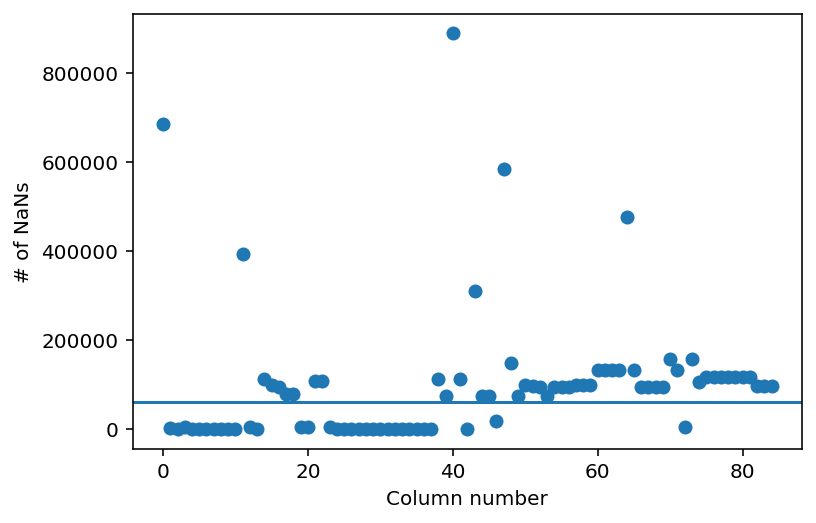

In [27]:
# Draw a point for the sum of NaNs for each column and a line for the threshold

plt.scatter(range(85), outliers_list)
plt.axhline(y=threshold_columns)
plt.xlabel('Column number')
plt.ylabel('# of NaNs')
plt.show()

In [18]:
# Remove all columns with more NaN-values then defined in 'threshold_columns'

data_clean_columns = data_NaNs
for label in outliers_to_remove:
    data_clean_columns.drop([label], axis=1, inplace=True)

In [19]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

#### Discussion 1.1.2: Assess Missing Data in Each Column

>Ok...this seemingly easy task took me forever...
Started with normal data exploration and got quickly a good overview over the data. Reading the 'missing_or_unknown'-column in a proper way, took me really long. And then I took me quite some time and different approaches to come up with the (hopefully correct) solution. I started with the histograms as recommended, but that was really cumbersome. 85 features are just too many to manually check them (or maybe it's just me beeing lazy).

>I set 120,000 outliers as a threshold and got those columns exceeding this threshold regarding outliers:
```
685843 in column AGER_TYP
392318 in column GEBURTSJAHR
889061 in column TITEL_KZ
310267 in column ALTER_HH
584612 in column KK_KUNDENTYP
147988 in column W_KEIT_KIND_HH
133324 in column KBA05_ANTG1
133324 in column KBA05_ANTG2
133324 in column KBA05_ANTG3
133324 in column KBA05_ANTG4
476524 in column KBA05_BAUMAX
133324 in column KBA05_GBZ
158064 in column KKK
133324 in column MOBI_REGIO
158064 in column REGIOTYP
```

>The Scatterplot in 1.1.2.1 helped me to find a good boundry.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [20]:
# How much data is missing in each row of the dataset?

# Calculate NaNs per row

NaNs_per_row = data_clean_columns.isnull().sum(axis=1)
NaNs_row_series = pd.Series(NaNs_per_row)
threshold_rows = 4

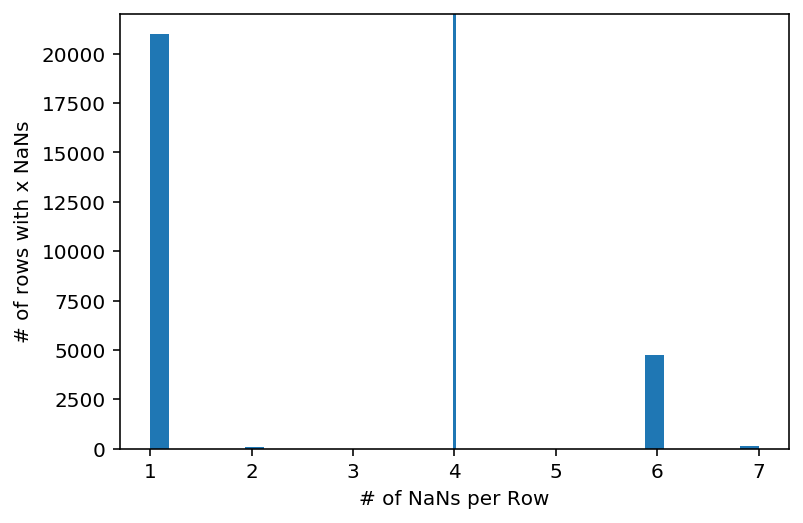

In [26]:
# Draw histogram for # of NaN-Values in rows

plt.hist(NaNs_row_series[NaNs_row_series != 0], bins=data_clean_columns.shape[1])
plt.axvline(x=threshold_rows)
plt.xlabel('# of NaNs per Row')
plt.ylabel('# of rows with x NaNs')
plt.show()

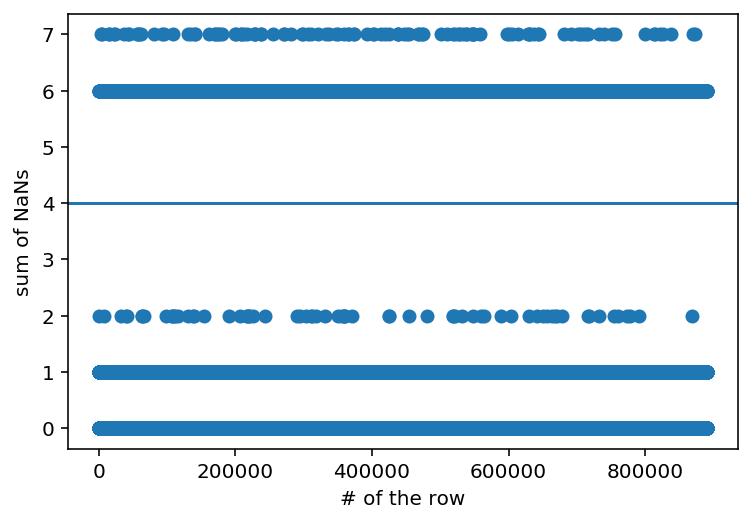

In [29]:
# Draw a scatterplot. Each point represents the # of NaNs for one row. x = rows, y = # of missing values

plt.scatter(range(NaNs_per_row.shape[0]), NaNs_per_row)
plt.axhline(y=threshold_rows)
plt.xlabel('# of the row')
plt.ylabel('sum of NaNs')
plt.show()


In [18]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.


In [19]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.


In [30]:
# Remove all rows with more NaN-values than defined in 'threshold_rows'

data_clean = data_clean_columns.dropna(thresh=data_clean_columns.shape[1]-threshold_rows)

print(str(data_clean_columns.shape[0]-data_clean.shape[0])+' rows deleted')

4854 rows deleted


In [32]:
# show remaining rows and columns

data_clean.shape

(886367, 32)

#### Discussion 1.1.3: Assess Missing Data in Each Row

>Took me again quite some time to figure out how to do that efficiently in pandas, but finally got there. Unfortunately I'm not that good of a Datascientist.

>Looking at the histogram (I removed the ones without missing values, to have a better scale) and the scatterplot I'd say, that 30 values is a good threshold to remove rows with more NaN-values. In total that were 93154 values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [34]:
# How many features are there of each data type?

# Count occurrence of types for all original columns
feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [36]:
# Generate a list of all remaining column-labels

columns_clean = np.array(data_clean.columns).tolist()

In [37]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Create list of all remaining categorical columns
categorical_columns_clean = []
categorical_columns = feat_info[feat_info['type'] == 'categorical']['attribute'].to_numpy().tolist()
for column in columns_clean:
    if column in categorical_columns:
        categorical_columns_clean.append(column)

print(len(categorical_columns))
print(len(categorical_columns_clean))

21
8


ANREDE_KZ


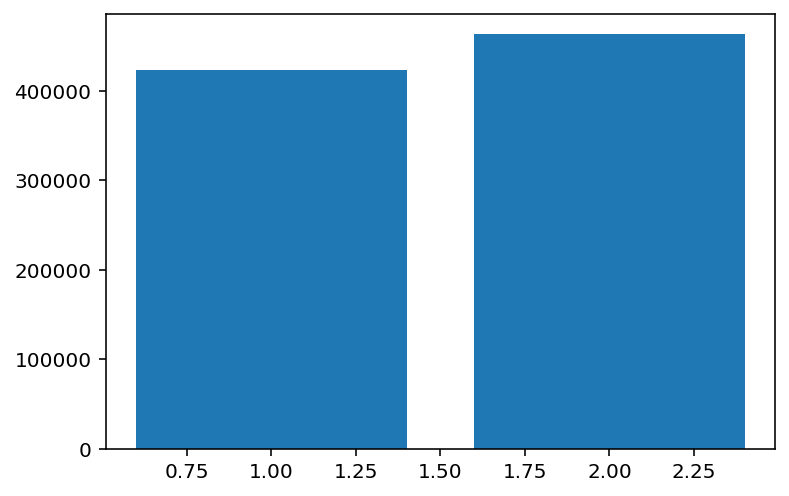


CJT_GESAMTTYP


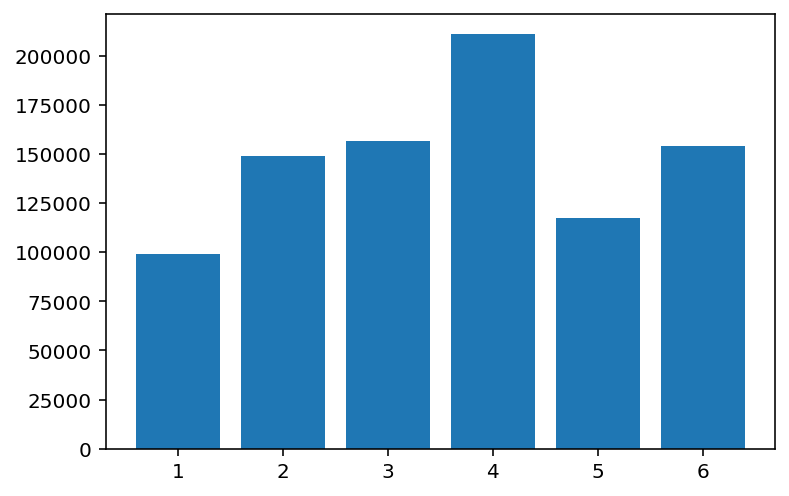


FINANZTYP


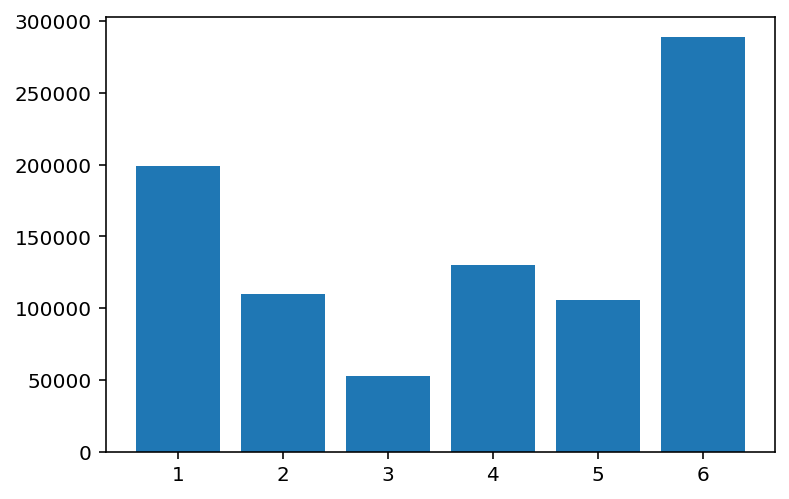


GFK_URLAUBERTYP


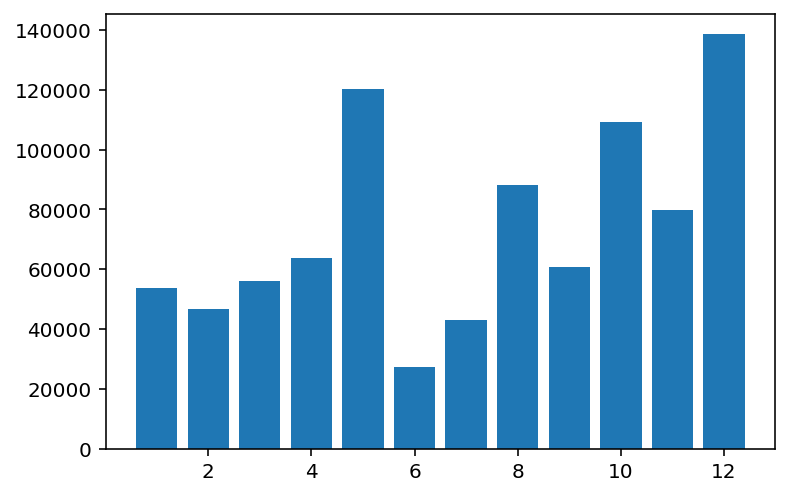


GREEN_AVANTGARDE


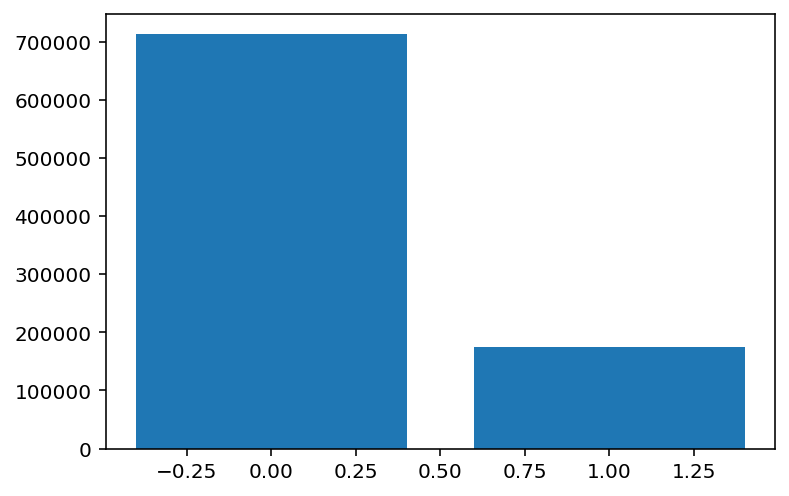


LP_STATUS_FEIN


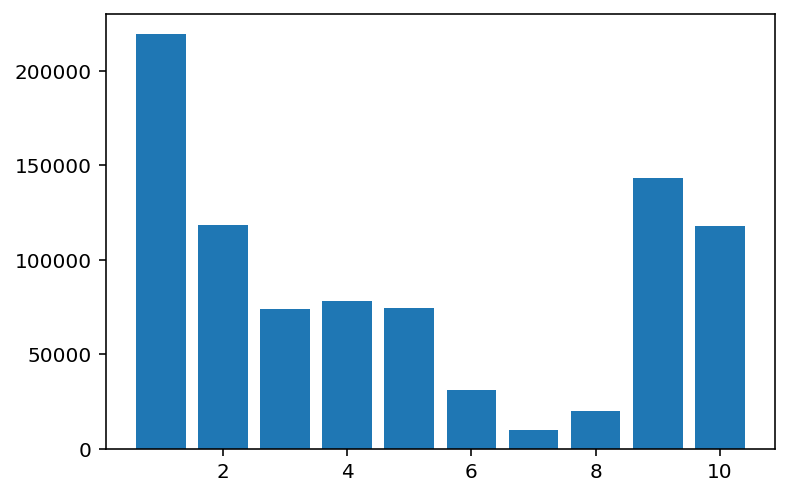


LP_STATUS_GROB


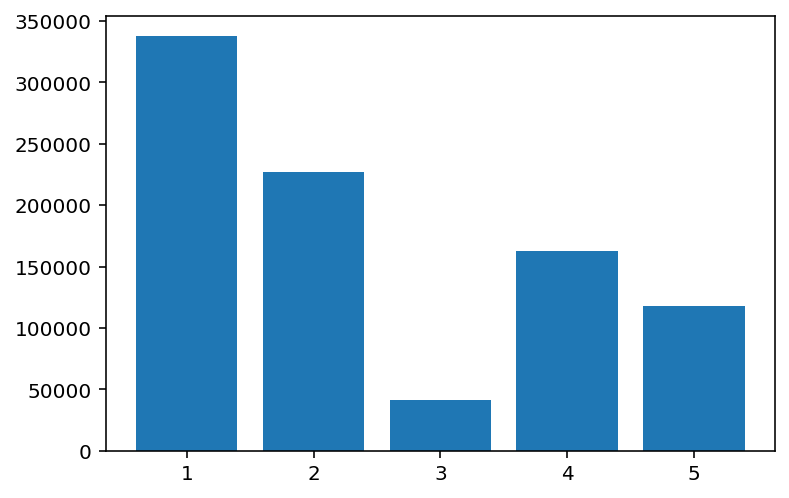


ZABEOTYP


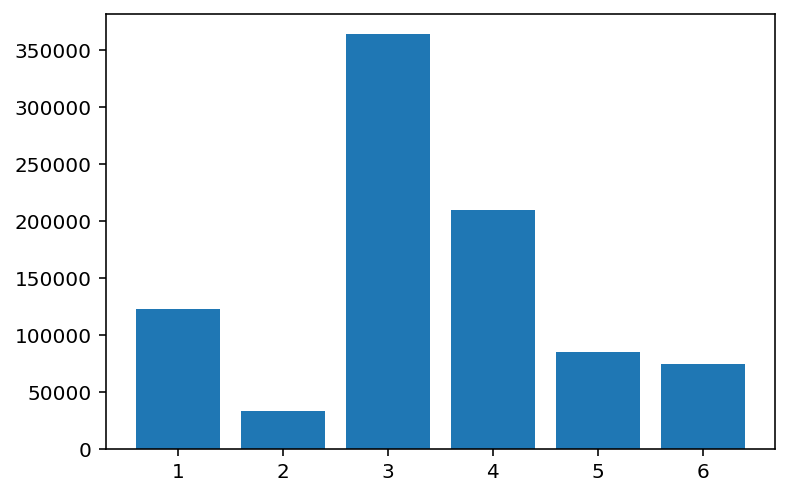

In [39]:
# Count # of different values for each remaining categorical column

for column in categorical_columns_clean:
    print(column)
    plt.bar(data_clean[column].value_counts().sort_index().index,data_clean[column].value_counts().sort_index().values)
    plt.show()
    print('')


In [40]:
# Remove some manually selected rows (redundant information)

data_with_dummies = data_clean.copy()
#columns_remove_manually = ['CAMEO_DEU_2015', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'GFK_URLAUBERTYP', 'CJT_GESAMTTYP', 'SOHO_KZ', 'GEBAEUDETYP', 'NATIONALITAET_KZ', 'LP_FAMILIE_GROB', 'GREEN_AVANTGARDE']
columns_remove_manually = ['LP_STATUS_FEIN', 'GFK_URLAUBERTYP', 'CJT_GESAMTTYP', 'GREEN_AVANTGARDE']
for column in columns_remove_manually:
    data_with_dummies.drop([column], axis=1, inplace=True)
    categorical_columns_clean.remove(column)

In [42]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Create dummies of remaining categorical features

for column in categorical_columns_clean:
    just_dummies = pd.get_dummies(data_with_dummies[column])
    data_with_dummies = pd.concat([data_with_dummies, just_dummies], axis=1)      
    data_with_dummies = data_with_dummies.drop([column], axis=1)

In [29]:
data_with_dummies.sample()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,...,2.0,3.0,4.0,5.0,1,2,3,4,5,6
800372,3.0,3,3,4,2,2,2,5.0,6,6,...,0,0,0,0,0,0,1,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

>With 44 Values 'CAMEO_DEU_2015' seems to be pretty useless, as it'll generate 44 new columns which will be super sparse. In addition it is just a more detailed value for 'CAMEO_DEUG_2015', so the data should be redundant anyways.

>Same for LP_FAMILIE_FEIN and LP_STATUS_FEIN. For both there is another column representing the data in a more basic version.

>For that reason I decided to drop those columns to avoid bloating the feature-set.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [44]:
# display features of type 'mixed'

feat_info[feat_info['type'] == 'mixed']['attribute']

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
64             KBA05_BAUMAX
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [45]:
#data_with_dummies = data_with_dummies.drop(['LP_LEBENSPHASE_FEIN'], axis=1)
#data_with_dummies = data_with_dummies.drop(['LP_LEBENSPHASE_GROB'], axis=1)
#data_with_dummies = data_with_dummies.drop(['WOHNLAGE'], axis=1)
#data_with_dummies = data_with_dummies.drop(['PLZ8_BAUMAX'], axis=1)

In [46]:
"""
regarding_DECADE = data_with_dummies['PRAEGENDE_JUGENDJAHRE'].copy()
PRAEGENDE_JUGENDJAHRE_MOVEMENT = data_with_dummies['PRAEGENDE_JUGENDJAHRE'].copy()



PRAEGENDE_JUGENDJAHRE_DECADE.replace([1,2], 1, inplace=True) # 40s
PRAEGENDE_JUGENDJAHRE_DECADE.replace([3,4], 2, inplace=True) # 50s
PRAEGENDE_JUGENDJAHRE_DECADE.replace([5,6,7], 3, inplace=True) # 60s
PRAEGENDE_JUGENDJAHRE_DECADE.replace([8,9], 4, inplace=True) # 70s
PRAEGENDE_JUGENDJAHRE_DECADE.replace([10,11,12,13], 5, inplace=True) # 80s
PRAEGENDE_JUGENDJAHRE_DECADE.replace([14,15], 6, inplace=True) # 90s

PRAEGENDE_JUGENDJAHRE_MOVEMENT.replace([1,3,5,8,10,12,14], 1, inplace=True) # Mainstream
PRAEGENDE_JUGENDJAHRE_MOVEMENT.replace([2,4,6,7,9,11,13,15], 2, inplace=True) # Mainstream



data_with_dummies['PRAEGENDE_JUGENDJAHRE_DECADE'] = PRAEGENDE_JUGENDJAHRE_DECADE
data_with_dummies['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = PRAEGENDE_JUGENDJAHRE_MOVEMENT

data_with_dummies = data_with_dummies.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1)
"""

"\nregarding_DECADE = data_with_dummies['PRAEGENDE_JUGENDJAHRE'].copy()\nPRAEGENDE_JUGENDJAHRE_MOVEMENT = data_with_dummies['PRAEGENDE_JUGENDJAHRE'].copy()\n\n\n\nPRAEGENDE_JUGENDJAHRE_DECADE.replace([1,2], 1, inplace=True) # 40s\nPRAEGENDE_JUGENDJAHRE_DECADE.replace([3,4], 2, inplace=True) # 50s\nPRAEGENDE_JUGENDJAHRE_DECADE.replace([5,6,7], 3, inplace=True) # 60s\nPRAEGENDE_JUGENDJAHRE_DECADE.replace([8,9], 4, inplace=True) # 70s\nPRAEGENDE_JUGENDJAHRE_DECADE.replace([10,11,12,13], 5, inplace=True) # 80s\nPRAEGENDE_JUGENDJAHRE_DECADE.replace([14,15], 6, inplace=True) # 90s\n\nPRAEGENDE_JUGENDJAHRE_MOVEMENT.replace([1,3,5,8,10,12,14], 1, inplace=True) # Mainstream\nPRAEGENDE_JUGENDJAHRE_MOVEMENT.replace([2,4,6,7,9,11,13,15], 2, inplace=True) # Mainstream\n\n\n\ndata_with_dummies['PRAEGENDE_JUGENDJAHRE_DECADE'] = PRAEGENDE_JUGENDJAHRE_DECADE\ndata_with_dummies['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = PRAEGENDE_JUGENDJAHRE_MOVEMENT\n\ndata_with_dummies = data_with_dummies.drop(['PRAEGENDE_JU

In [47]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
"""
CAMEO_INTL_2015_placeholder = data_with_dummies.CAMEO_INTL_2015.fillna('--').astype(str)

CAMEO_INTL_2015_first = CAMEO_INTL_2015_placeholder.astype(str).str[0]
CAMEO_INTL_2015_second = CAMEO_INTL_2015_placeholder.astype(str).str[1]

CAMEO_INTL_2015_first.replace('-', np.nan, inplace=True)
CAMEO_INTL_2015_second.replace('-', np.nan, inplace=True)

data_with_dummies['CAMEO_INTL_2015_first'] = CAMEO_INTL_2015_first
data_with_dummies['CAMEO_INTL_2015_second'] = CAMEO_INTL_2015_second

data_with_dummies = data_with_dummies.drop(['CAMEO_INTL_2015'], axis=1)
"""

"\nCAMEO_INTL_2015_placeholder = data_with_dummies.CAMEO_INTL_2015.fillna('--').astype(str)\n\nCAMEO_INTL_2015_first = CAMEO_INTL_2015_placeholder.astype(str).str[0]\nCAMEO_INTL_2015_second = CAMEO_INTL_2015_placeholder.astype(str).str[1]\n\nCAMEO_INTL_2015_first.replace('-', np.nan, inplace=True)\nCAMEO_INTL_2015_second.replace('-', np.nan, inplace=True)\n\ndata_with_dummies['CAMEO_INTL_2015_first'] = CAMEO_INTL_2015_first\ndata_with_dummies['CAMEO_INTL_2015_second'] = CAMEO_INTL_2015_second\n\ndata_with_dummies = data_with_dummies.drop(['CAMEO_INTL_2015'], axis=1)\n"

#### Discussion 1.2.2: Engineer Mixed-Type Features

Removed 'LP_LEBENSPHASE_FEIN' as it is redundant with 'LP_LEBENSPHASE_GROB' and has too many different values. In general I'd tend to also hot-encode the values here, as the distances don't hold any meaning.

For 'CAMEO_INTL_2015' I split it up into two columns as suggested, it just makes sense.

PRAEGENDE_JUGENDJAHRE were, also as suggested, split up into PRAEGENDE_JUGENDJAHRE_DECADE and PRAEGENDE_JUGENDJAHRE_MOVEMENT.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [48]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [49]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [50]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for i, column in enumerate(df):
        df[column] = df[column].replace(empty_values[i], np.nan)
    
    # remove selected columns and rows, ...
    for label in outliers_to_remove:
        df.drop([label], axis=1, inplace=True)
        
    NaNs_row_series_demo = pd.Series(df.isnull().sum(axis=1))
    df = df.dropna(thresh=df.shape[1]-threshold_rows)
    
    for column in columns_remove_manually:
        df.drop([column], axis=1, inplace=True)
    
    # select, re-encode, and engineer column values.
    for column in categorical_columns_clean:
        just_dummies = pd.get_dummies(df[column])
        df = pd.concat([df, just_dummies], axis=1)      
        df = df.drop([column], axis=1)
    
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [51]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Those column-titels ware needed later
columns_pca = data_with_dummies.columns

In [52]:
# SimpleImputer fills all nans with the mean of each column

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(data_with_dummies)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [53]:
data_filled = imp_mean.transform(data_with_dummies)

In [55]:
# Apply feature scaling to the general population demographics data.

scalerStd = StandardScaler()
scalerStd.fit(data_filled)
#scalerStd.mean_ # returns the mean for each column
scalerStd.transform(data_filled)

array([[-0.7501337 , -0.05508437,  0.80351523, ..., -0.55540458,
        -0.32471909, -0.30178309],
       [-1.74178576, -1.5693891 ,  1.4862267 , ..., -0.55540458,
         3.07958489, -0.30178309],
       [ 0.24151835, -1.5693891 ,  0.80351523, ..., -0.55540458,
         3.07958489, -0.30178309],
       ...,
       [-0.7501337 , -0.81223674,  0.80351523, ...,  1.80048928,
        -0.32471909, -0.30178309],
       [-1.74178576, -1.5693891 ,  1.4862267 , ..., -0.55540458,
         3.07958489, -0.30178309],
       [ 1.23317041,  0.70206799, -0.56190771, ..., -0.55540458,
        -0.32471909, -0.30178309]])

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [57]:
# function to nicely draw the variance of pca components

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    PLZ8_BAUMAX
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    plt.axhline(y=cumvals[len(cumvals)-1])
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [66]:
# Apply PCA to the data.

# Applies PCA for different number of features and compares the variance

"""
old = 0
velo = 0
for i in range(15,31):
    pca = PCA(i)
    data_pca = pca.fit_transform(data_filled)
    total = np.sum(pca.explained_variance_ratio_)
    print('for '+str(i)+' components the total variance captured is '+str(round(total*100, 4))+' (+'+str( round((total-old)-velo,4)*100 )+')')
    old = total
    velo = total-old
"""

"\nold = 0\nvelo = 0\nfor i in range(15,31):\n    pca = PCA(i)\n    data_pca = pca.fit_transform(data_filled)\n    total = np.sum(pca.explained_variance_ratio_)\n    print('for '+str(i)+' components the total variance captured is '+str(round(total*100, 4))+' (+'+str( round((total-old)-velo,4)*100 )+')')\n    old = total\n    velo = total-old\n"

In [67]:
pca = PCA(17)
data_pca = pca.fit_transform(data_filled)
print(np.sum(pca.explained_variance_ratio_))

0.9395782809211087


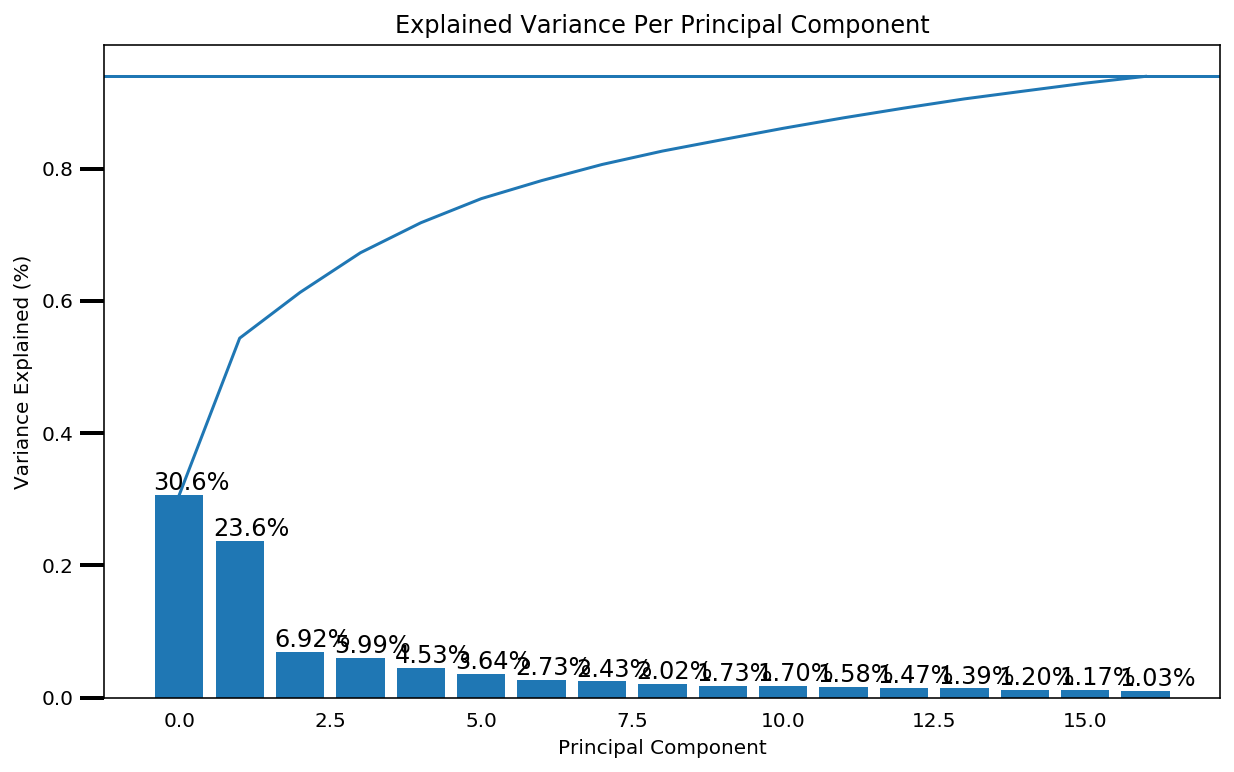

In [68]:
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

After having heavy problems with the outliers and NaNs (one componend hat 99% variance), I went back to the very beginning and adjusted my thresholds for the datacleaning again.

Eventually I got better results.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [69]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# function to display all the component weights of a principle component
# pca
# labels (array with all the according labels)
# comp (# of the component that should be displayed)

def exam_comp(pca, labels, comp):
    components = pd.DataFrame(np.round(pca.components_, 4), columns = labels)
    print(components.iloc[comp].sort_values())

exam_comp(pca, columns_pca, 0)

SEMIO_ERL               -0.3166
SEMIO_LUST              -0.2141
SEMIO_KAEM              -0.1940
SEMIO_KRIT              -0.1823
FINANZ_VORSORGER        -0.1692
ALTERSKATEGORIE_GROB    -0.1546
SEMIO_DOM               -0.1541
RETOURTYP_BK_S          -0.0969
FINANZ_MINIMALIST       -0.0767
2                       -0.0537
3                       -0.0516
FINANZ_HAUSBAUER        -0.0370
2                       -0.0236
6                       -0.0204
5.0                     -0.0081
5                       -0.0076
4.0                     -0.0055
3.0                     -0.0004
2                        0.0001
2.0                      0.0021
6                        0.0030
3                        0.0071
1.0                      0.0118
1                        0.0124
HH_EINKOMMEN_SCORE       0.0144
4                        0.0157
5                        0.0176
4                        0.0185
1                        0.0288
1                        0.0537
ONLINE_AFFINITAET        0.0911
SEMIO_RA

In [70]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

exam_comp(pca, columns_pca, 1)

SEMIO_KAEM              -0.3440
SEMIO_DOM               -0.3198
SEMIO_KRIT              -0.2836
SEMIO_RAT               -0.2631
FINANZ_ANLEGER          -0.2416
SEMIO_PFLICHT           -0.2075
FINANZ_SPARER           -0.1968
FINANZ_UNAUFFAELLIGER   -0.1890
SEMIO_TRADV             -0.1551
SEMIO_REL               -0.1388
2                       -0.0852
SEMIO_MAT               -0.0645
FINANZ_HAUSBAUER        -0.0501
ONLINE_AFFINITAET       -0.0441
1                       -0.0381
4                       -0.0287
SEMIO_ERL               -0.0231
1.0                     -0.0170
4                       -0.0167
2.0                     -0.0154
5                       -0.0135
2                       -0.0013
3                        0.0008
3.0                      0.0034
3                        0.0045
HH_EINKOMMEN_SCORE       0.0049
6                        0.0054
5.0                      0.0134
2                        0.0154
4.0                      0.0155
1                        0.0216
6       

In [71]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

exam_comp(pca, columns_pca, 2)

HH_EINKOMMEN_SCORE      -0.6398
FINANZ_HAUSBAUER        -0.3936
SEMIO_SOZ               -0.1988
1.0                     -0.1345
SEMIO_ERL               -0.1270
SEMIO_TRADV             -0.1097
SEMIO_RAT               -0.0917
SEMIO_KULT              -0.0715
1                       -0.0714
SEMIO_PFLICHT           -0.0486
SEMIO_VERT              -0.0479
FINANZ_SPARER           -0.0402
RETOURTYP_BK_S          -0.0378
4                       -0.0353
2                       -0.0316
SEMIO_KAEM              -0.0310
5                       -0.0275
6                       -0.0238
6                       -0.0181
5                       -0.0070
3.0                      0.0097
2                        0.0109
SEMIO_DOM                0.0112
2                        0.0170
FINANZ_VORSORGER         0.0173
3                        0.0202
2.0                      0.0210
3                        0.0247
ALTERSKATEGORIE_GROB     0.0307
1                        0.0316
1                        0.0438
4.0     

### Discussion 2.3: Interpret Principal Components

Seems like the features describing the personality are quite important for many components, which kind of makes sense. Also money is important (HH_EINKOMMEN_SCORE, FINANZ_HAUSBAUER, FINANZ_MINIMALIST).

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [72]:
# scale components to lay between 0 and 1

scalerMinMax = MinMaxScaler().fit(data_pca)
data_scaled = scalerMinMax.transform(data_pca)

In [74]:
# Over a number of different cluster counts...

# Calc score for diffrent clusters

"""
def get_kmeans_score(data, center):
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    
    return score

scores = []
centers = list(range(15,31))

for center in centers:
    scores.append(get_kmeans_score(data_scaled, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');
"""

"\ndef get_kmeans_score(data, center):\n    kmeans = KMeans(n_clusters=center)\n    model = kmeans.fit(data)\n    score = np.abs(model.score(data))\n    \n    return score\n\nscores = []\ncenters = list(range(15,31))\n\nfor center in centers:\n    scores.append(get_kmeans_score(data_scaled, center))\n    \nplt.plot(centers, scores, linestyle='--', marker='o', color='b');\nplt.xlabel('K');\nplt.ylabel('SSE');\nplt.title('SSE vs. K');\n"

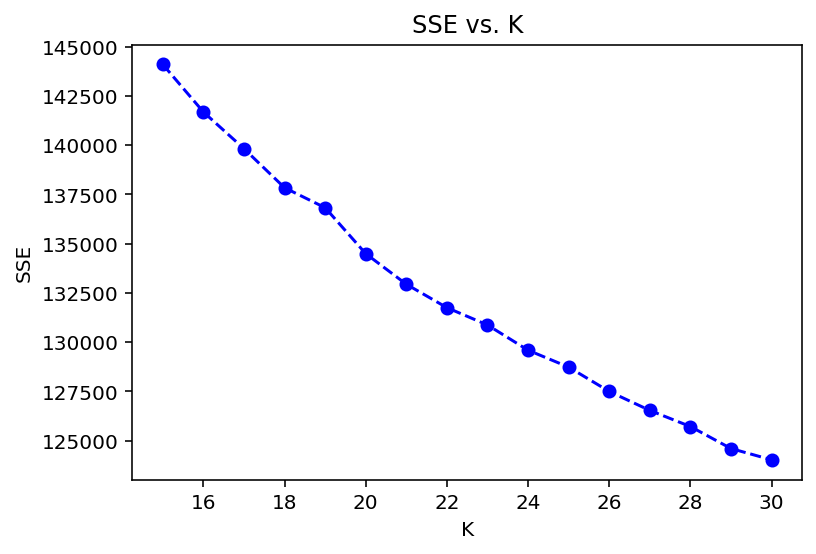

In [51]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.



In [75]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# fit KMeans for selected # of clusters

kmeans = KMeans(n_clusters=20)
model = kmeans.fit(data_scaled)

In [77]:
# predict for general
pred = kmeans.predict(data_scaled)

In [82]:
# displays number of people per cluster

general_pred = pd.DataFrame(pred)
general_pred[0].value_counts()

1     76551
2     70384
10    56902
0     56839
9     48851
19    48674
12    47113
4     45705
17    43993
13    42403
6     42038
8     40680
14    39115
3     38048
11    35729
15    35645
18    33543
16    31476
7     27671
5     25007
Name: 0, dtype: int64

##### result with 4 clusters
2    259176  
0    254693  
1    249152  
3    123346  
Name: 0, dtype: int64  

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [87]:
# Load in the customer demographics data.
customers = pd.read_csv('./Udacity_CUSTOMERS_Subset.csv', delimiter=';')
customers.shape

(191652, 85)

AGER_TYP


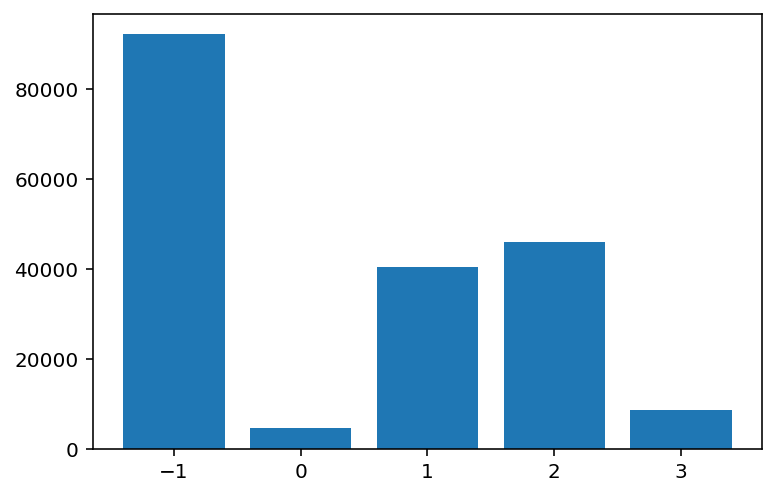

ALTERSKATEGORIE_GROB


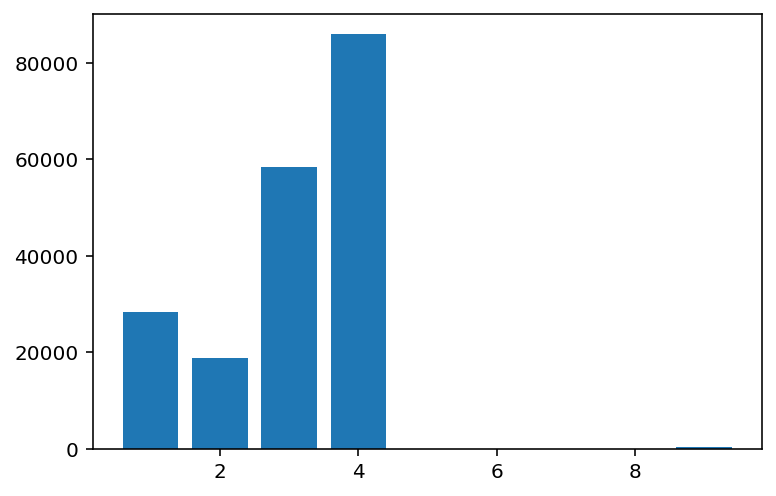

ANREDE_KZ


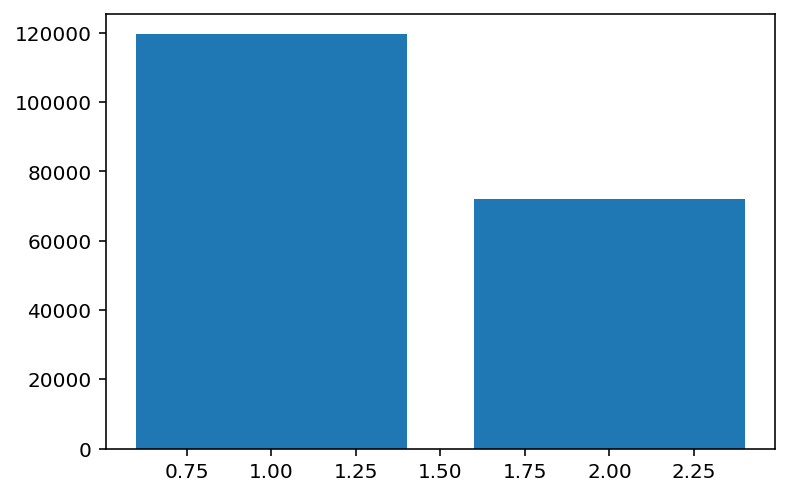

CJT_GESAMTTYP


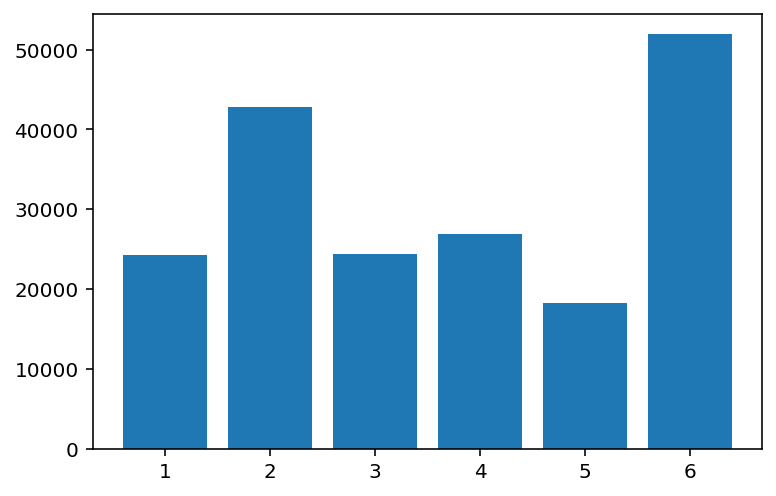

FINANZ_MINIMALIST


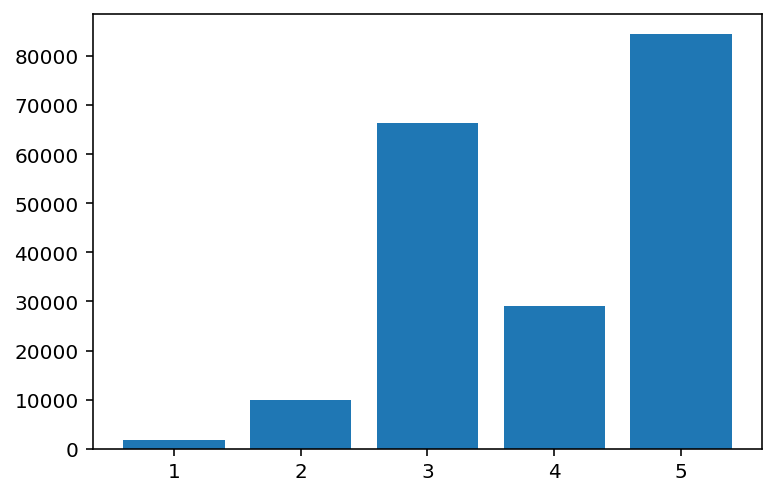

FINANZ_SPARER


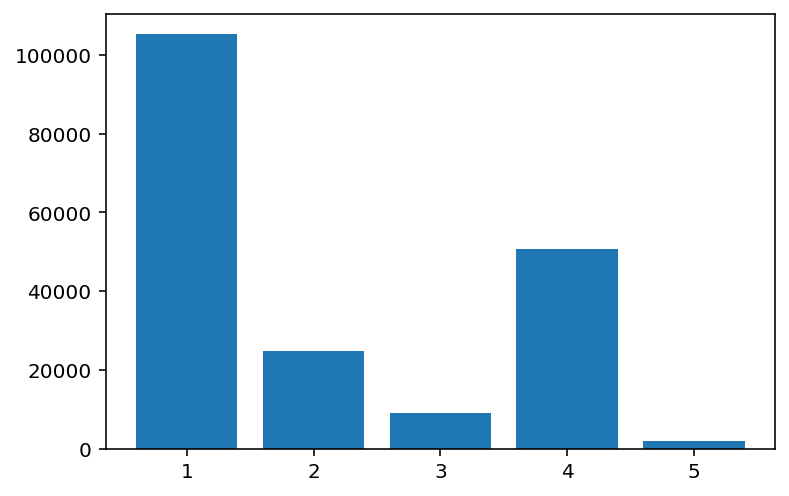

FINANZ_VORSORGER


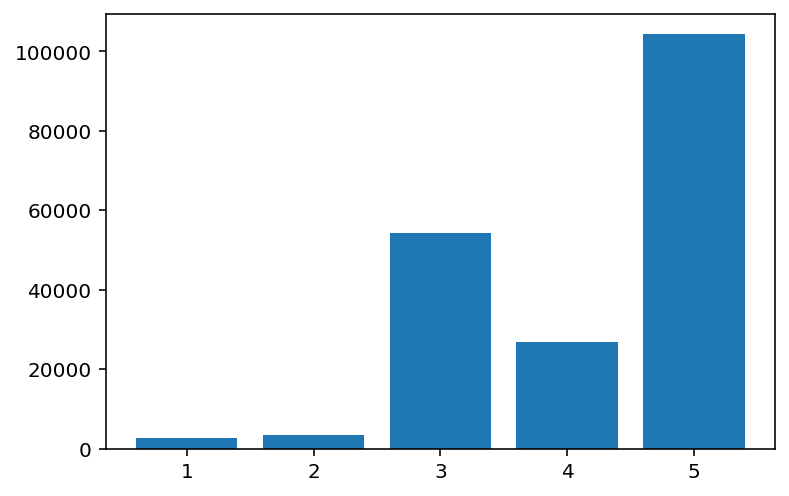

FINANZ_ANLEGER


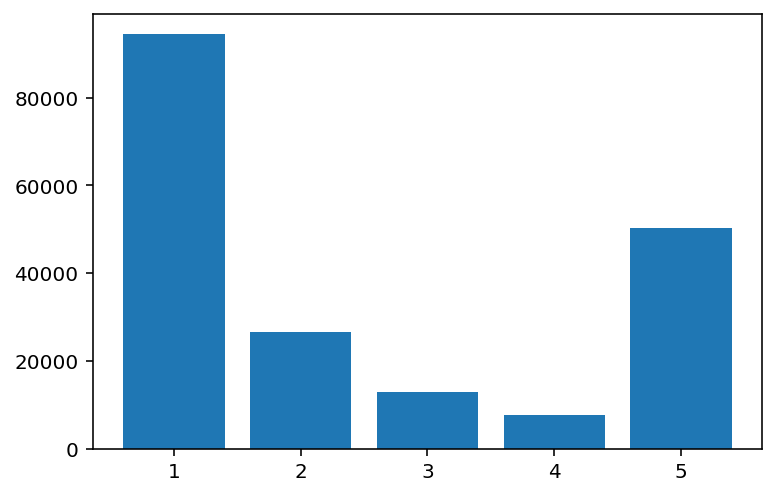

FINANZ_UNAUFFAELLIGER


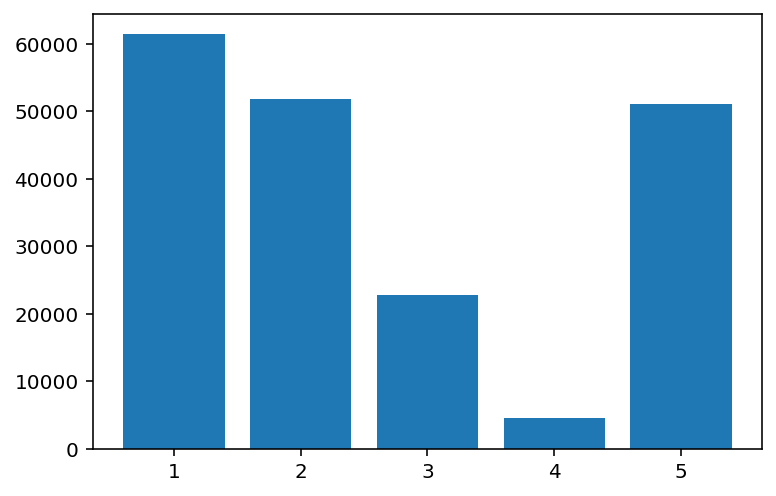

FINANZ_HAUSBAUER


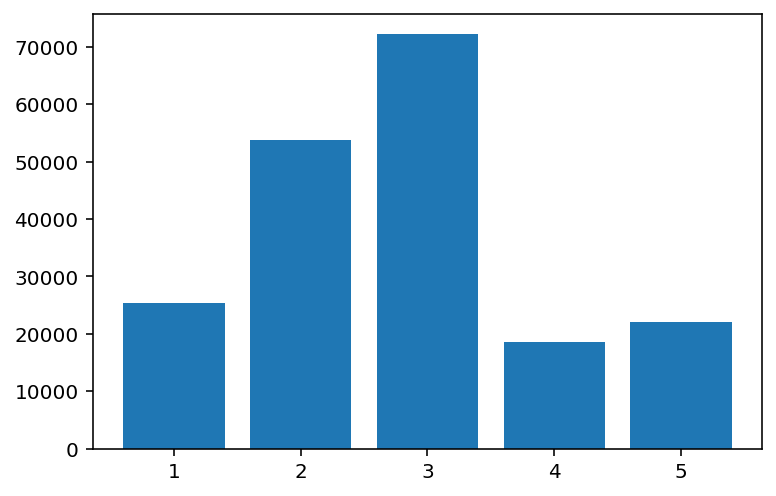

FINANZTYP


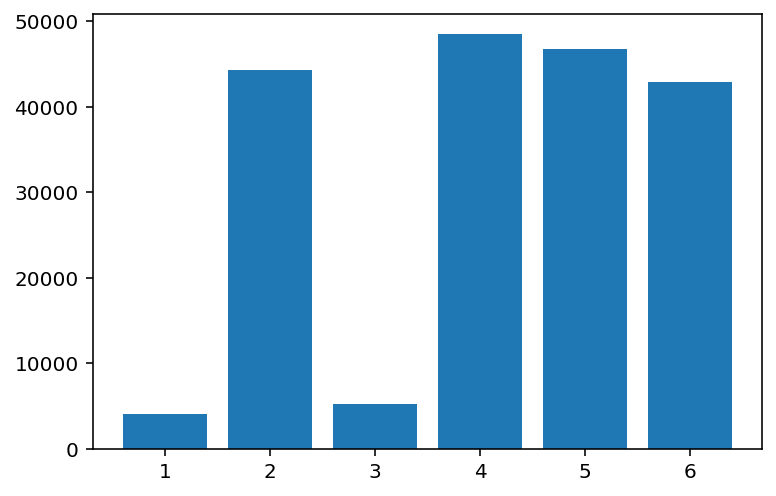

GEBURTSJAHR


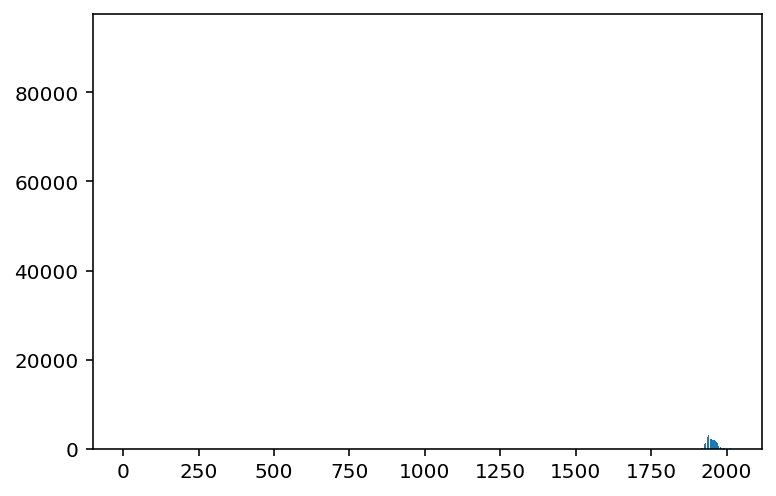

GFK_URLAUBERTYP


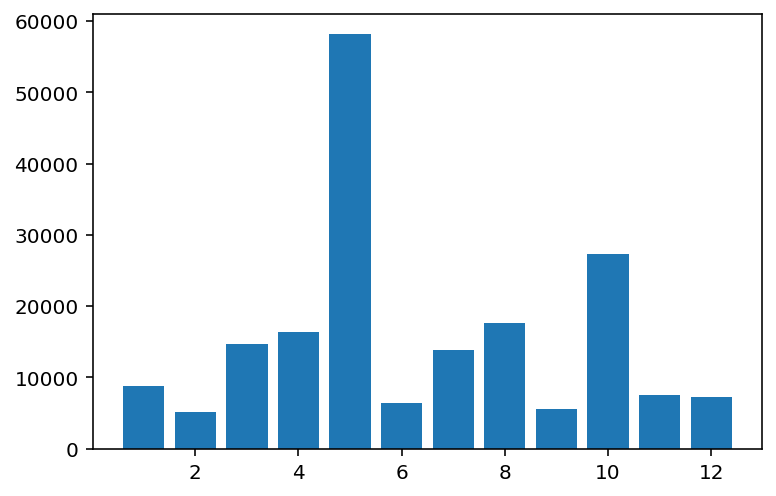

GREEN_AVANTGARDE


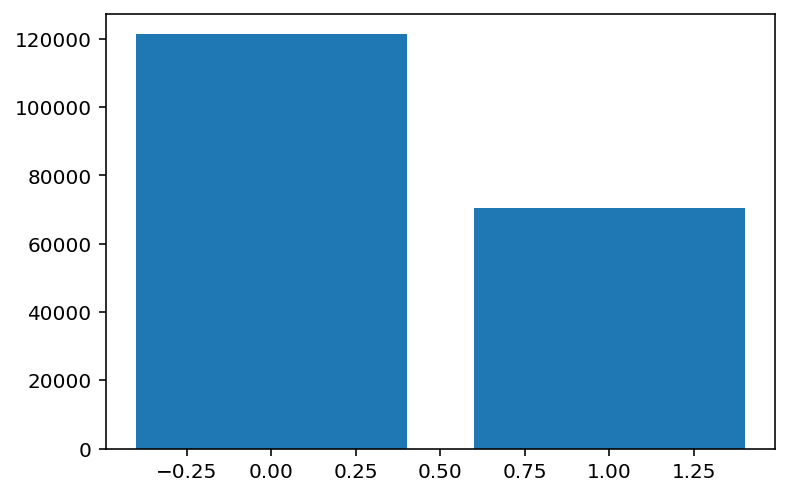

HEALTH_TYP


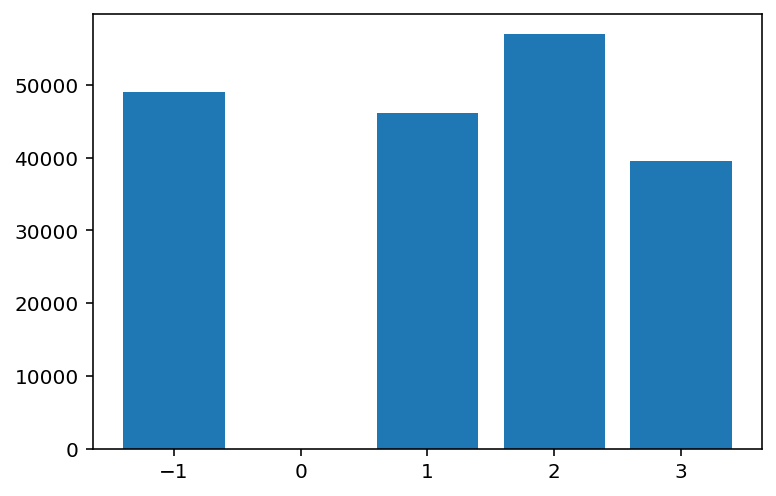

LP_LEBENSPHASE_FEIN


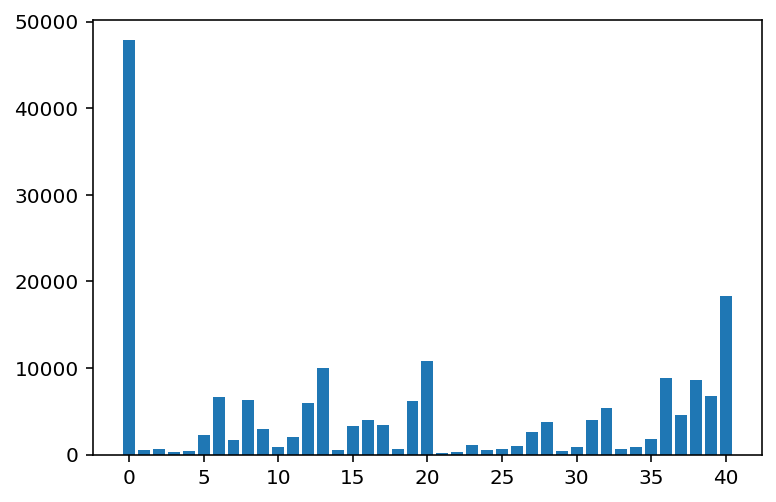

LP_LEBENSPHASE_GROB


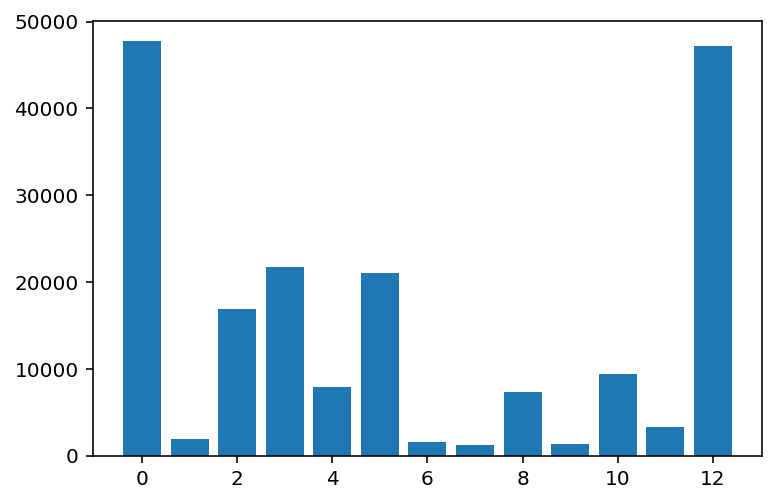

LP_FAMILIE_FEIN


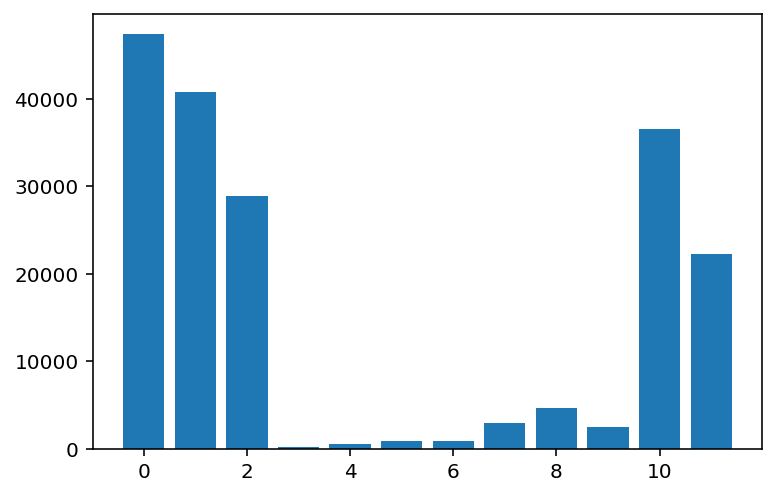

LP_FAMILIE_GROB


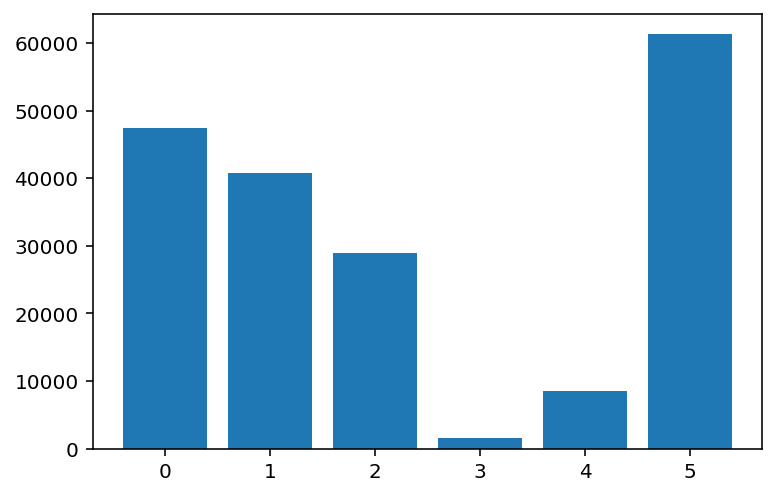

LP_STATUS_FEIN


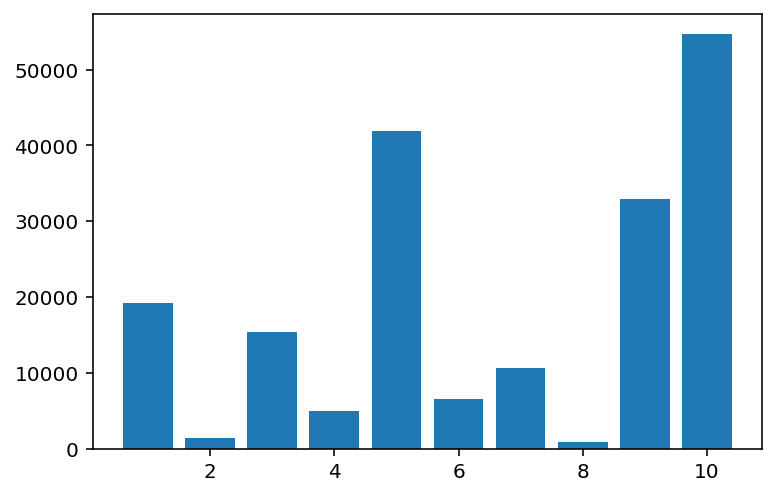

LP_STATUS_GROB


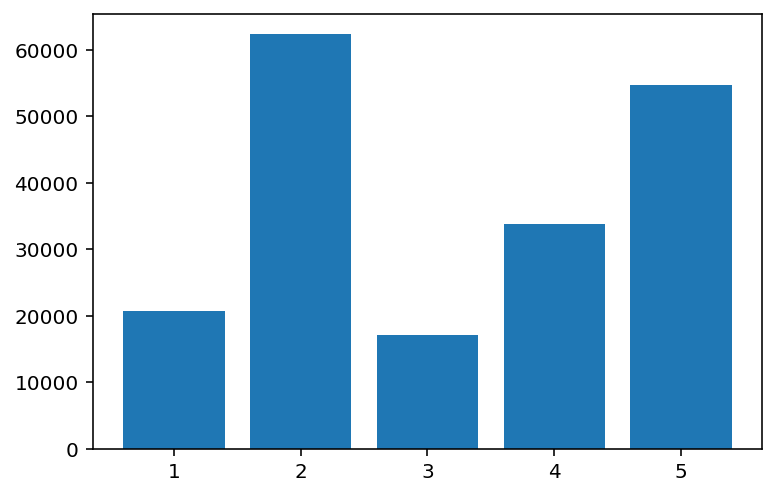

NATIONALITAET_KZ


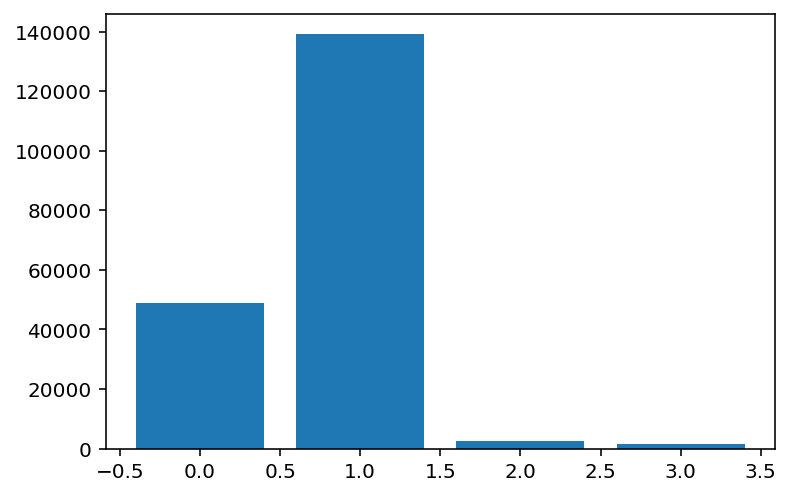

PRAEGENDE_JUGENDJAHRE


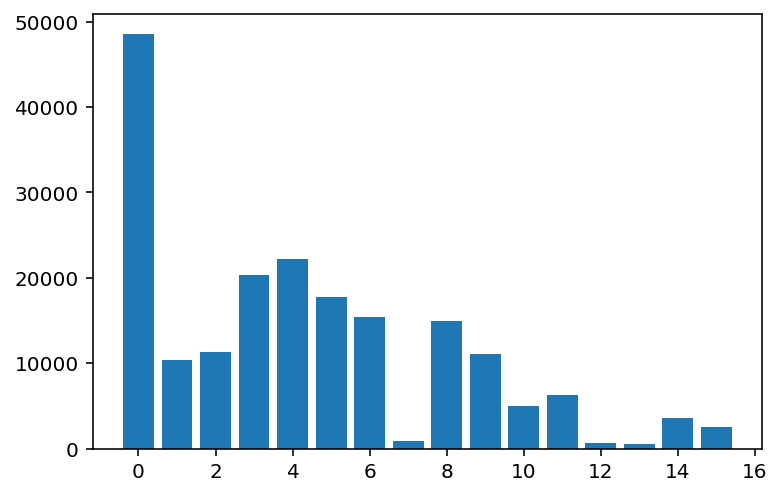

RETOURTYP_BK_S


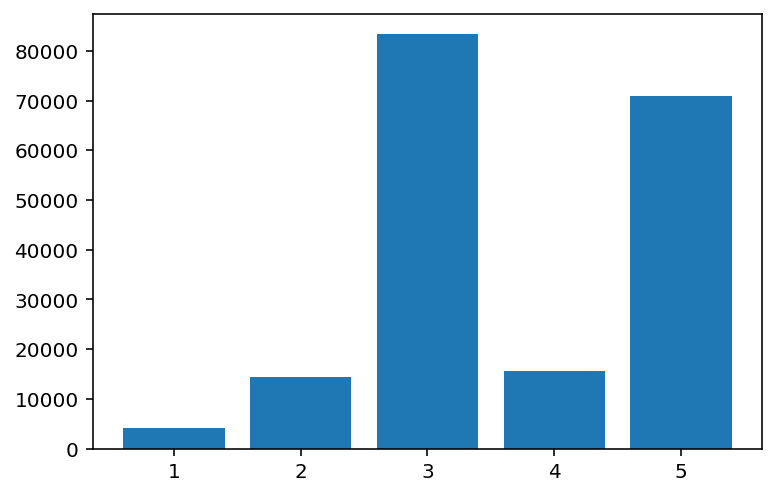

SEMIO_SOZ


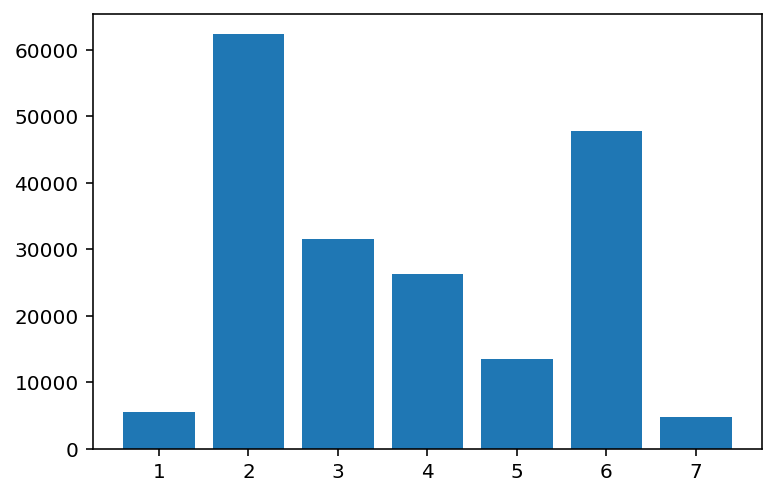

SEMIO_FAM


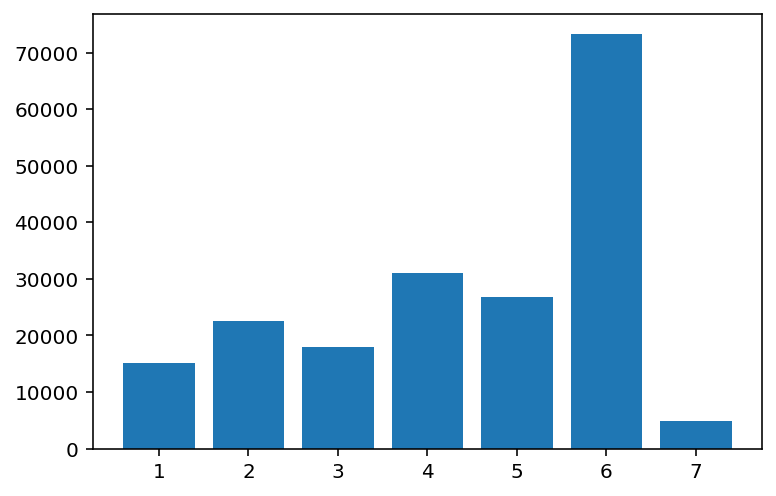

SEMIO_REL


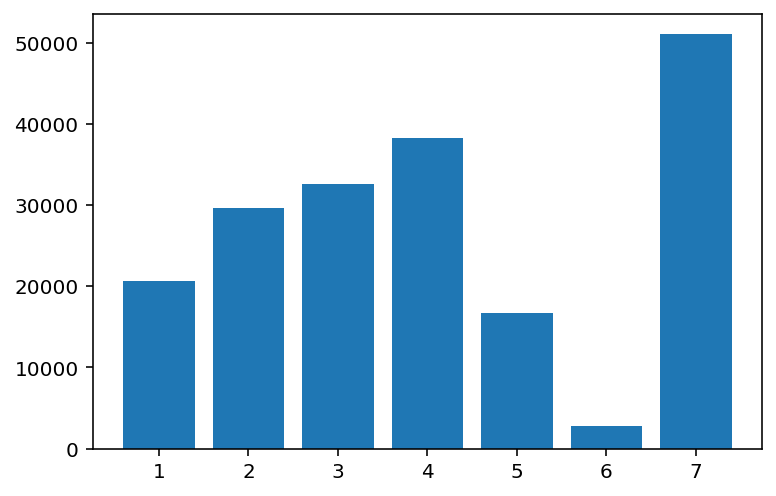

SEMIO_MAT


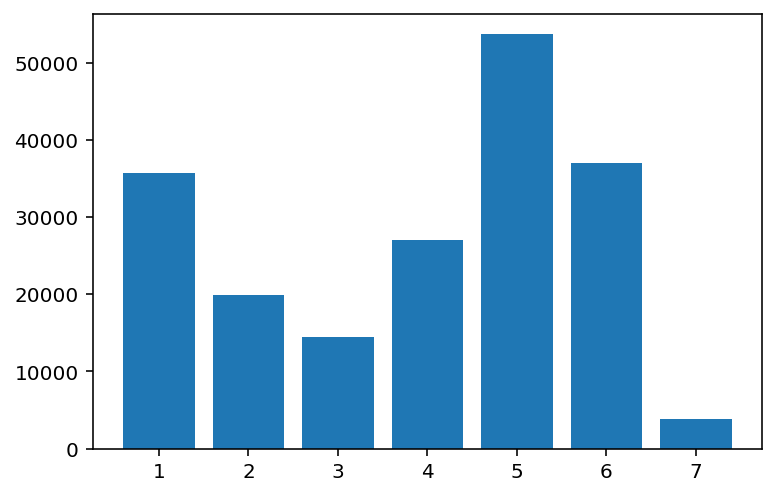

SEMIO_VERT


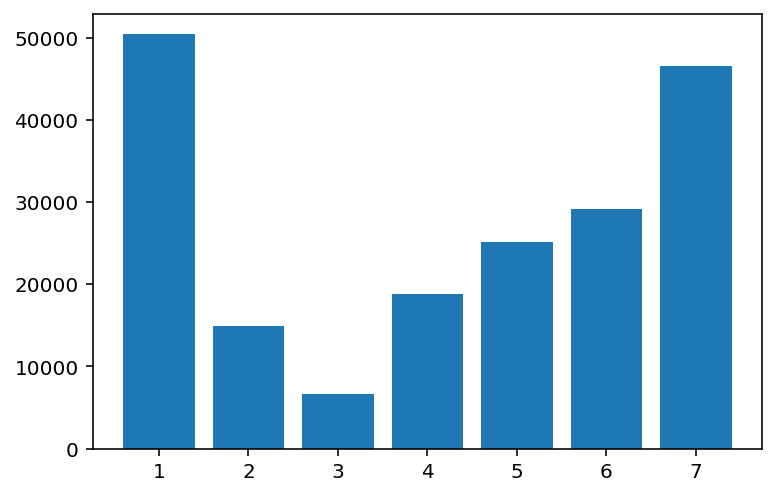

SEMIO_LUST


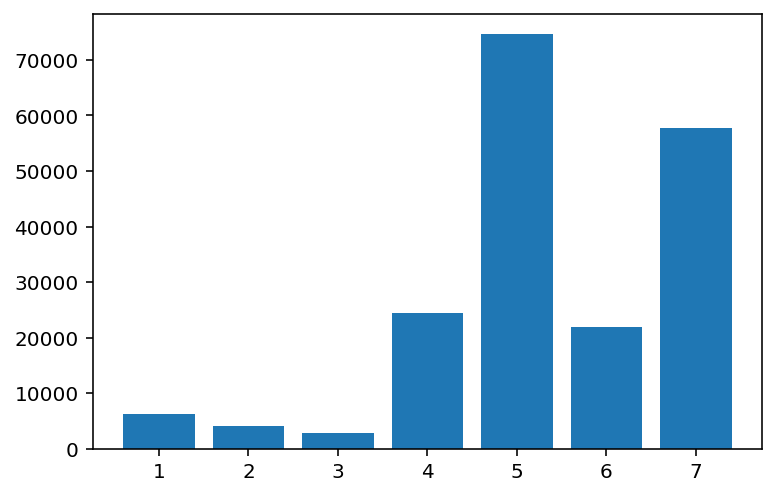

SEMIO_ERL


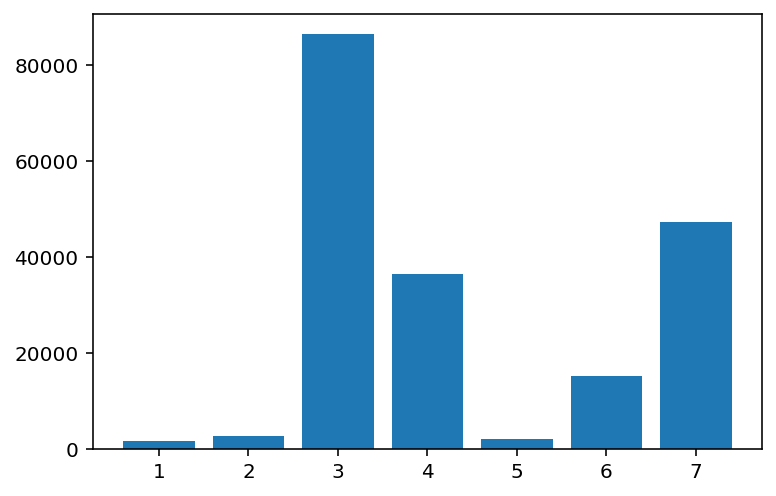

SEMIO_KULT


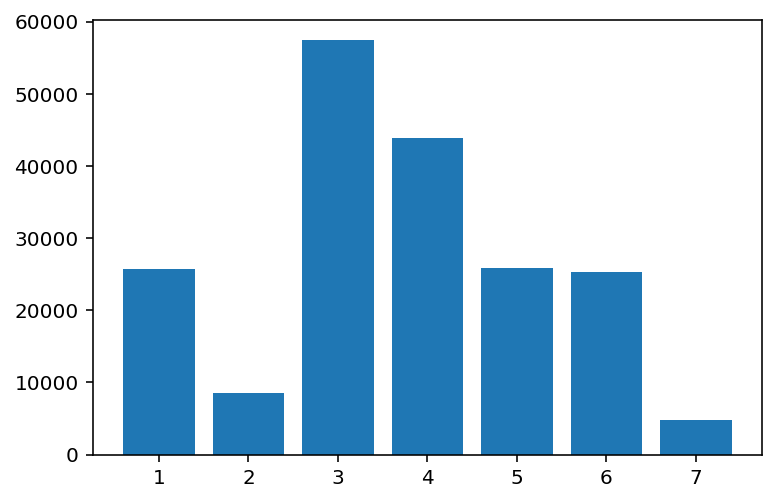

SEMIO_RAT


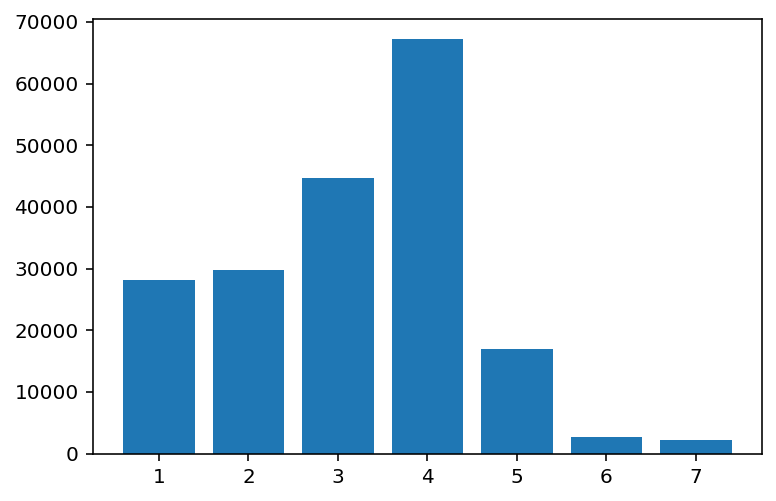

SEMIO_KRIT


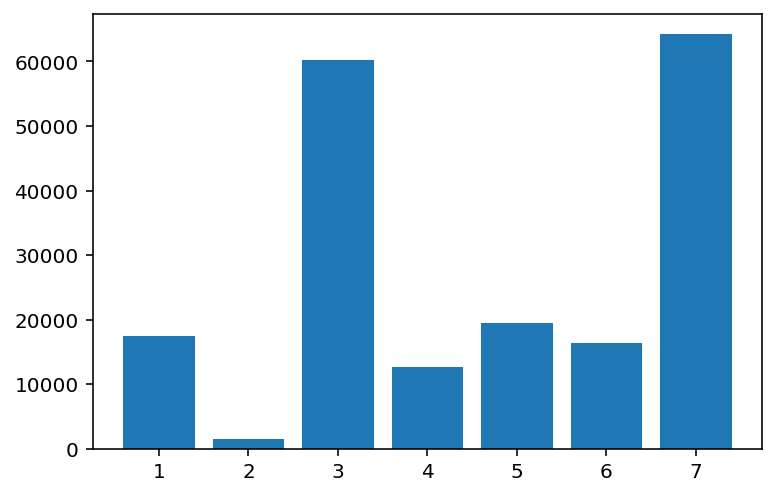

SEMIO_DOM


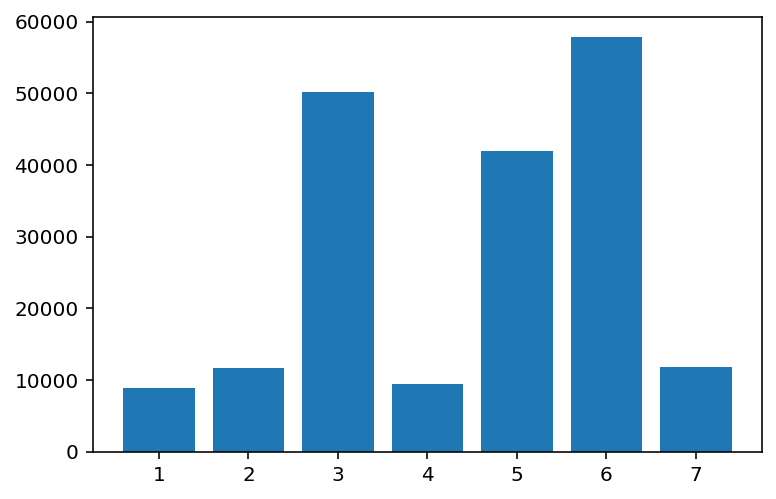

SEMIO_KAEM


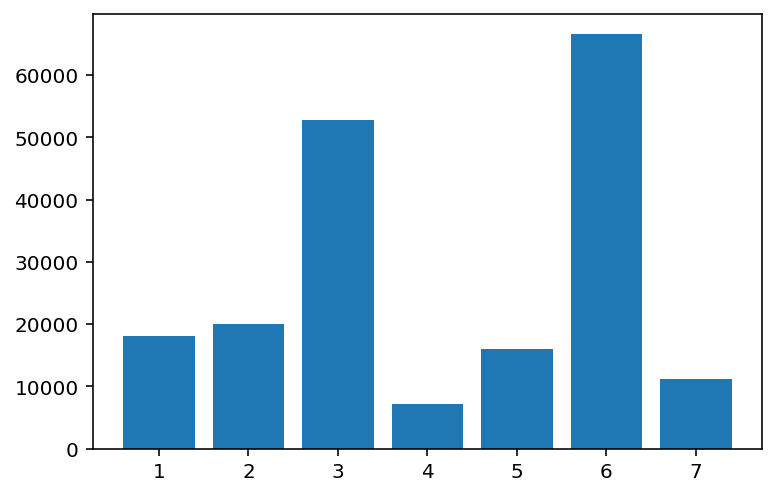

SEMIO_PFLICHT


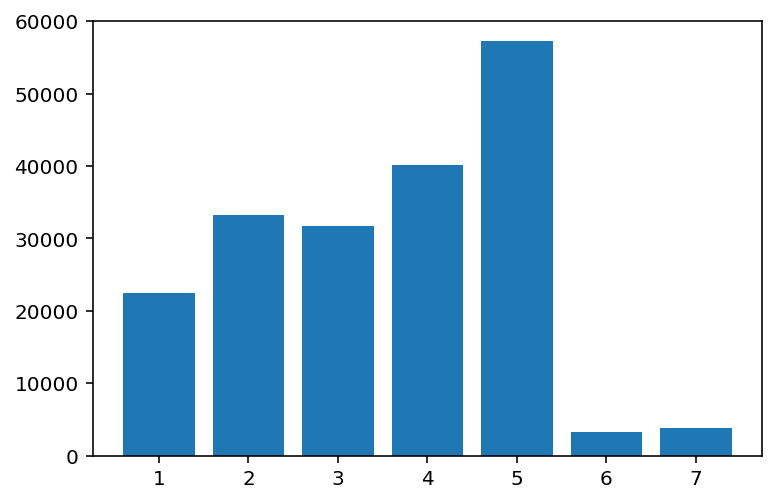

SEMIO_TRADV


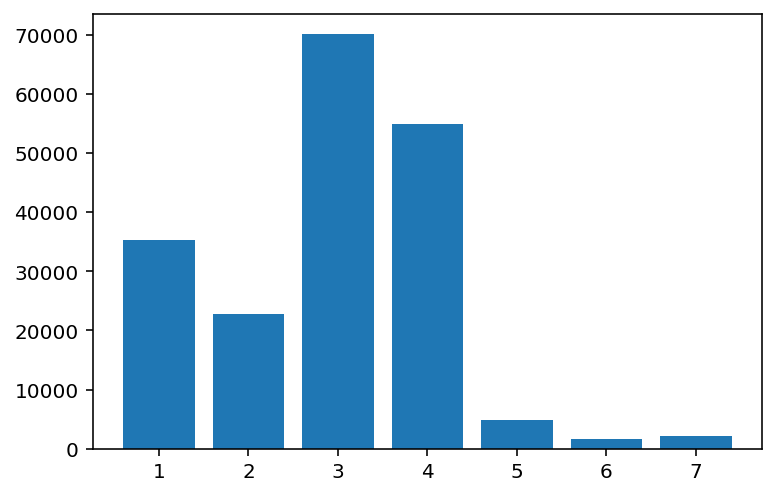

SHOPPER_TYP


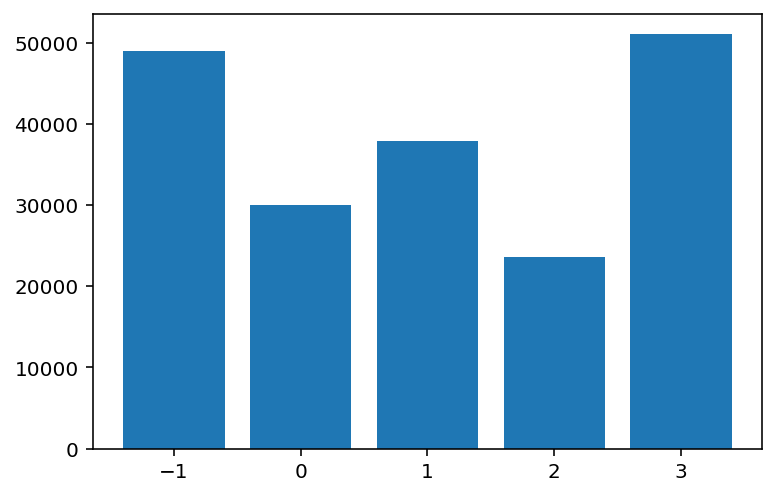

SOHO_KZ


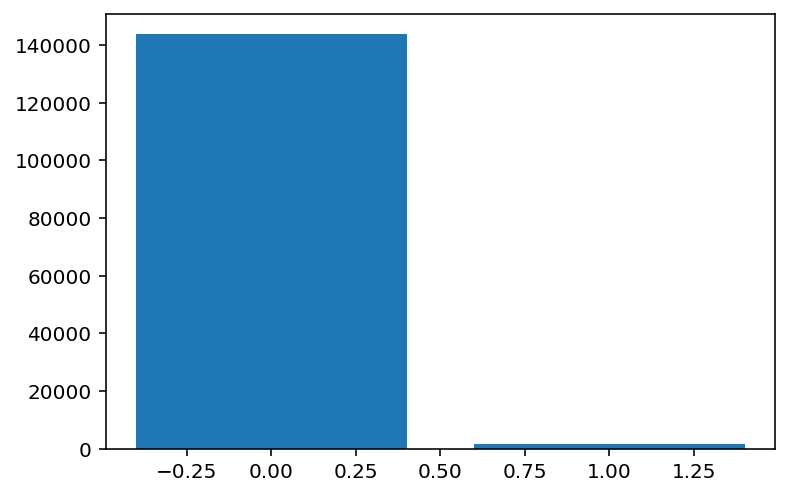

TITEL_KZ


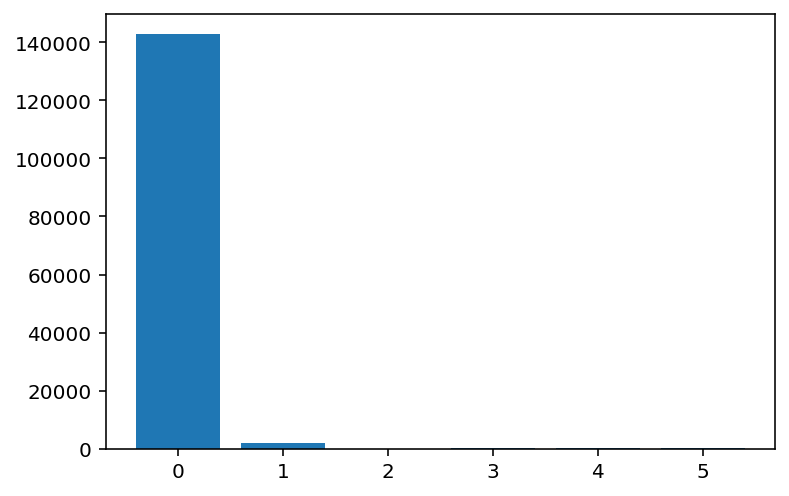

VERS_TYP


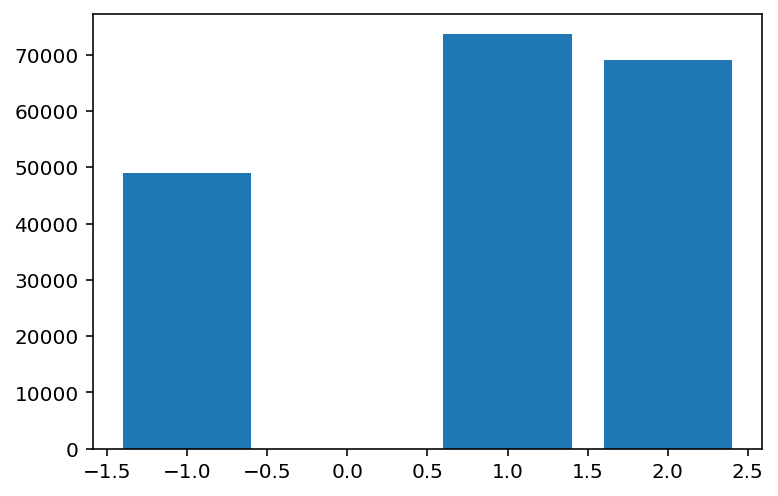

ZABEOTYP


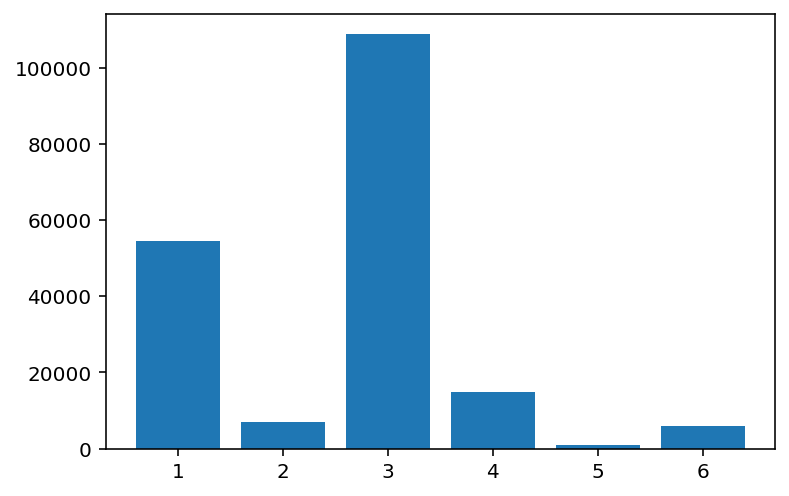

ALTER_HH


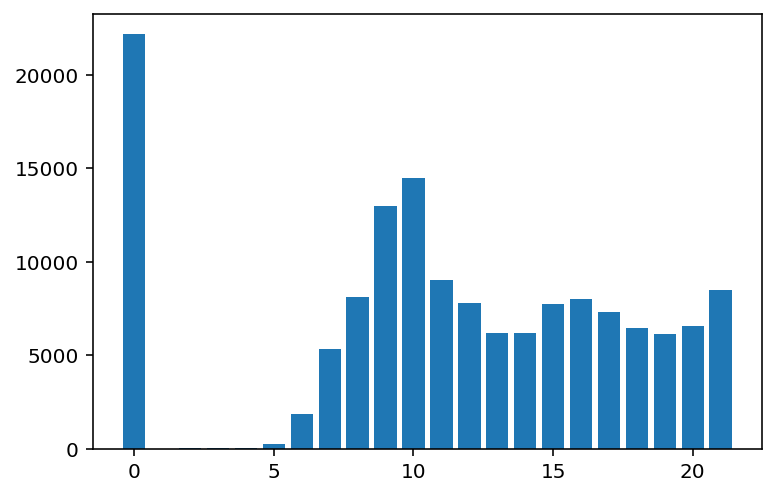

ANZ_PERSONEN


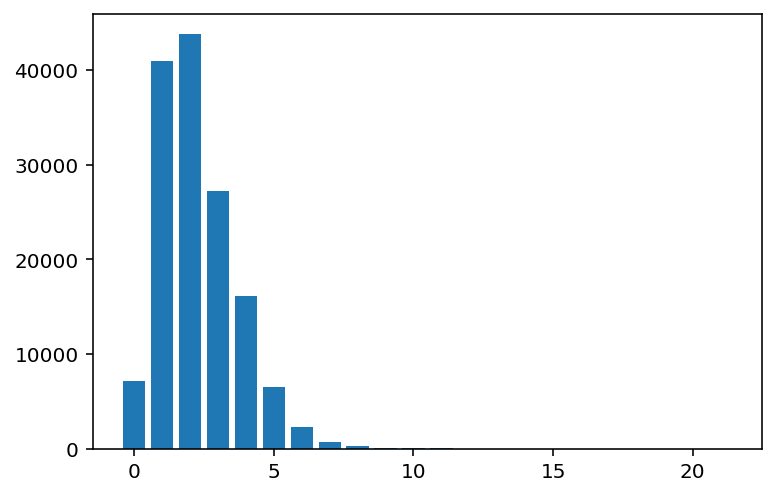

ANZ_TITEL


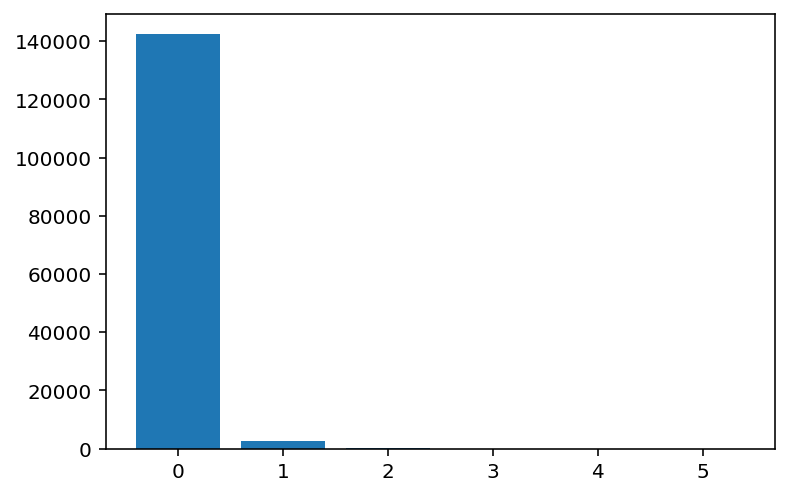

HH_EINKOMMEN_SCORE


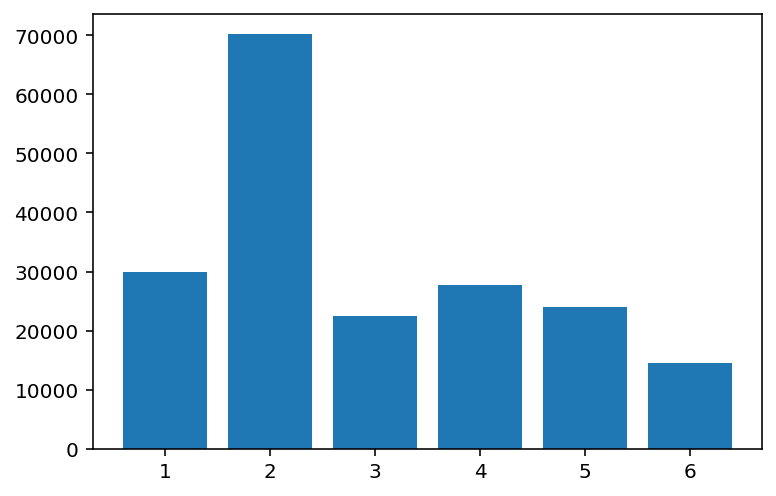

KK_KUNDENTYP


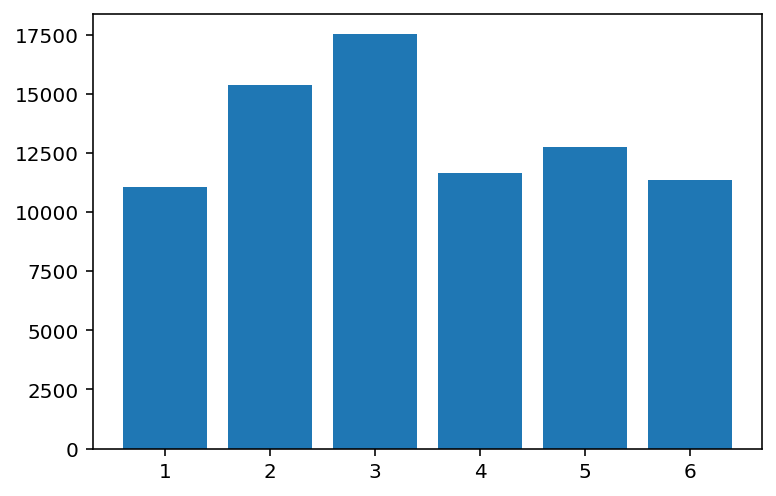

W_KEIT_KIND_HH


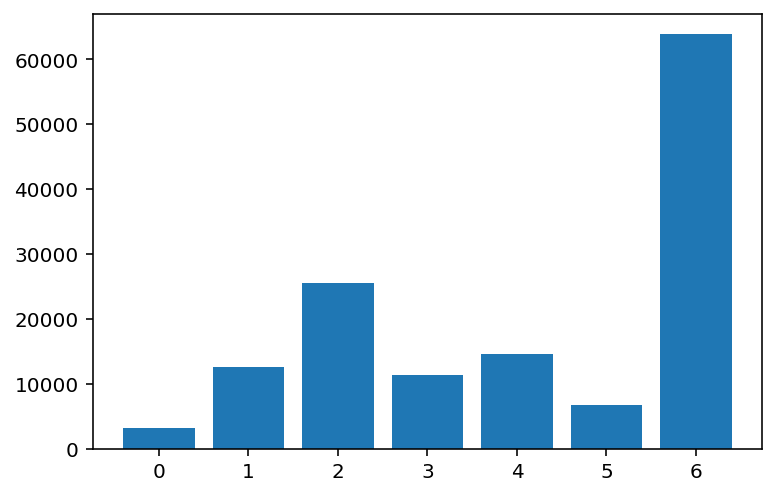

WOHNDAUER_2008


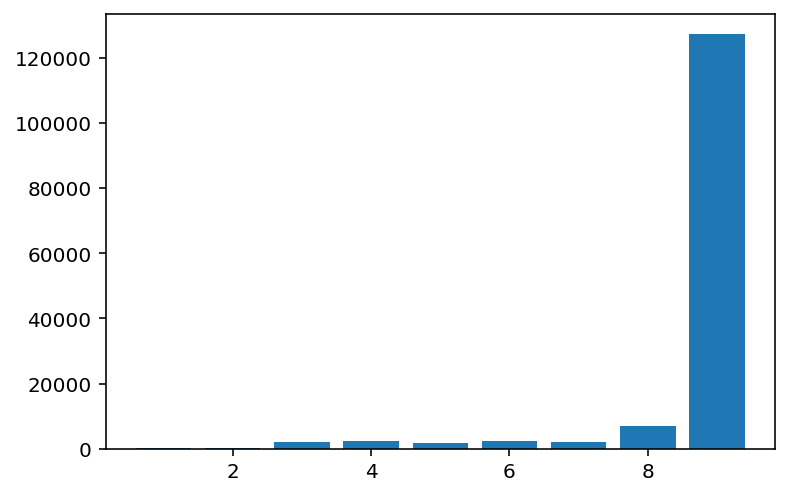

ANZ_HAUSHALTE_AKTIV


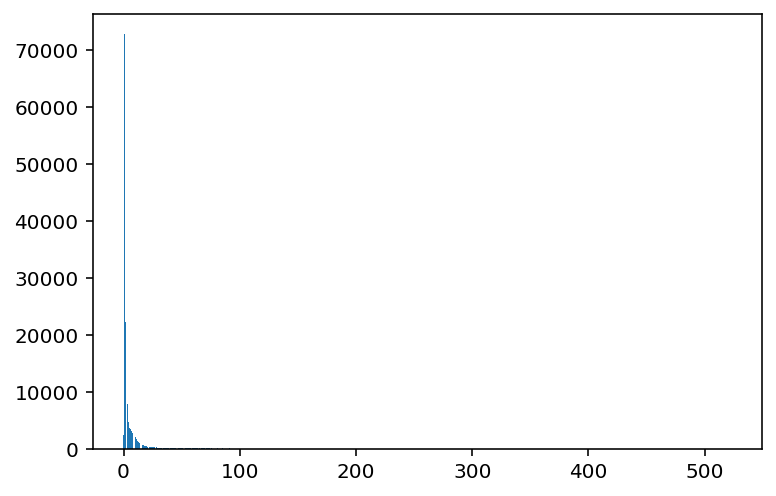

ANZ_HH_TITEL


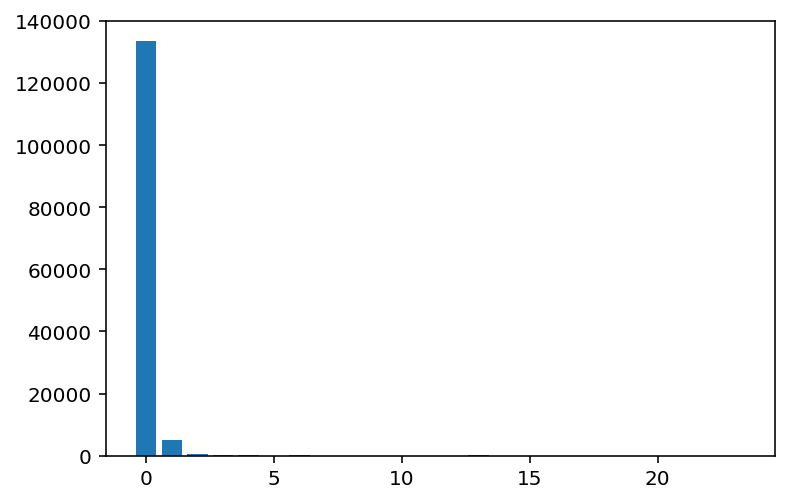

GEBAEUDETYP


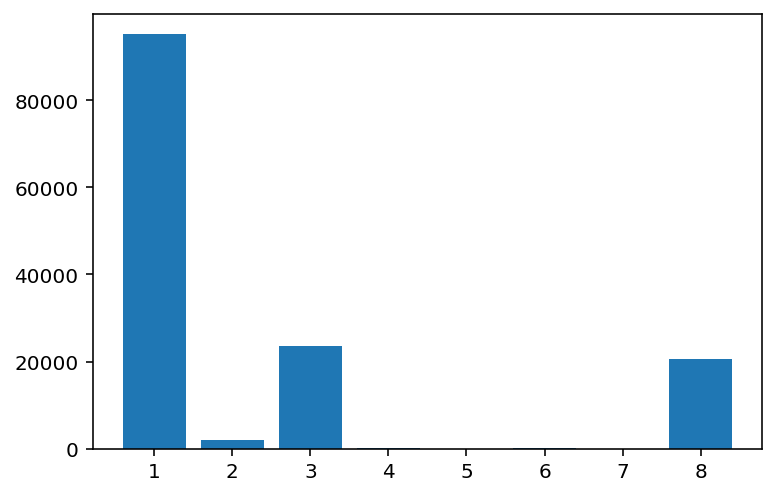

KONSUMNAEHE


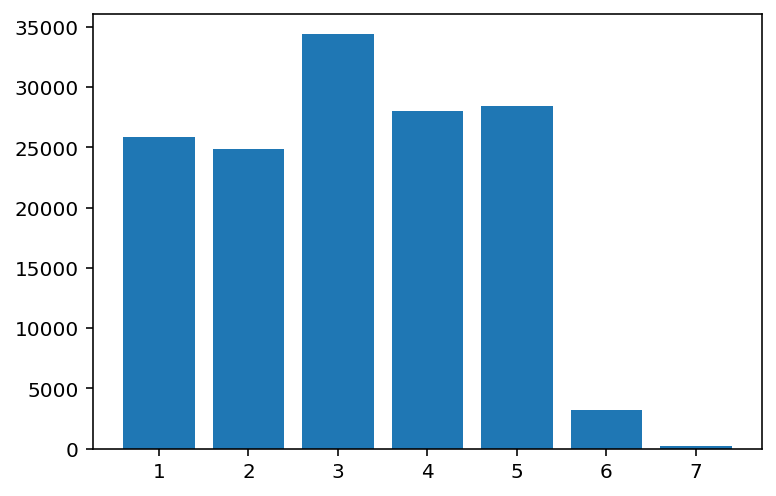

MIN_GEBAEUDEJAHR


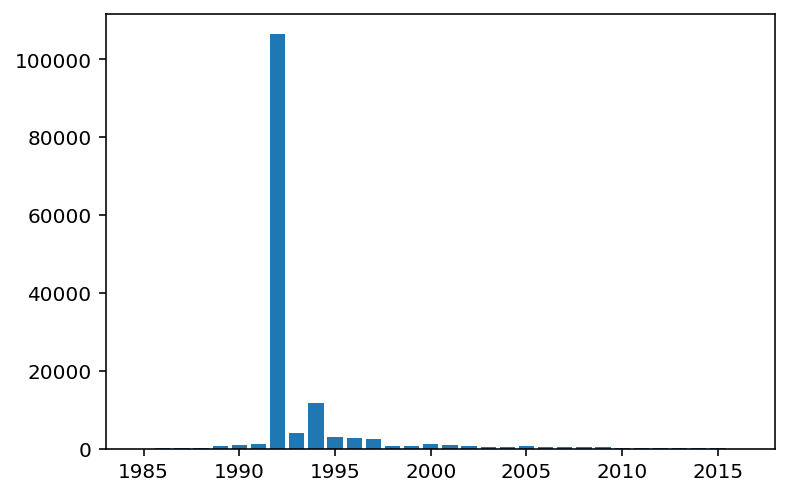

OST_WEST_KZ


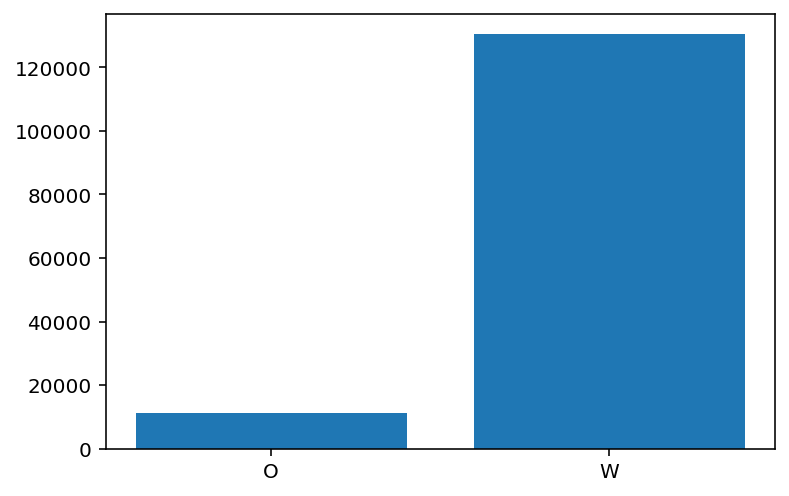

WOHNLAGE


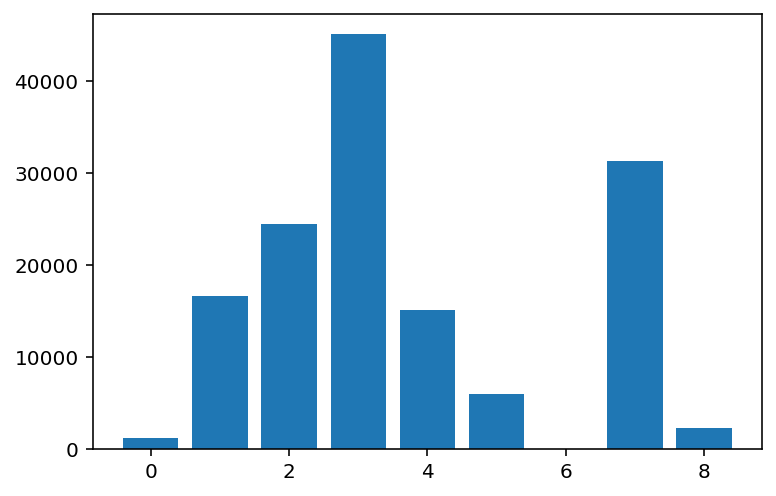

CAMEO_DEUG_2015


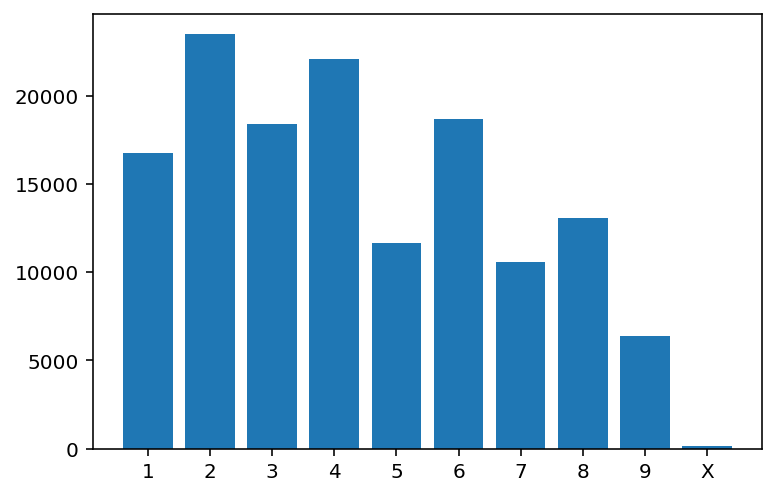

CAMEO_DEU_2015


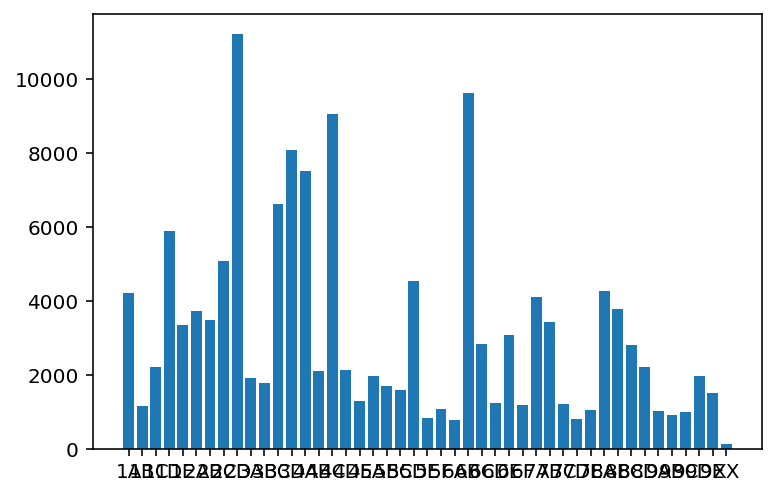

CAMEO_INTL_2015


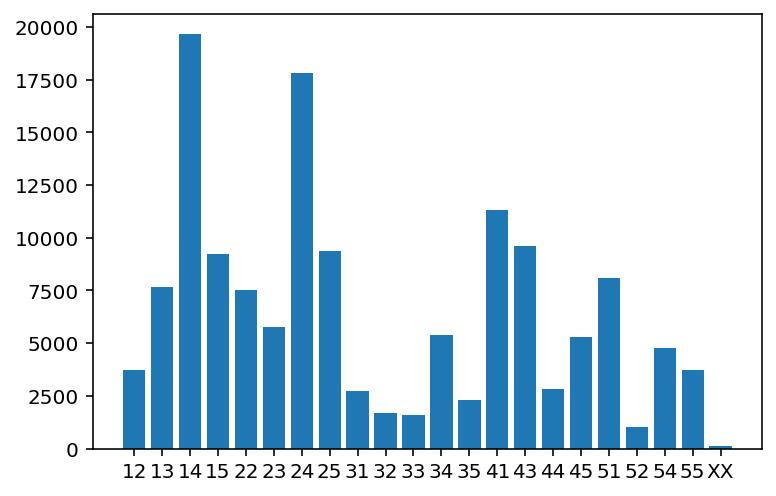

KBA05_ANTG1


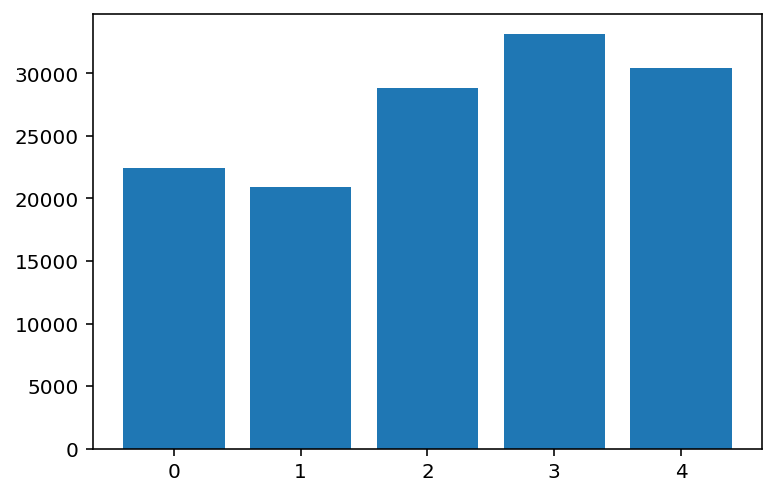

KBA05_ANTG2


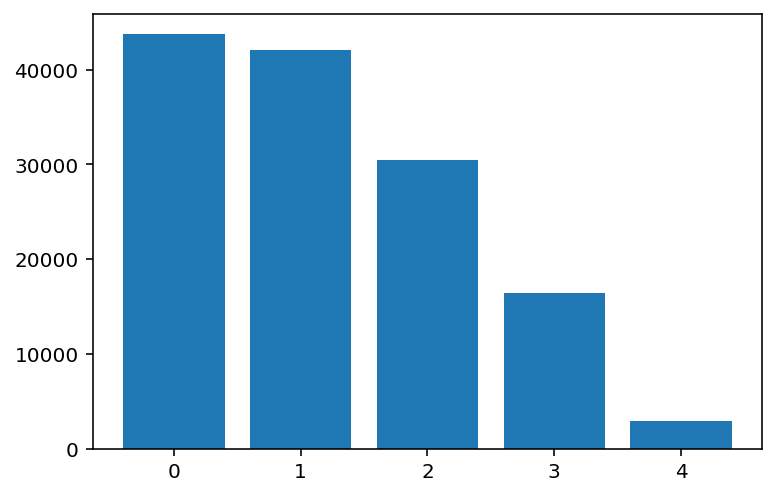

KBA05_ANTG3


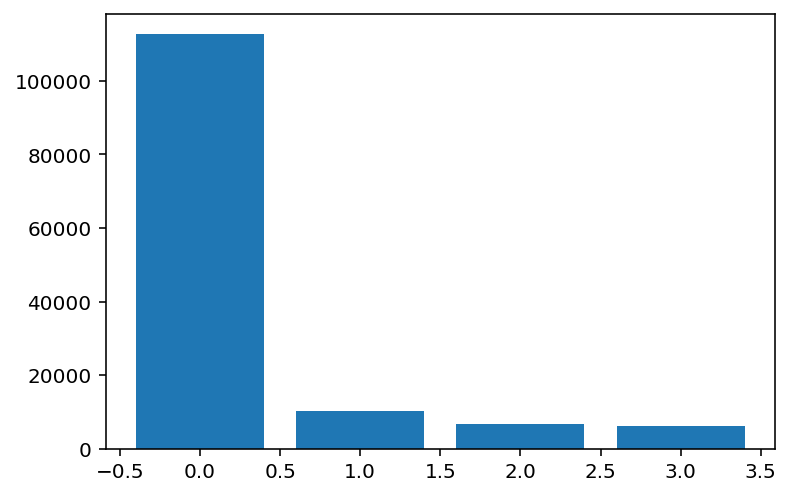

KBA05_ANTG4


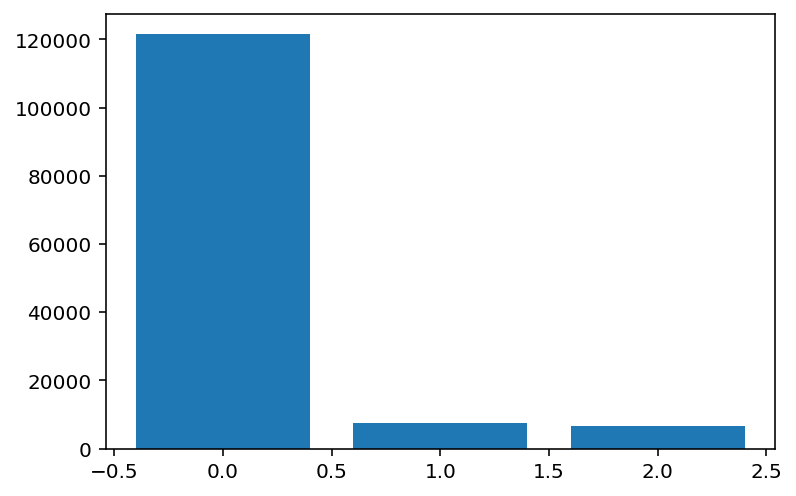

KBA05_BAUMAX


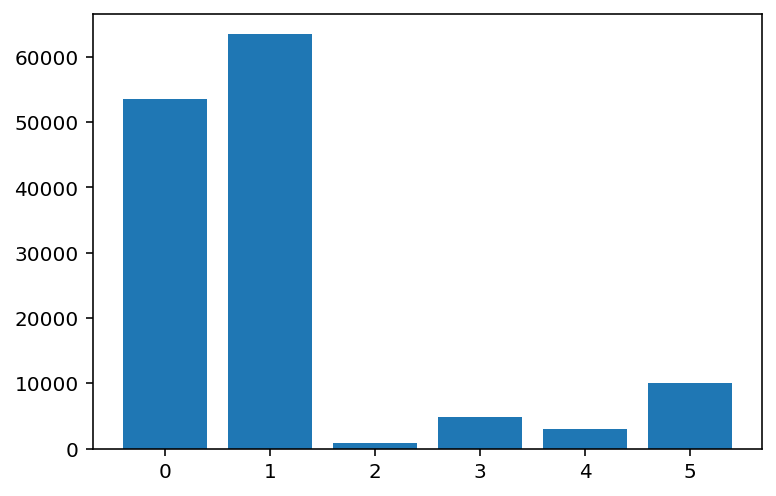

KBA05_GBZ


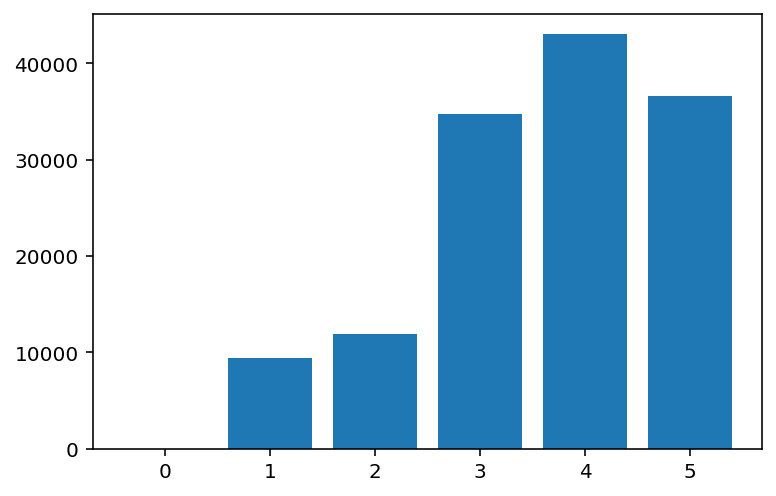

BALLRAUM


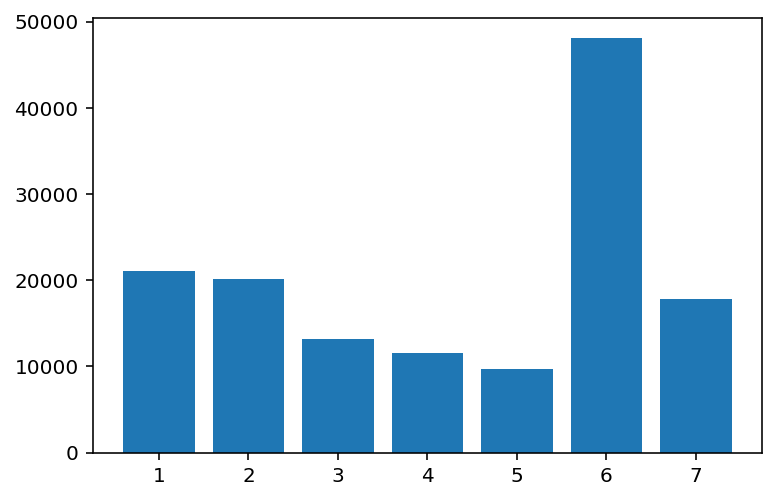

EWDICHTE


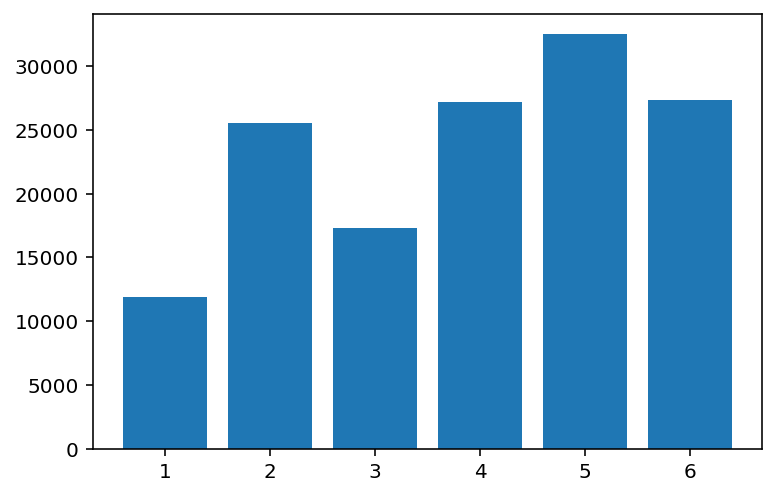

INNENSTADT


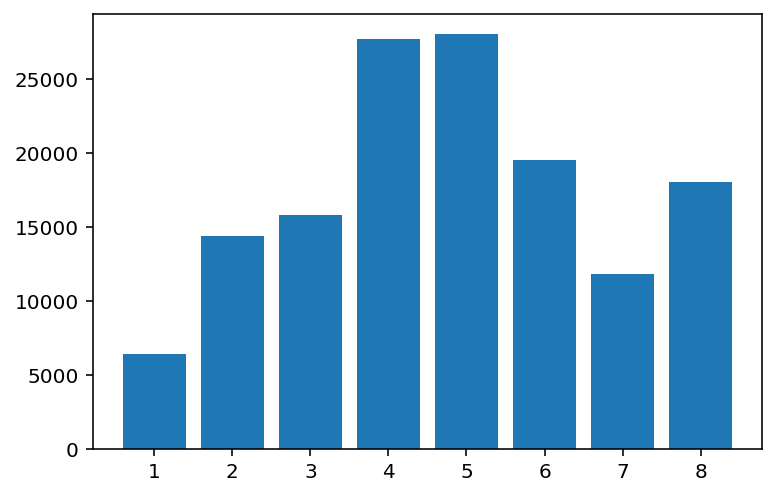

GEBAEUDETYP_RASTER


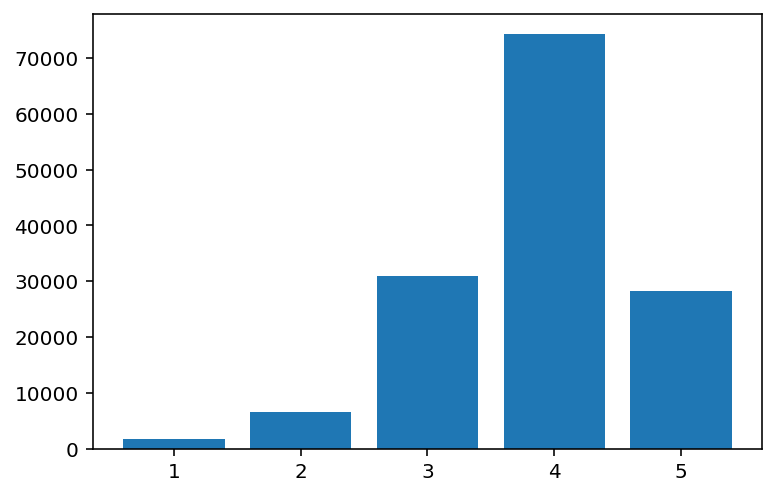

KKK


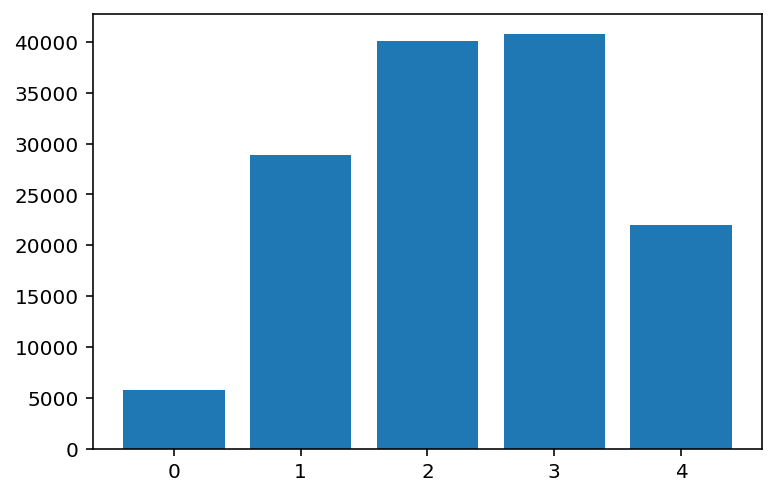

MOBI_REGIO


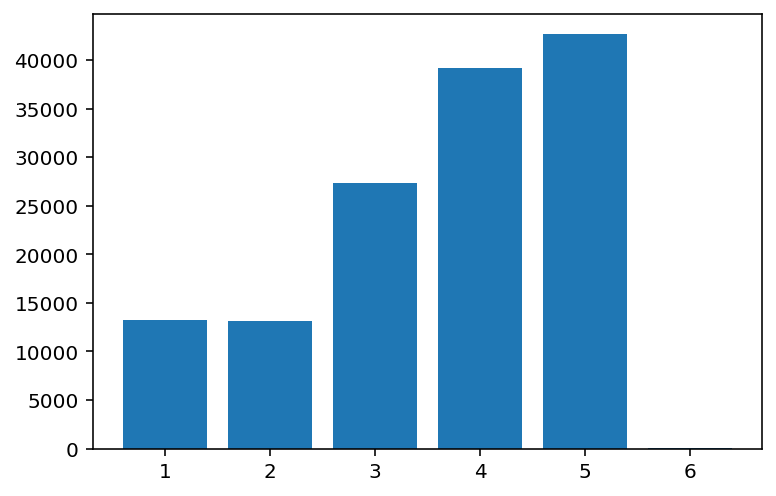

ONLINE_AFFINITAET


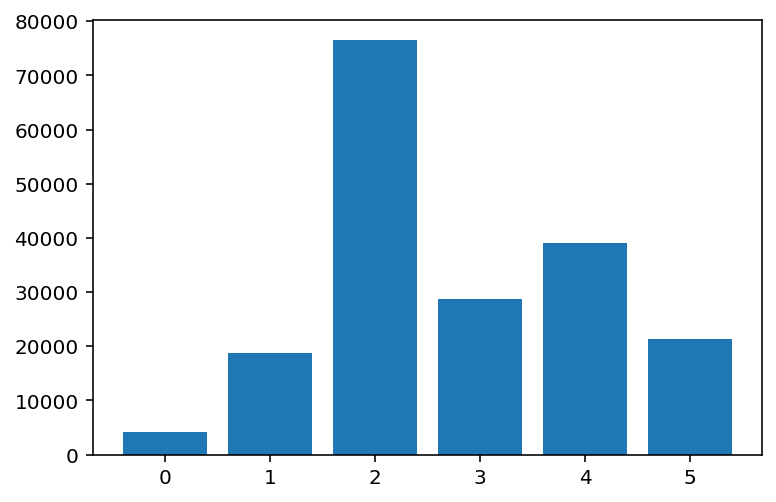

REGIOTYP


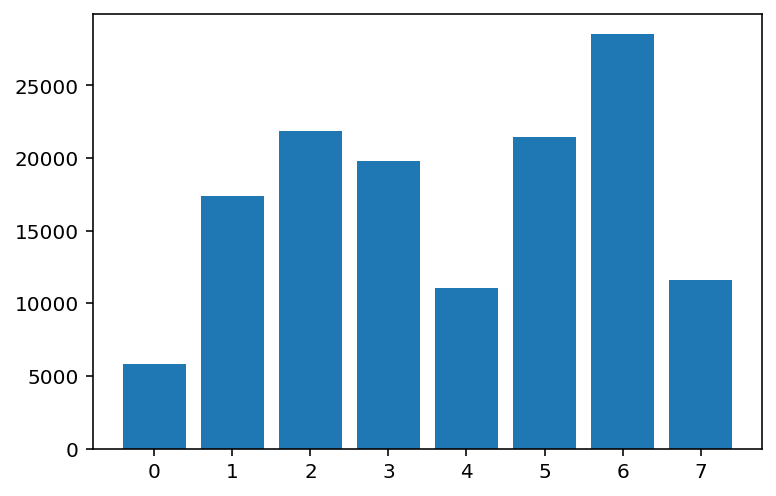

KBA13_ANZAHL_PKW


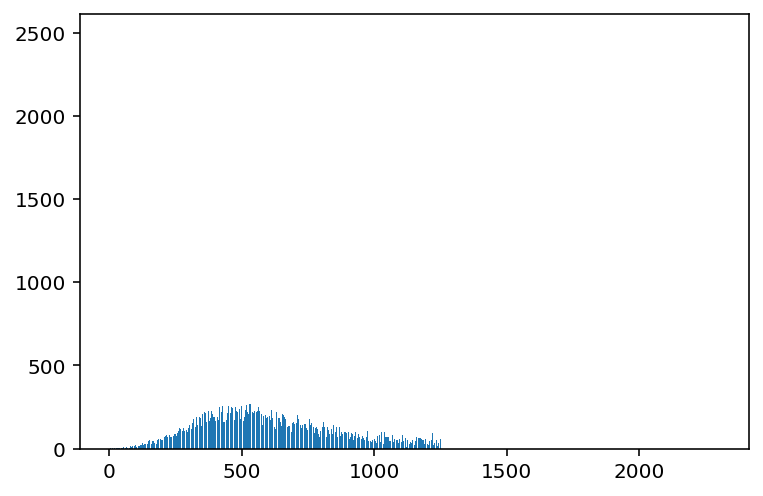

PLZ8_ANTG1


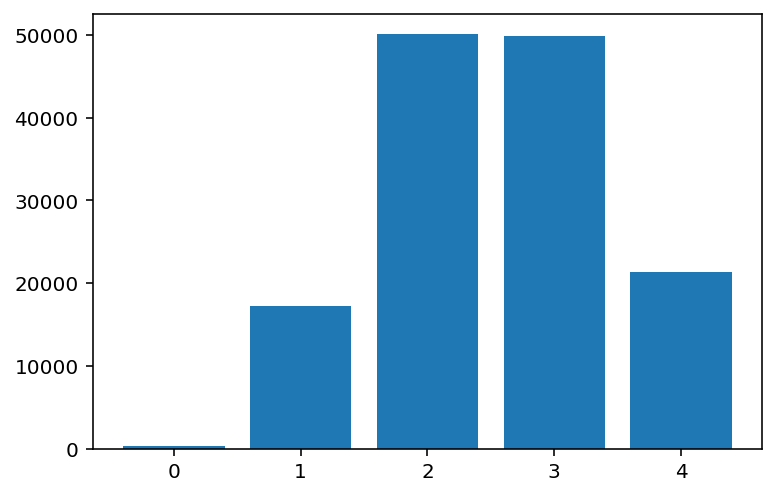

PLZ8_ANTG2


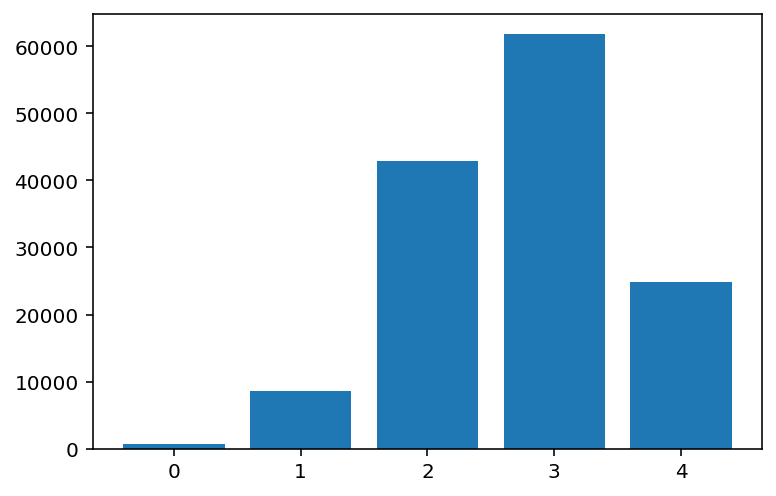

PLZ8_ANTG3


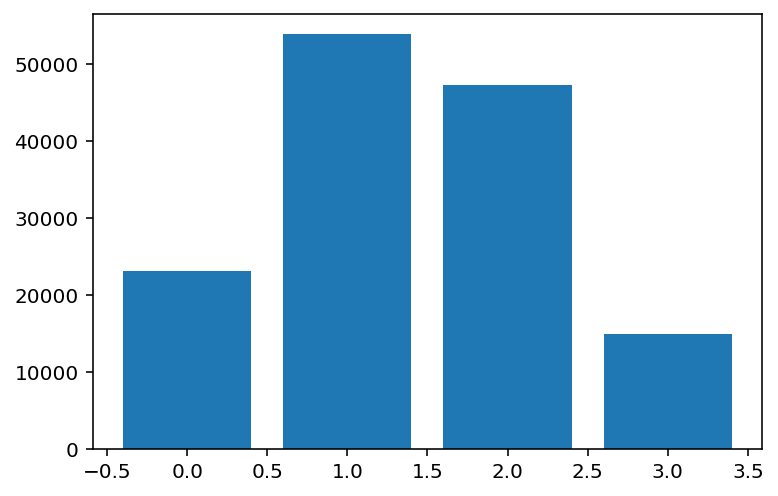

PLZ8_ANTG4


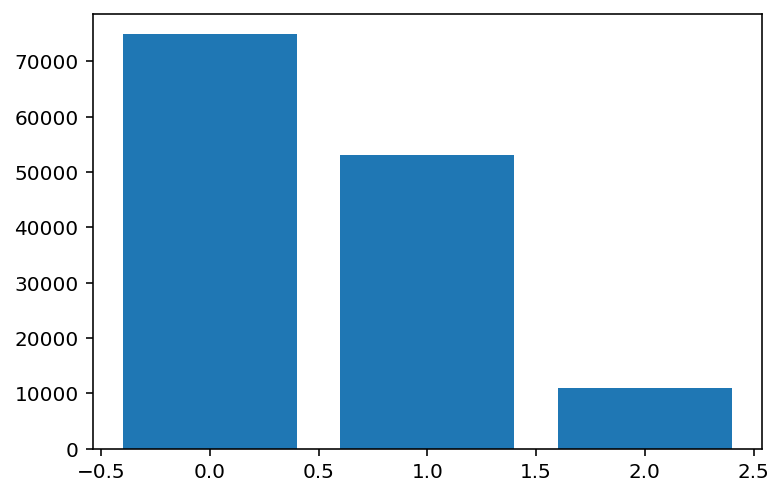

PLZ8_BAUMAX


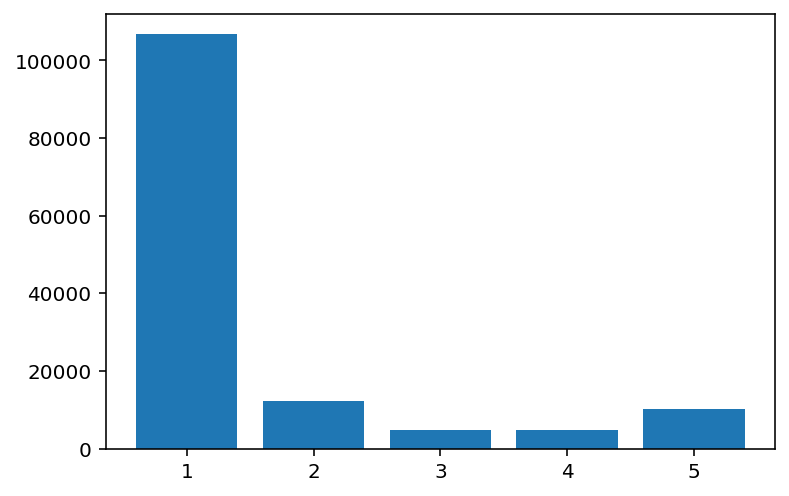

PLZ8_HHZ


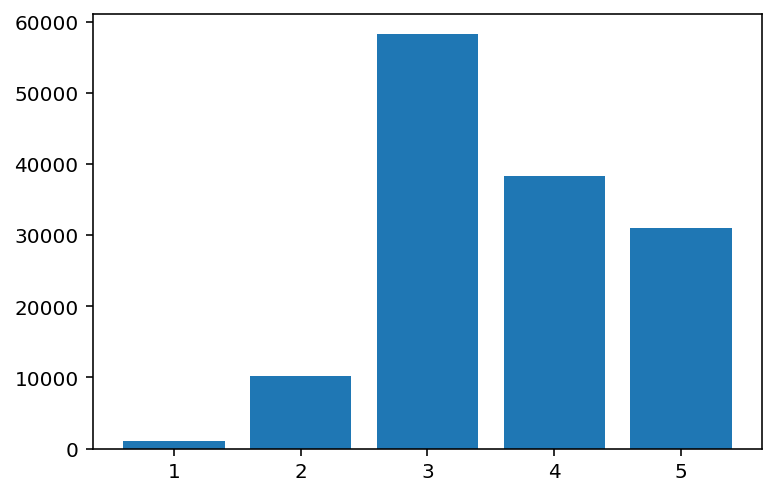

PLZ8_GBZ


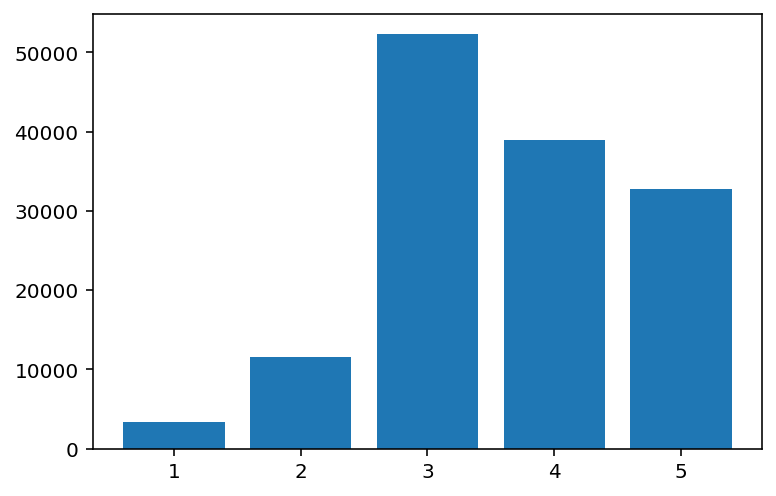

ARBEIT


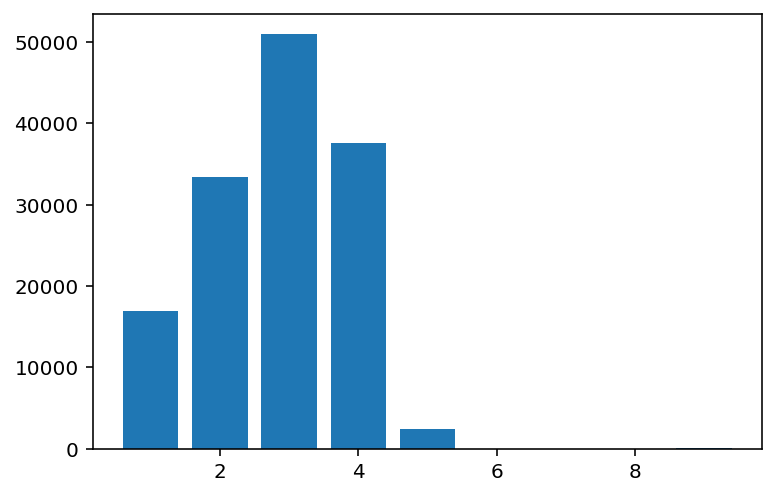

ORTSGR_KLS9


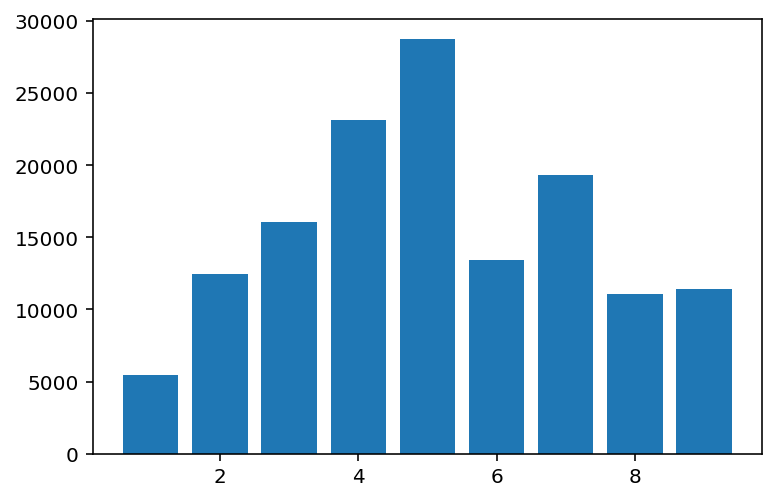

RELAT_AB


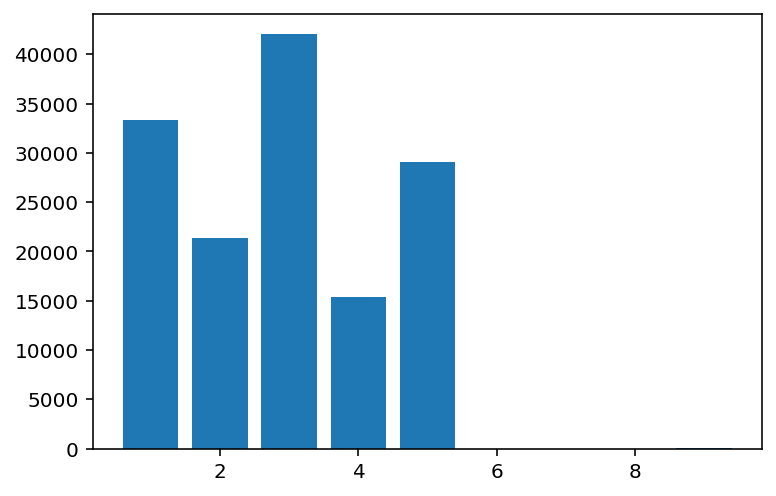

In [88]:
# General statistics about customers
for column in customers:
    print(column)
    plt.bar(customers[column].value_counts().sort_index().index,customers[column].value_counts().sort_index().values)
    plt.show()

In [89]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.


In [90]:
# clean and transform customers

df = customers

for i, column in enumerate(df):
    df[column] = df[column].replace(empty_values[i], np.nan)

# remove selected columns and rows, ...
for label in outliers_to_remove:
    df.drop([label], axis=1, inplace=True)

NaNs_row_series_demo = pd.Series(df.isnull().sum(axis=1))
df = df.dropna(thresh=df.shape[1]-threshold_rows)

for column in columns_remove_manually:
    df.drop([column], axis=1, inplace=True)

# select, re-encode, and engineer column values.
for column in categorical_columns_clean:
    just_dummies = pd.get_dummies(df[column])
    df = pd.concat([df, just_dummies], axis=1)      
    df = df.drop([column], axis=1)

In [92]:
# Fill nans wit mean

custom_filled = imp_mean.transform(df)

In [93]:
# Use standard scaler

scalerStd.transform(custom_filled)

array([[ 1.23317041,  1.45922035, -1.24461918, ..., -0.55540458,
        -0.32471909, -0.30178309],
       [ 1.23317041,  1.45922035, -1.24461918, ..., -0.55540458,
        -0.32471909, -0.30178309],
       [ 1.23317041,  1.45922035, -1.24461918, ..., -0.55540458,
        -0.32471909, -0.30178309],
       ...,
       [ 1.23317041,  1.45922035, -1.24461918, ..., -0.55540458,
        -0.32471909, -0.30178309],
       [ 0.24151835, -0.81223674, -1.24461918, ..., -0.55540458,
        -0.32471909, -0.30178309],
       [-0.7501337 ,  1.45922035, -1.24461918, ..., -0.55540458,
        -0.32471909, -0.30178309]])

In [95]:
# perform PCA

custom_pca = pca.transform(custom_filled)

In [96]:
# Apply min/max scaler

custom_scaled = scalerMinMax.transform(custom_pca)

In [97]:
# predict customers

custom_pred = kmeans.predict(custom_scaled)

In [98]:
# display number of customers per cluster

custom_pred_df = pd.DataFrame(custom_pred)
custom_pred_df[0].value_counts()

1     46658
3     31522
17    23560
10    19443
11    12898
2     12352
6     12076
4      5895
5      5326
9      3164
19     3060
18     2942
14     1782
16     1621
15     1610
0      1097
7      1091
8       876
12      770
13      696
Name: 0, dtype: int64

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [99]:
# generate dataframs from value_counts for general population and customers

general_pred_stats_df = pd.DataFrame(general_pred[0].value_counts()*100/len(general_pred[0]))
custom_pred_stats_df = pd.DataFrame(custom_pred_df[0].value_counts()*100/len(custom_pred_df[0]))

In [101]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# compare clusters of both datasets

all_results = pd.concat([general_pred_stats_df, custom_pred_stats_df], axis=1)
all_results.columns = ['general', 'custom']
all_results['diff'] = all_results['custom']-all_results['general']
all_results

,general,custom,diff
0,6.412581,0.582151,-5.830430
1,8.636490,24.760267,16.123777
2,7.940729,6.554906,-1.385822
3,4.292579,16.727960,12.435381
4,5.156442,3.128333,-2.028109
5,2.821292,2.826379,0.005087
6,4.742731,6.408440,1.665709
7,3.121845,0.578967,-2.542877
8,4.589521,0.464872,-4.124649
9,5.511374,1.679058,-3.832316


In [103]:
# get customer data for people in cluster 2

index_cluster_target = custom_pred_df[custom_pred_df[0] == 3].index
class_target = customers.iloc[index_cluster_target]
class_target.shape

(31522, 32)

ALTERSKATEGORIE_GROB


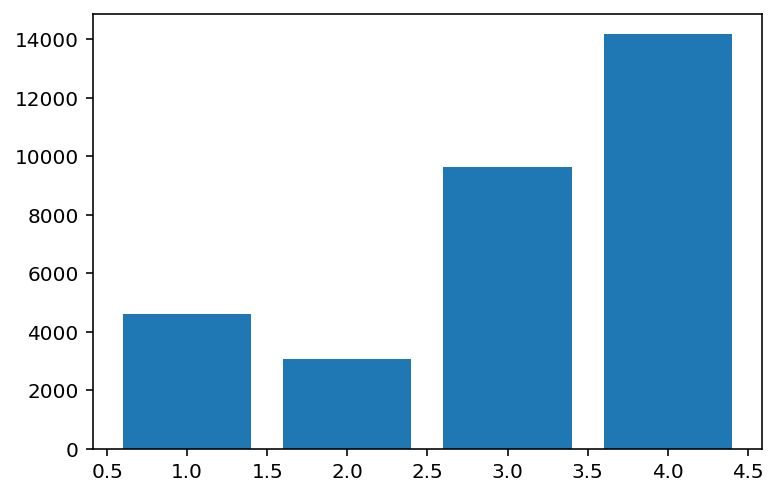

ANREDE_KZ


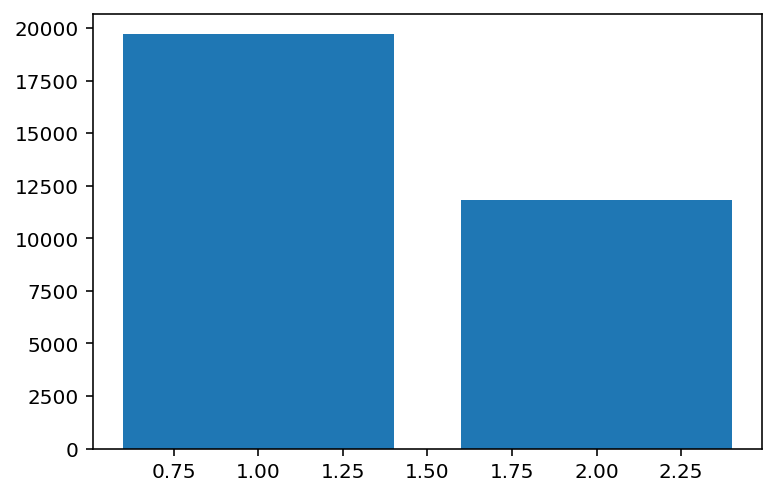

CJT_GESAMTTYP


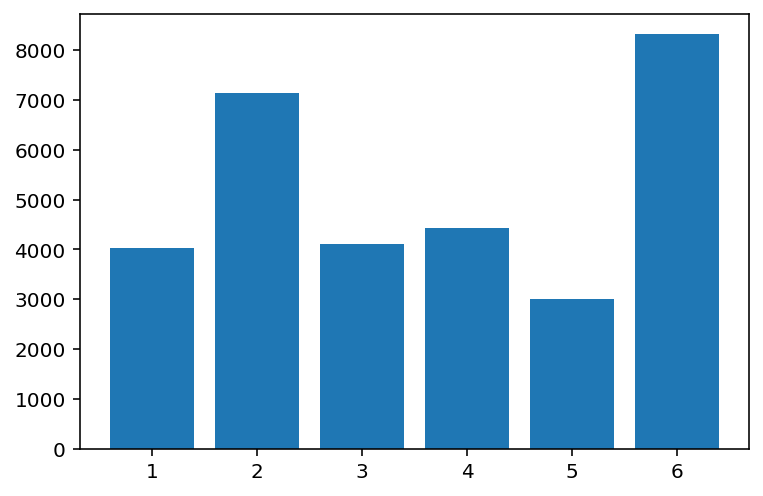

FINANZ_MINIMALIST


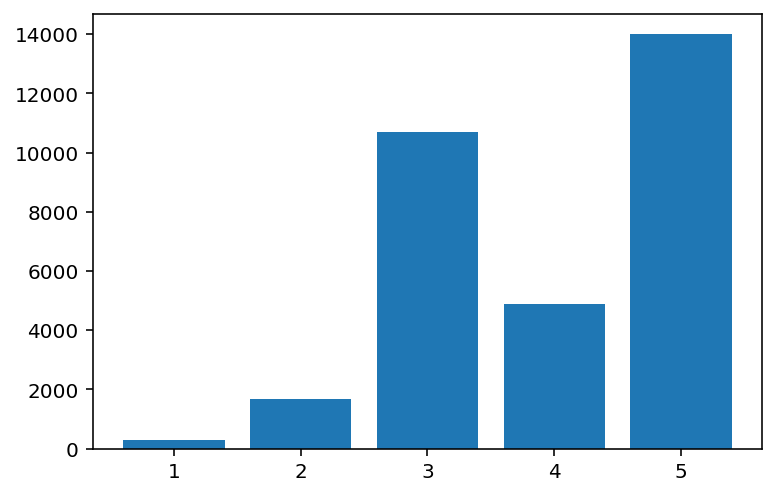

FINANZ_SPARER


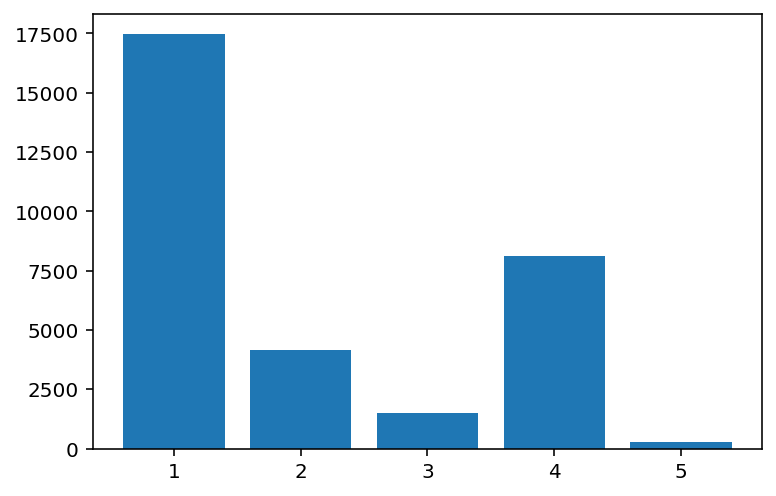

FINANZ_VORSORGER


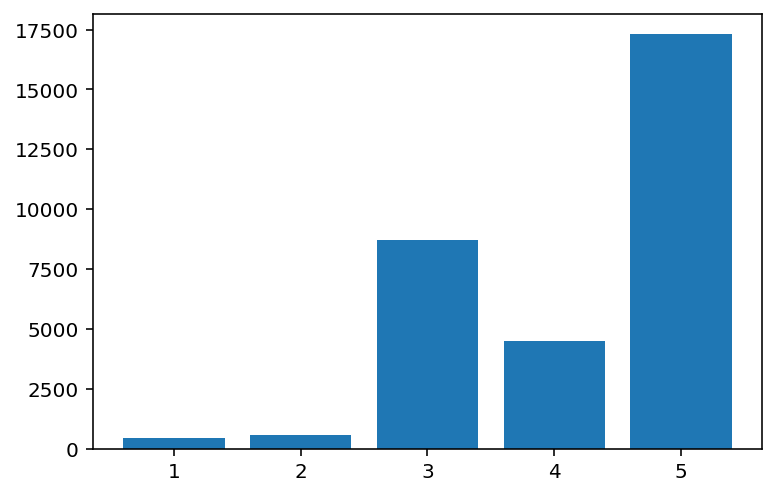

FINANZ_ANLEGER


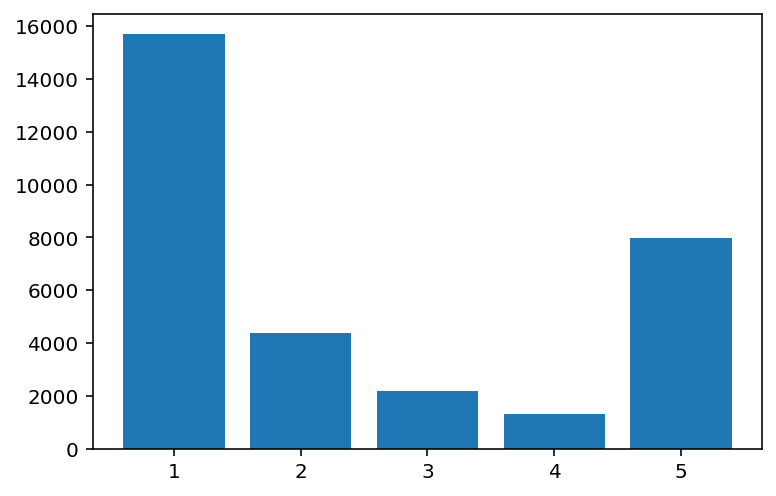

FINANZ_UNAUFFAELLIGER


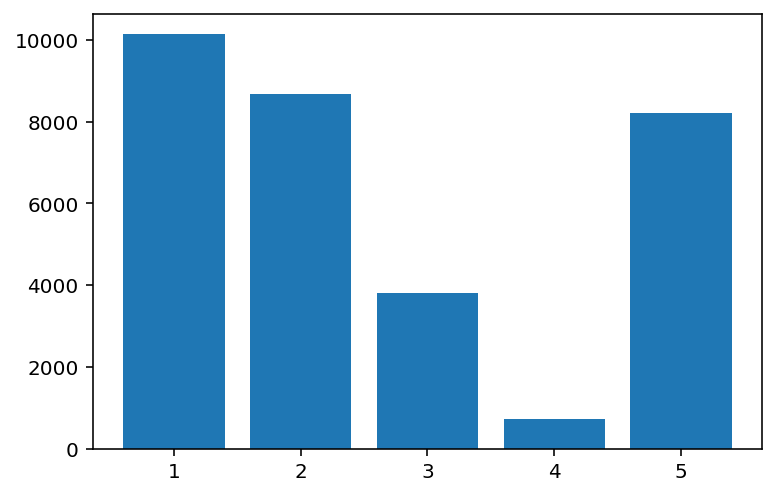

FINANZ_HAUSBAUER


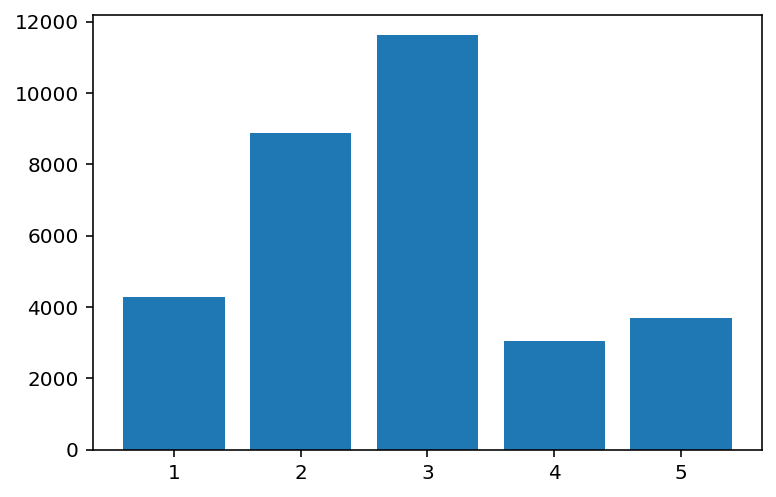

FINANZTYP


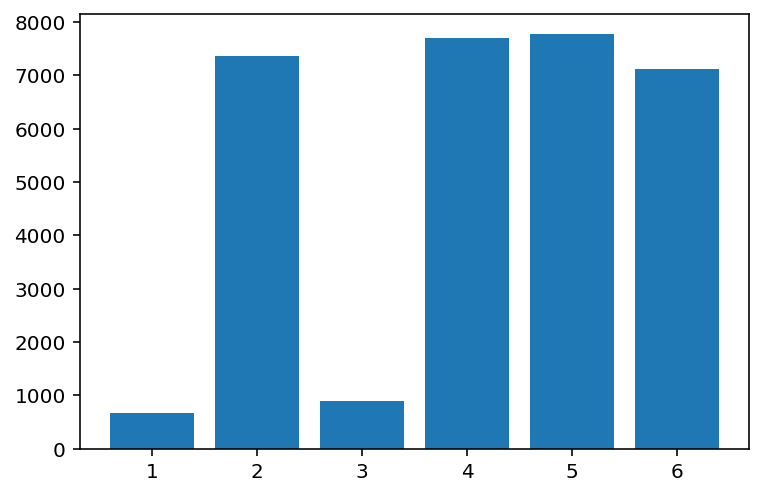

GFK_URLAUBERTYP


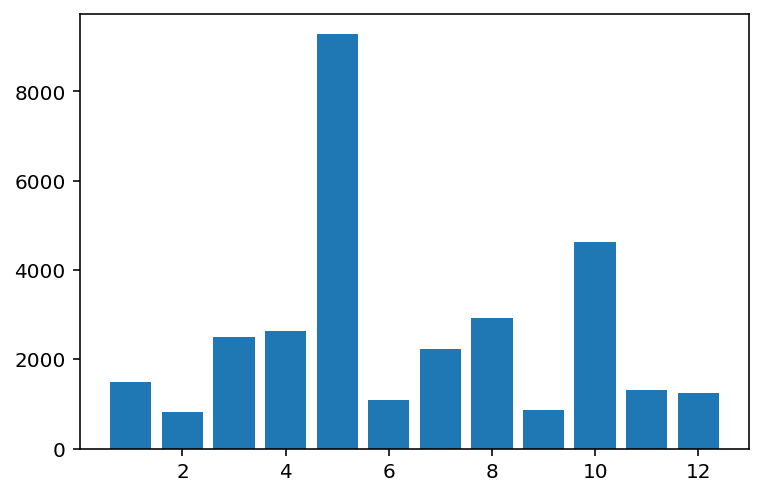

GREEN_AVANTGARDE


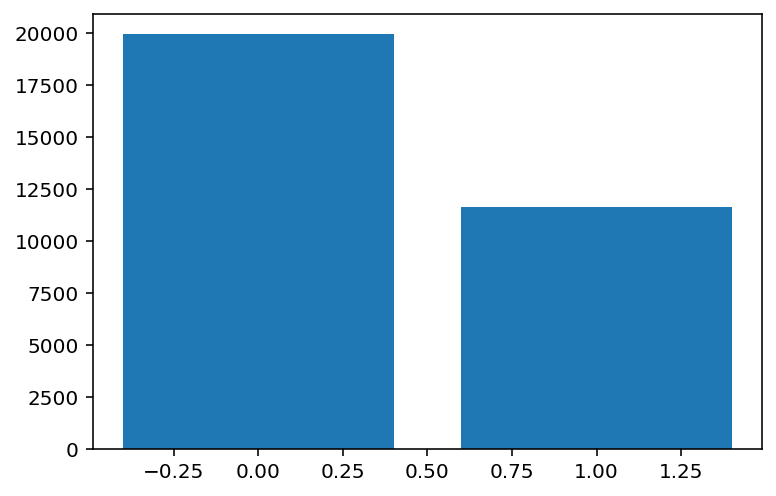

LP_STATUS_FEIN


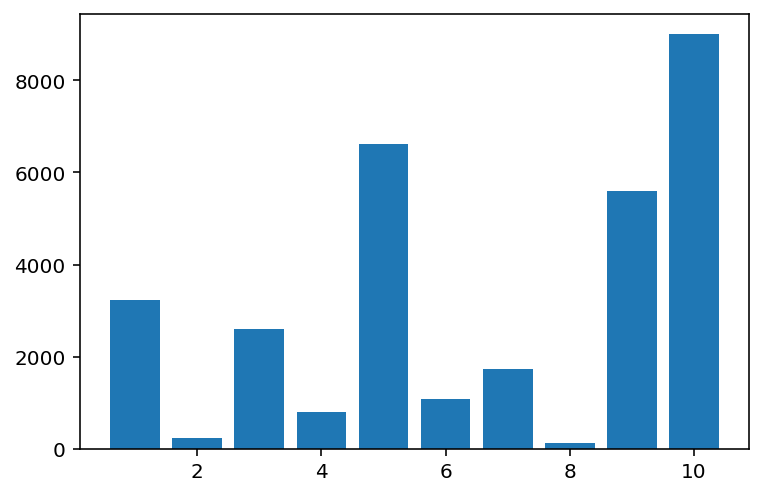

LP_STATUS_GROB


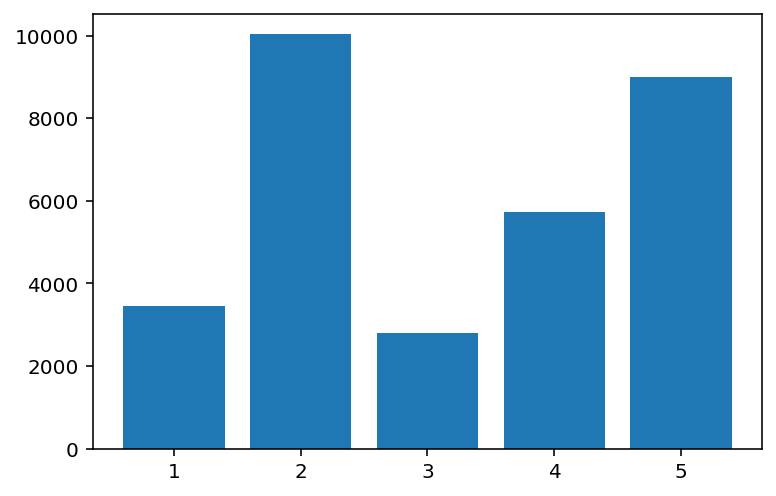

RETOURTYP_BK_S


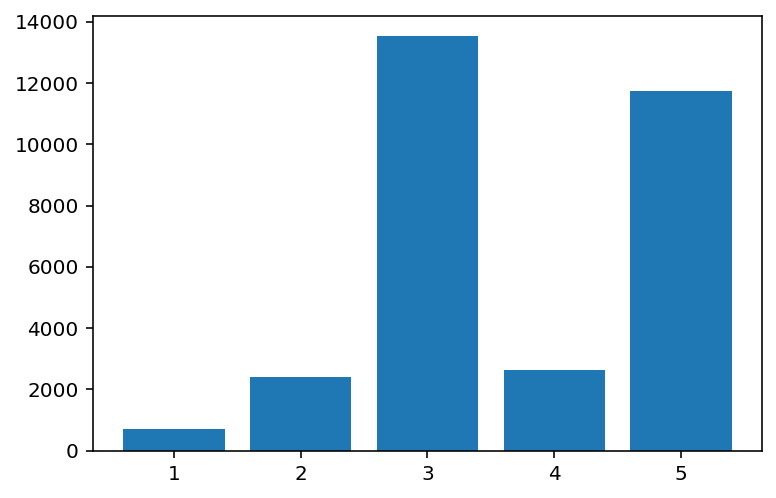

SEMIO_SOZ


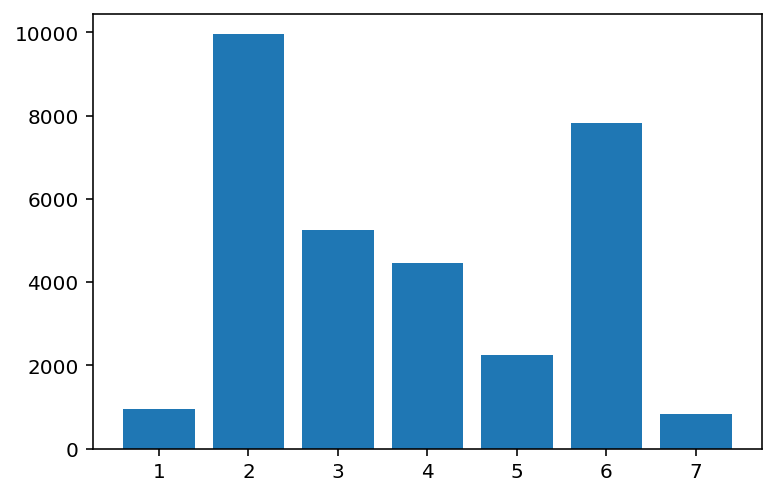

SEMIO_FAM


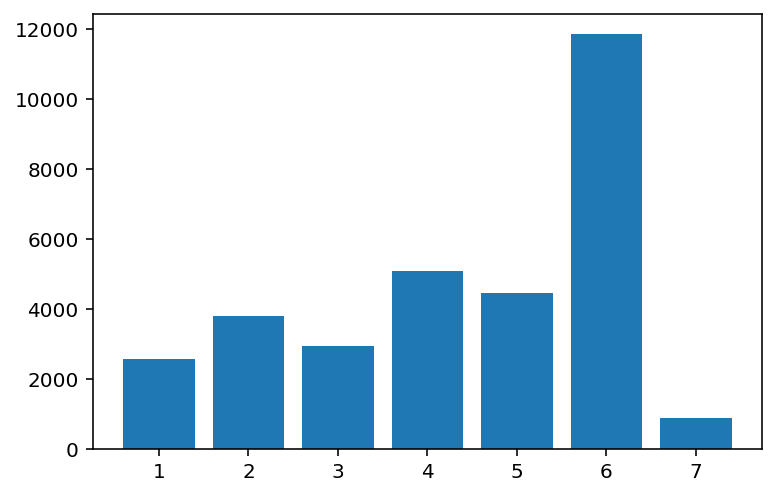

SEMIO_REL


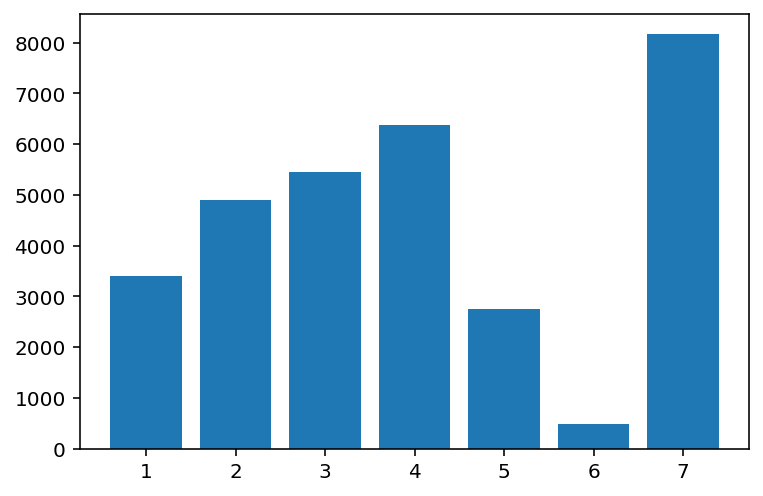

SEMIO_MAT


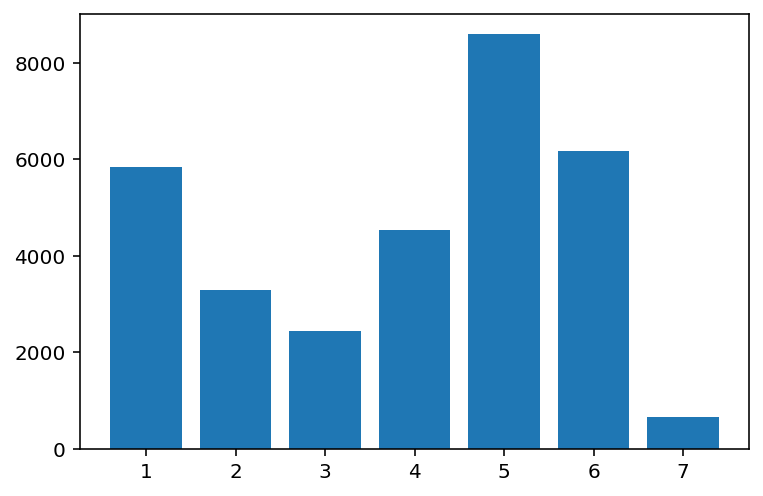

SEMIO_VERT


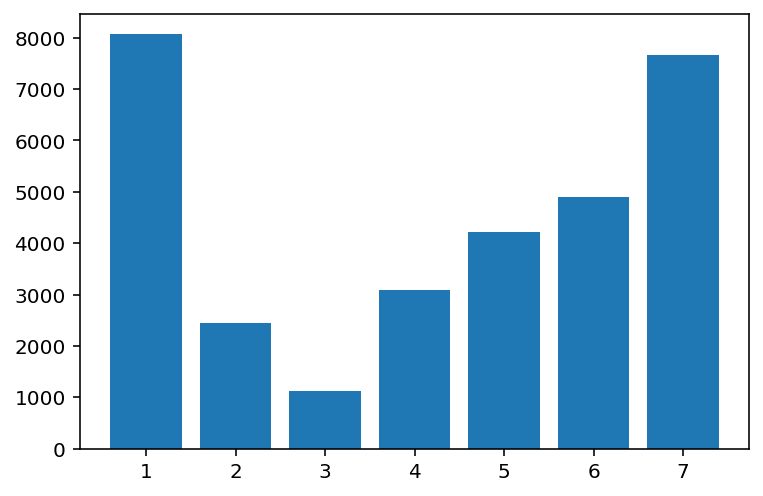

SEMIO_LUST


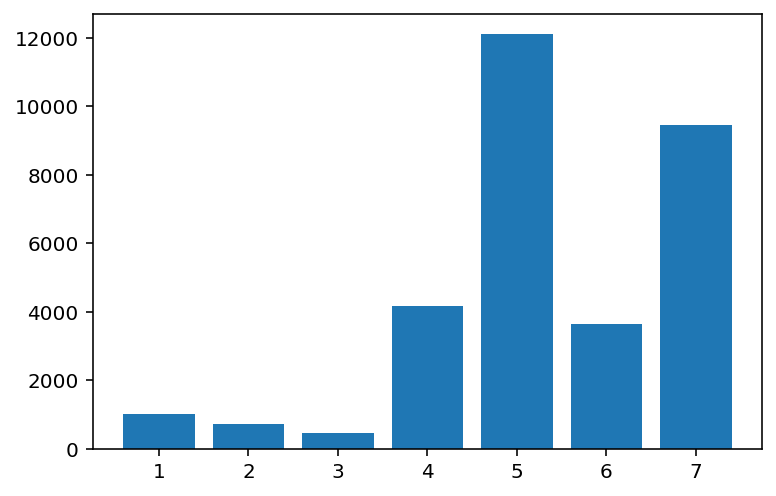

SEMIO_ERL


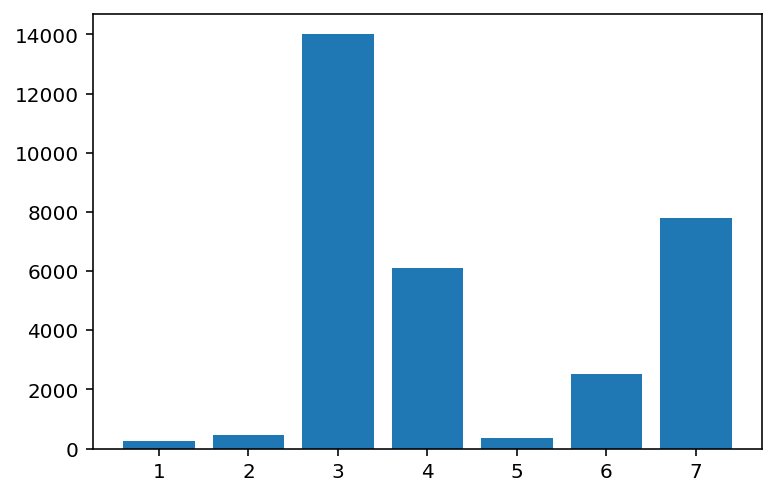

SEMIO_KULT


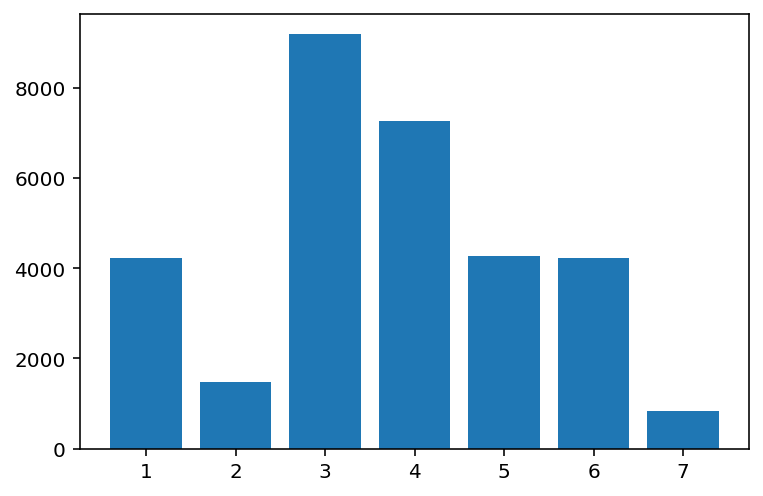

SEMIO_RAT


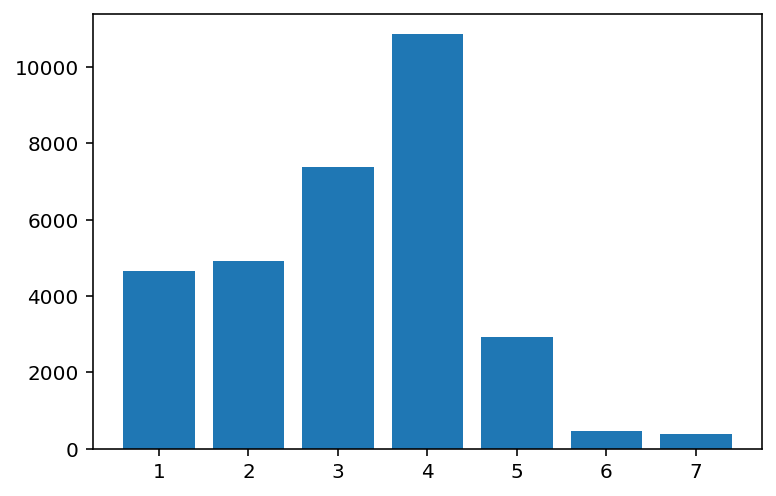

SEMIO_KRIT


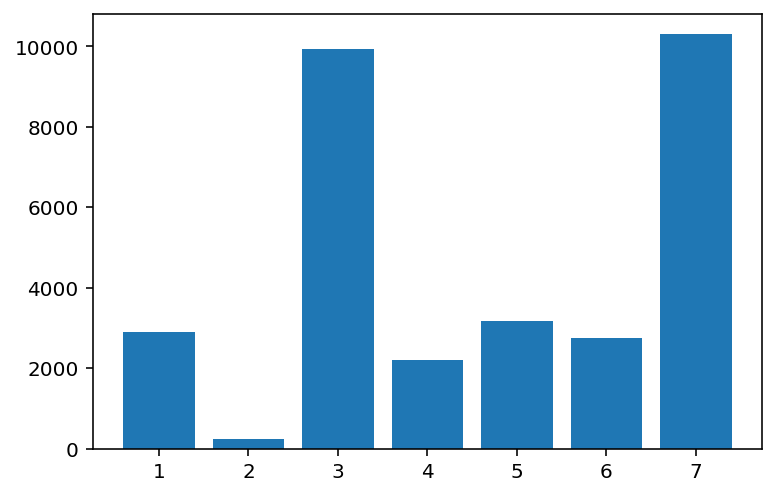

SEMIO_DOM


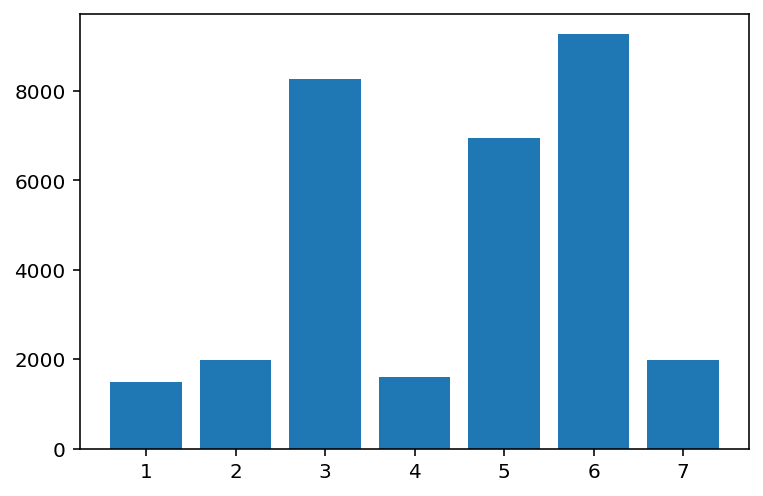

SEMIO_KAEM


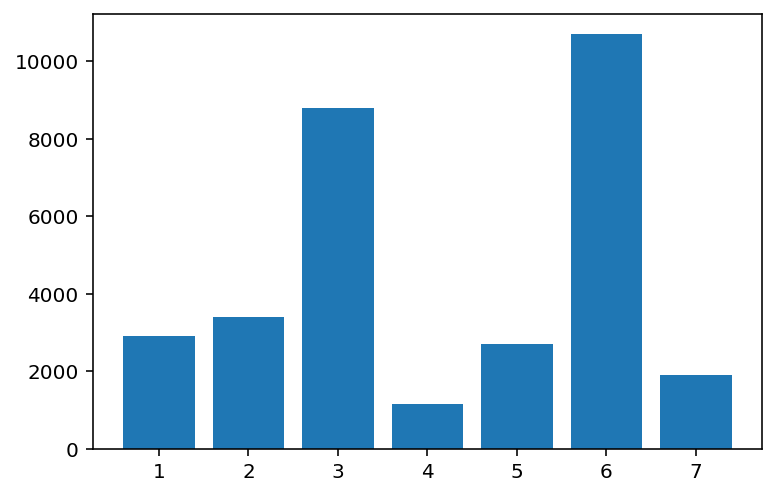

SEMIO_PFLICHT


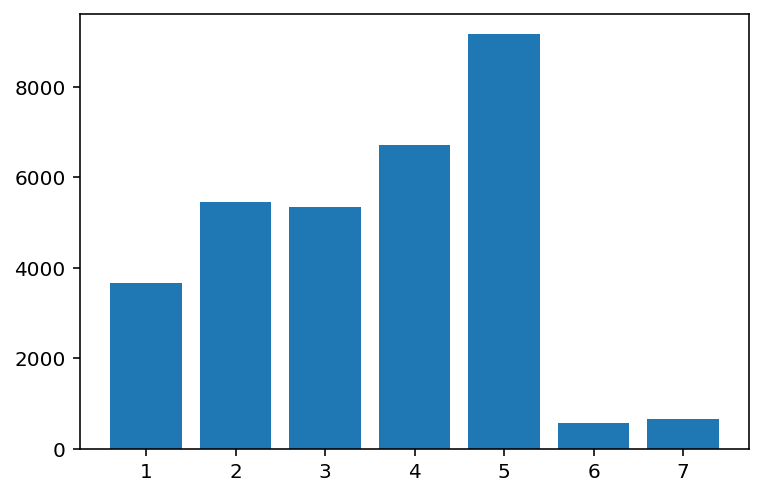

SEMIO_TRADV


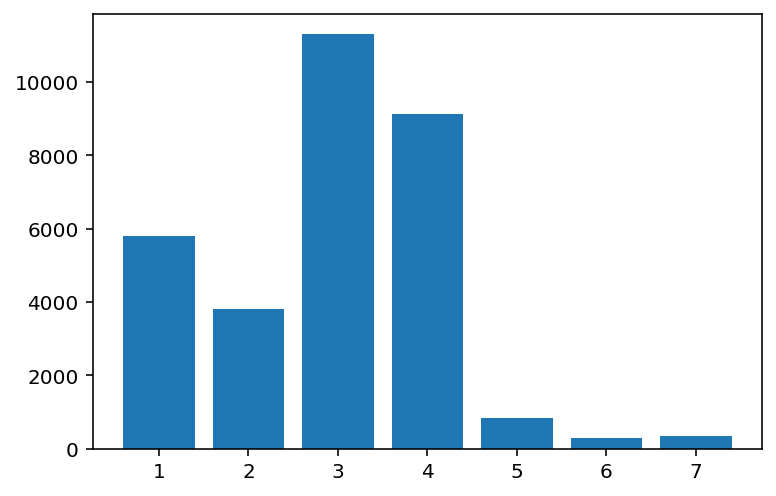

ZABEOTYP


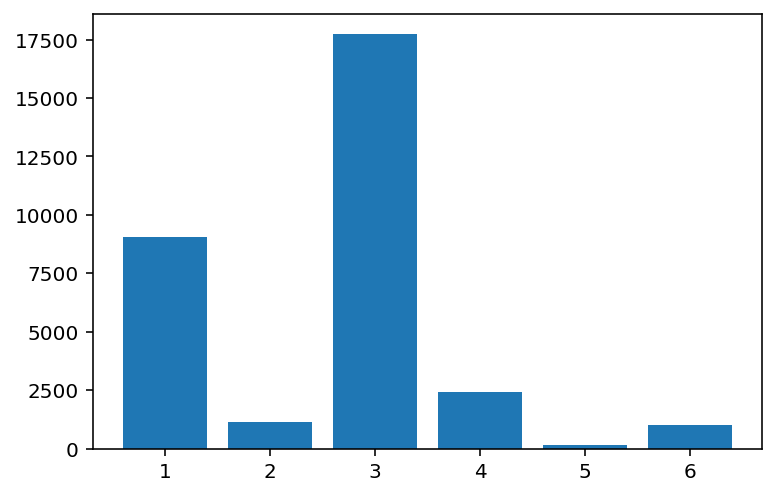

HH_EINKOMMEN_SCORE


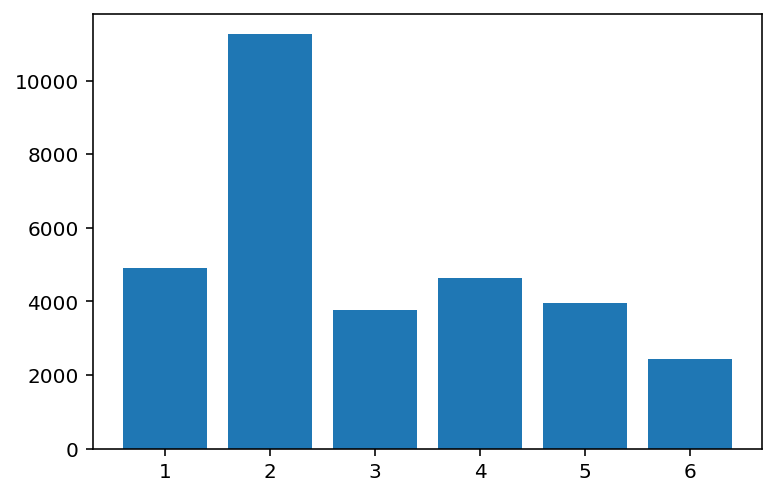

ONLINE_AFFINITAET


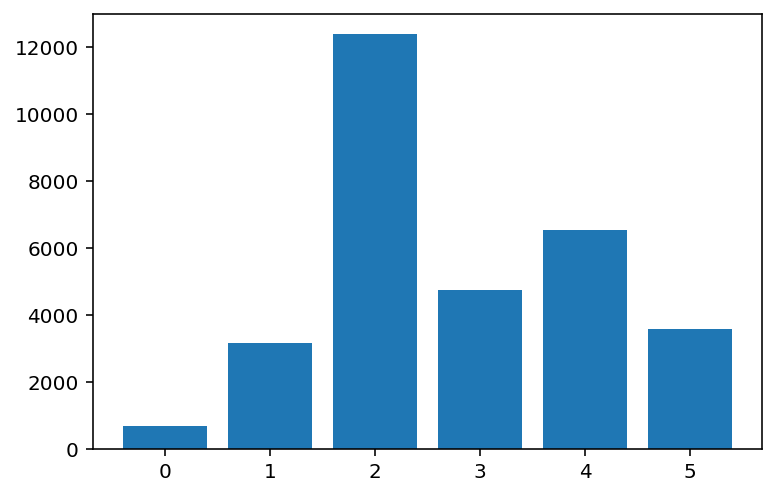

In [104]:
# plot statistics about those people

for column in class_target:
    print(column)
    plt.bar(class_target[column].value_counts().sort_index().index,class_target[column].value_counts().sort_index().values)
    plt.show()

##### What kinds of people are part of a cluster that is overrepresented in the
##### customer data compared to the general population?

* Mainly people over 45, with a slight tendency to being male.
* People with money (saver, investor, precautious, inconspicuous).
* High tendency to beeing Nature fans and smaller tendency to liking art.
* People of higher age, with a strong tendency of beeing high-income earner
* Strong tendency of beeing minimalistic
* Many beeing houseowners
* Slight tendency of being dutyful
* Tendency of being traditional-minded (<--there is a type in the Data_Dictionary.md [tradional])
* Sustainability is important
* Households between 1 and 4 people
* Tendency of not having children in household (I assume that in their higher age, the children moved out already, as the data also shows, that there is a tendency of having children)
* Stable living situation, most people didn't move in the last 10 years (or longer)
* Strong tendency of living in a residential building
* Very strong tendency of being former Western-Germany citizen
* Good to average neighborhood in cities or rural neighborhood
* Online affinity is average to high

In [108]:
# get people from class 0

index_cluster_non_target = custom_pred_df[custom_pred_df[0] == 8].index
class_non_target = customers.iloc[index_cluster_non_target]
class_non_target.shape

(876, 32)

ALTERSKATEGORIE_GROB


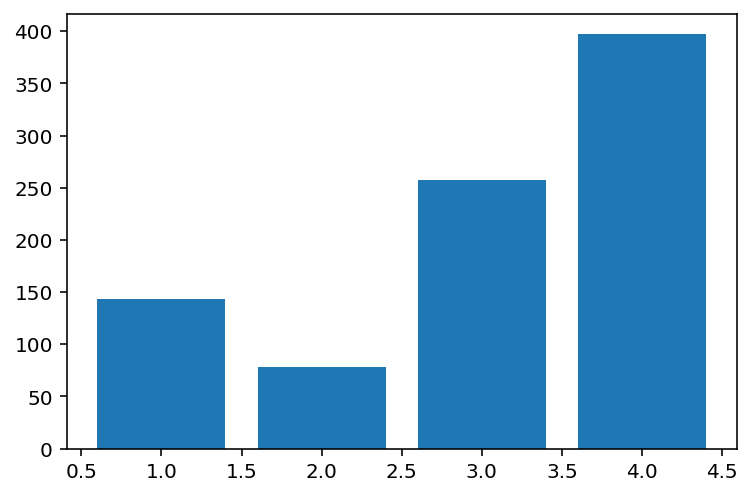

ANREDE_KZ


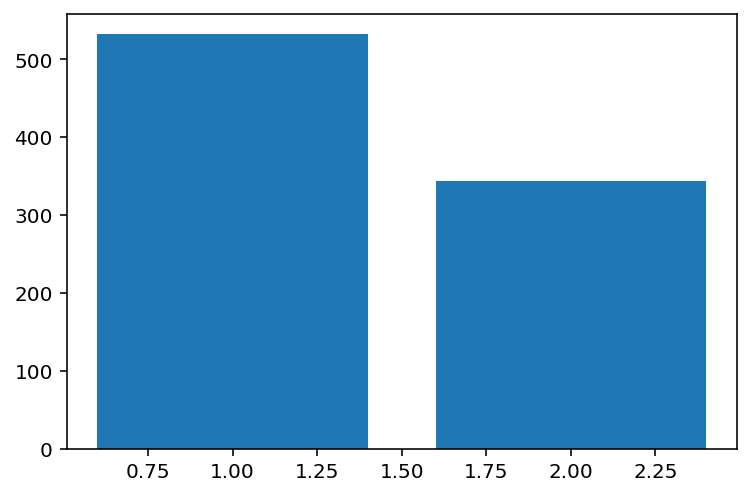

CJT_GESAMTTYP


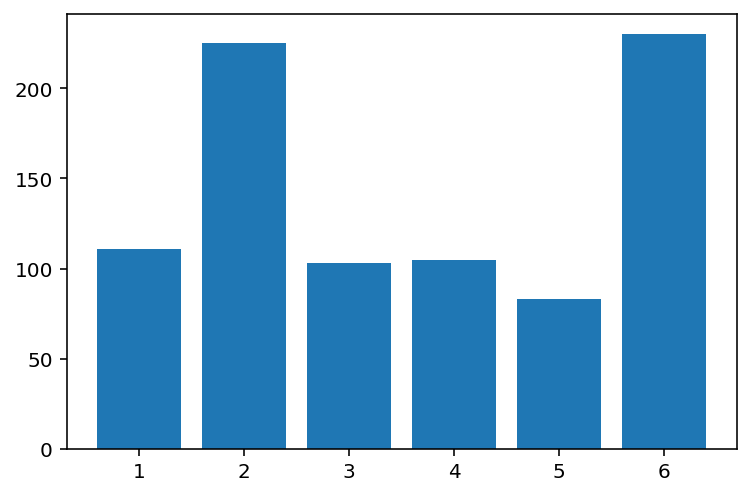

FINANZ_MINIMALIST


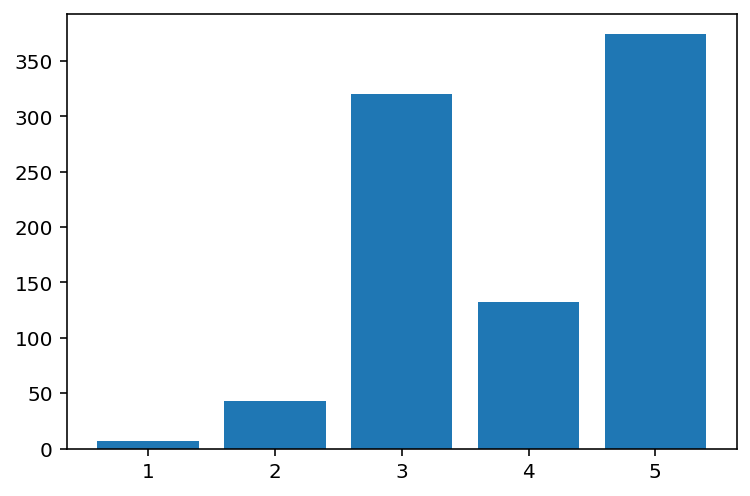

FINANZ_SPARER


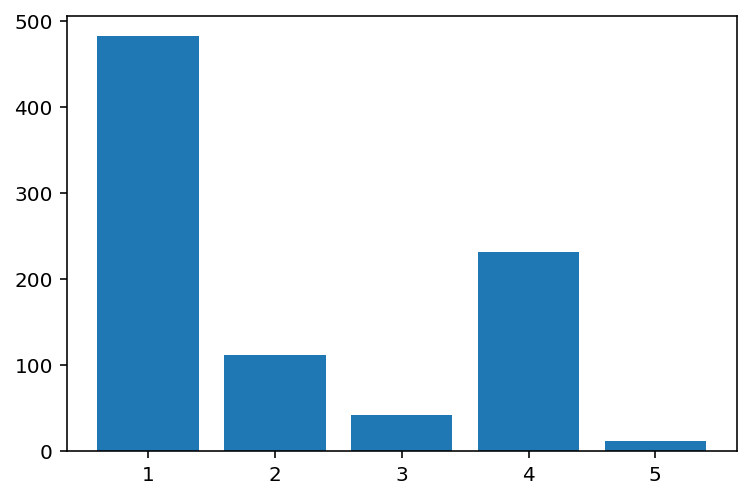

FINANZ_VORSORGER


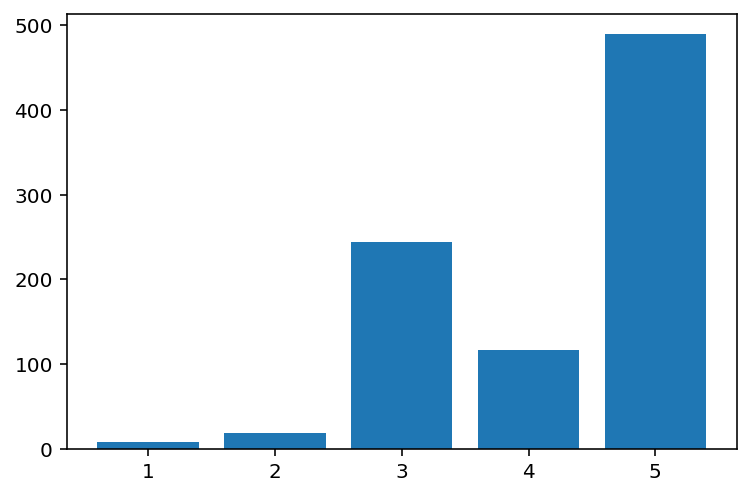

FINANZ_ANLEGER


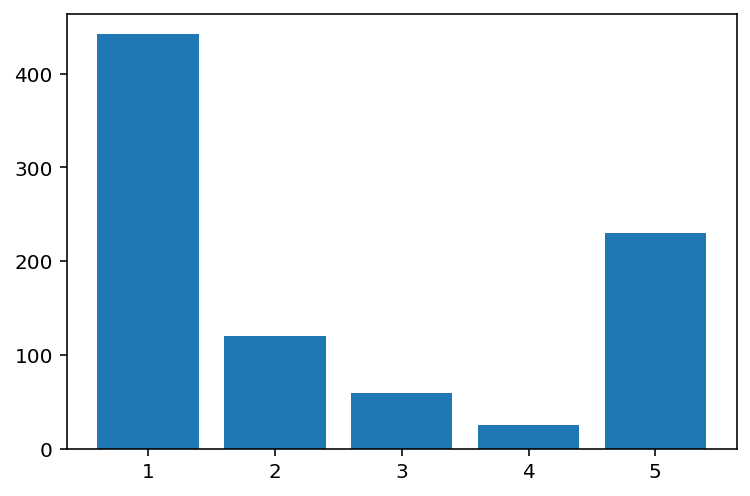

FINANZ_UNAUFFAELLIGER


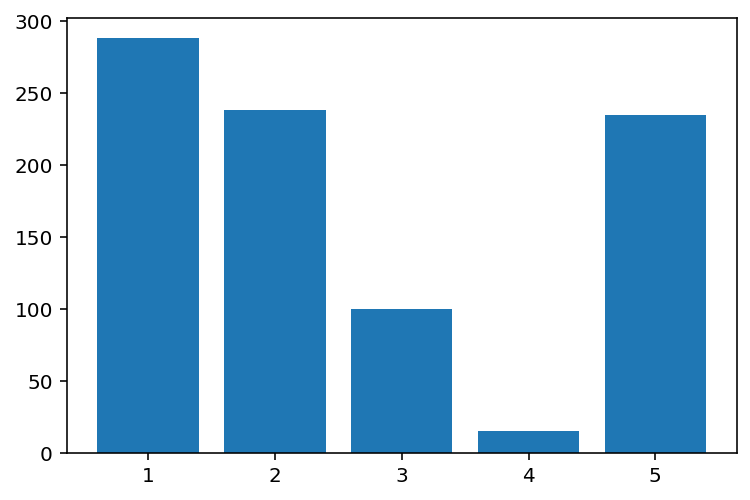

FINANZ_HAUSBAUER


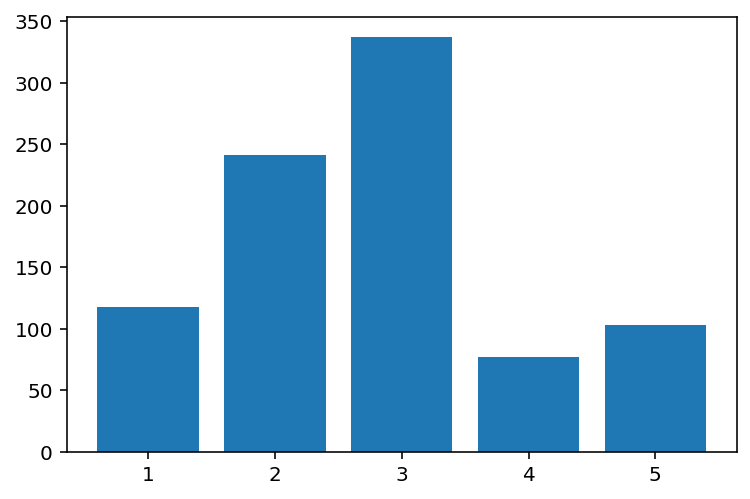

FINANZTYP


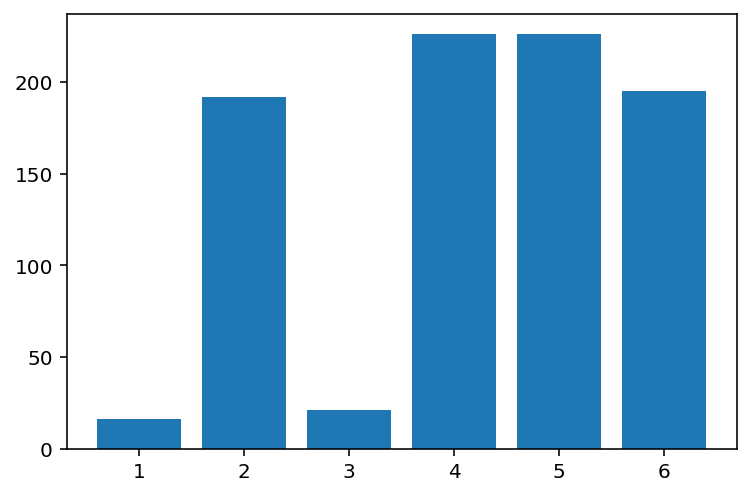

GFK_URLAUBERTYP


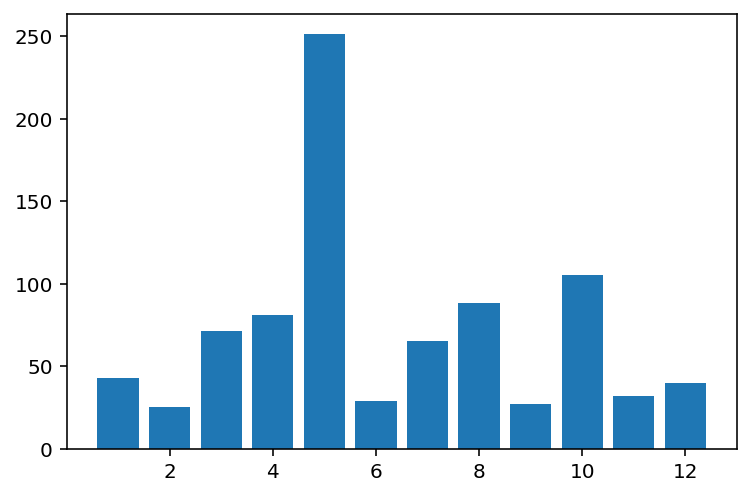

GREEN_AVANTGARDE


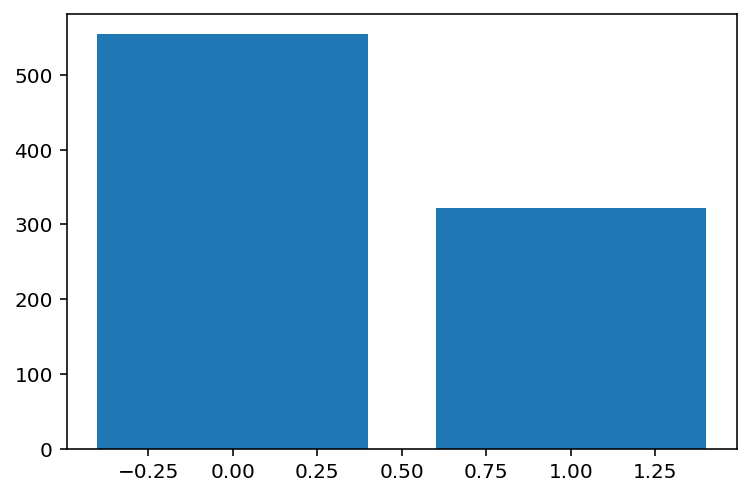

LP_STATUS_FEIN


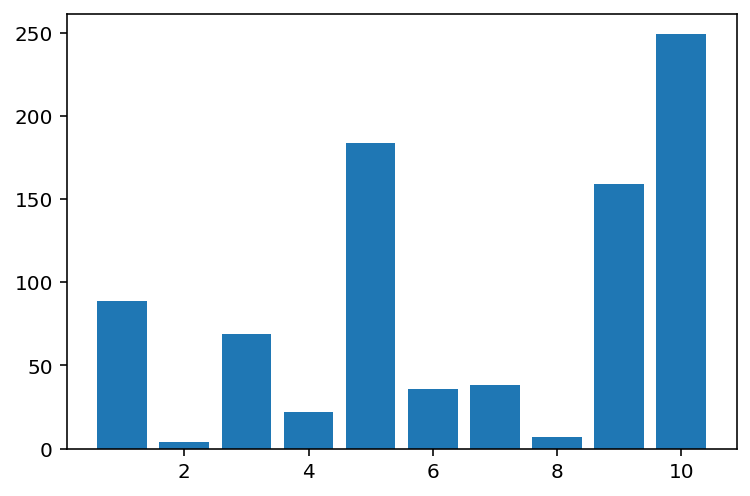

LP_STATUS_GROB


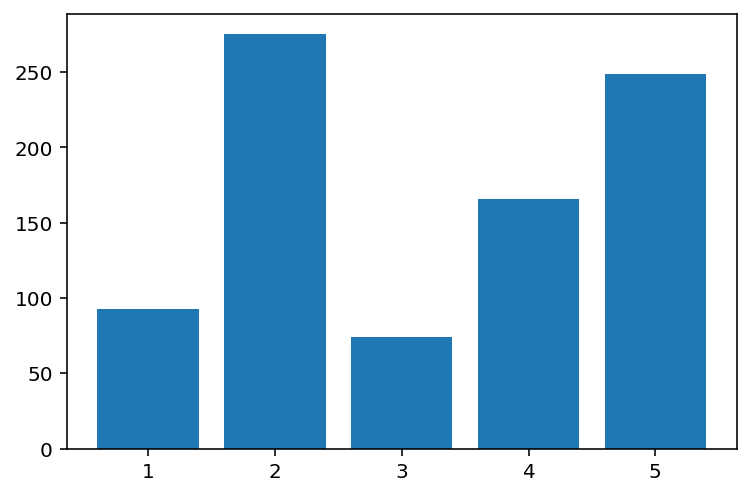

RETOURTYP_BK_S


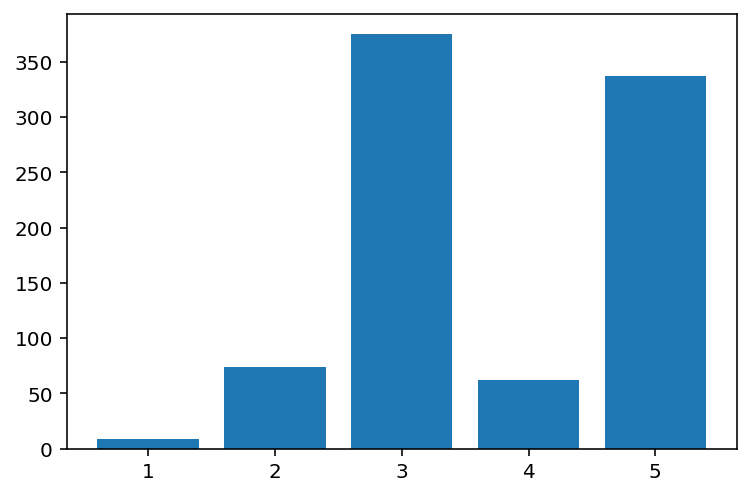

SEMIO_SOZ


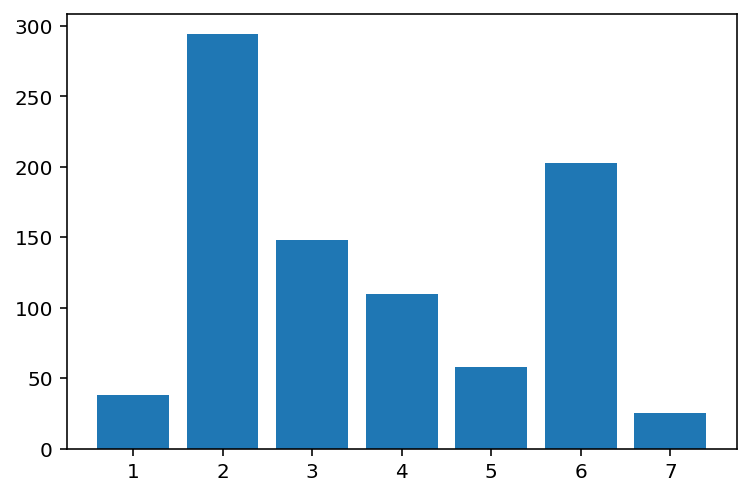

SEMIO_FAM


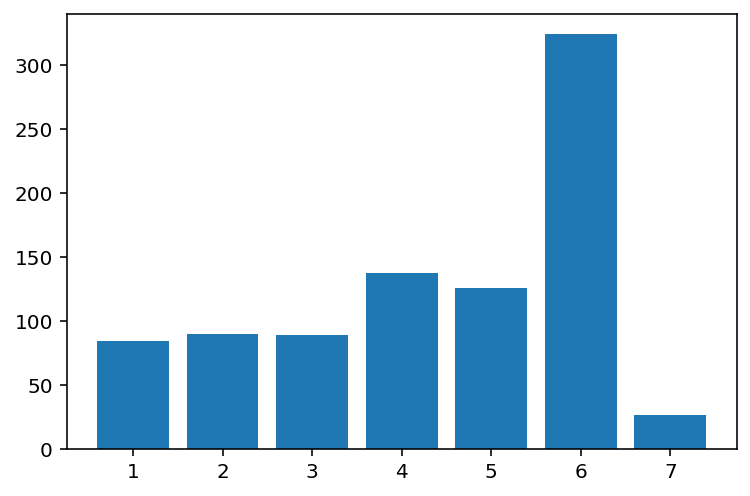

SEMIO_REL


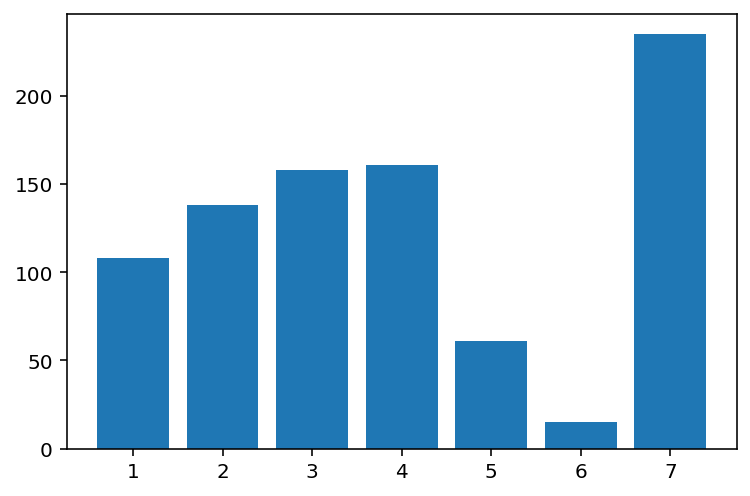

SEMIO_MAT


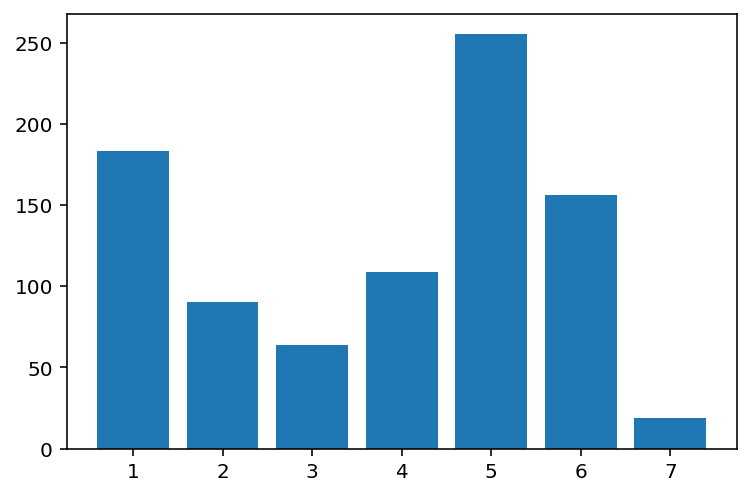

SEMIO_VERT


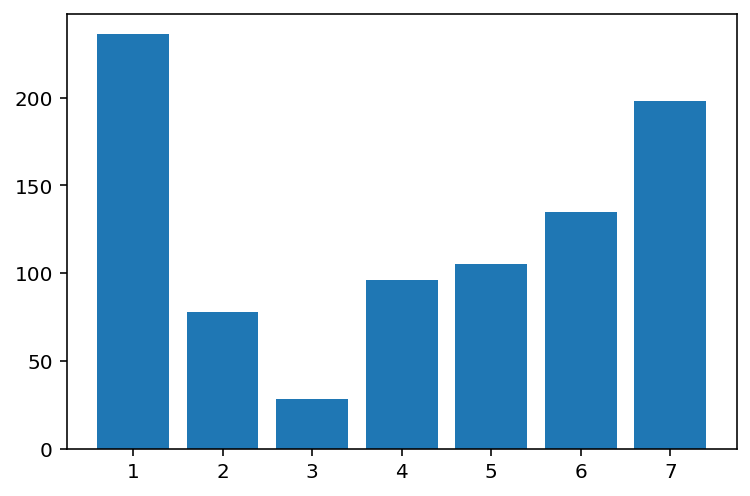

SEMIO_LUST


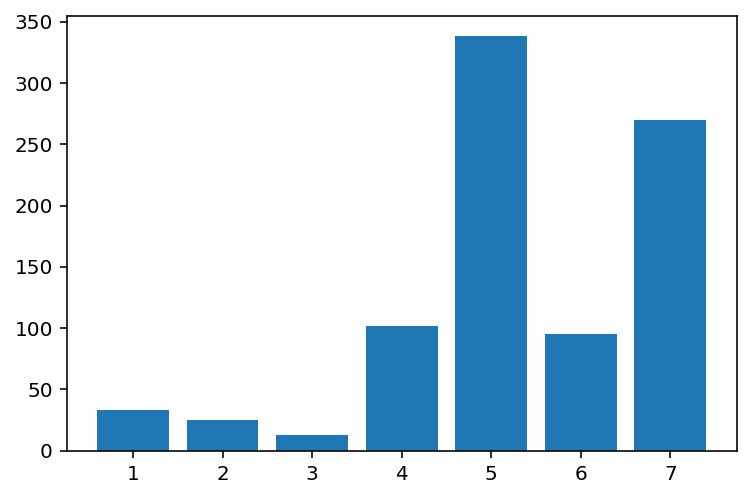

SEMIO_ERL


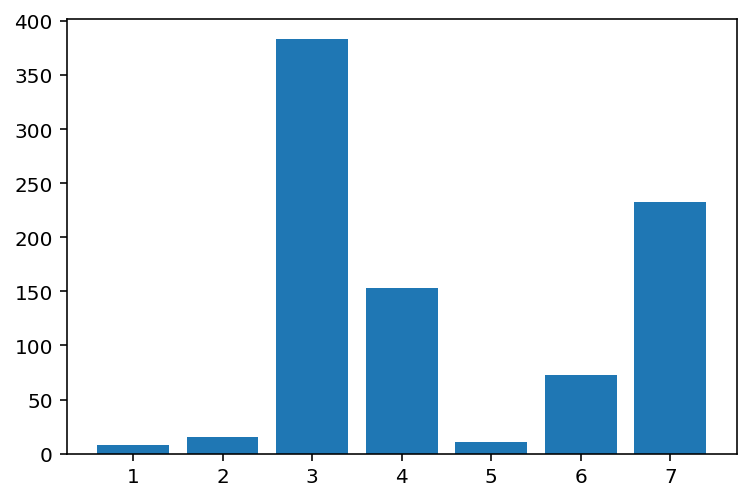

SEMIO_KULT


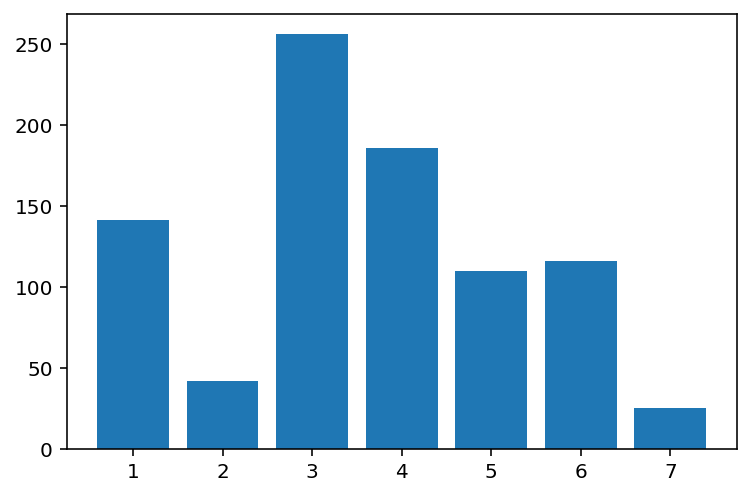

SEMIO_RAT


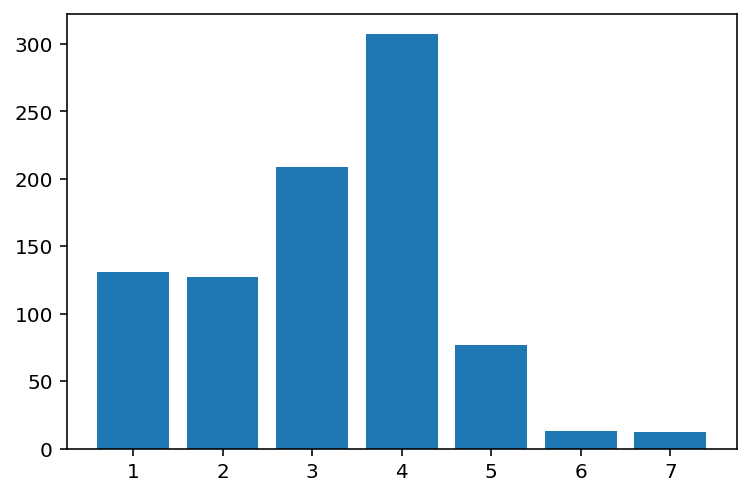

SEMIO_KRIT


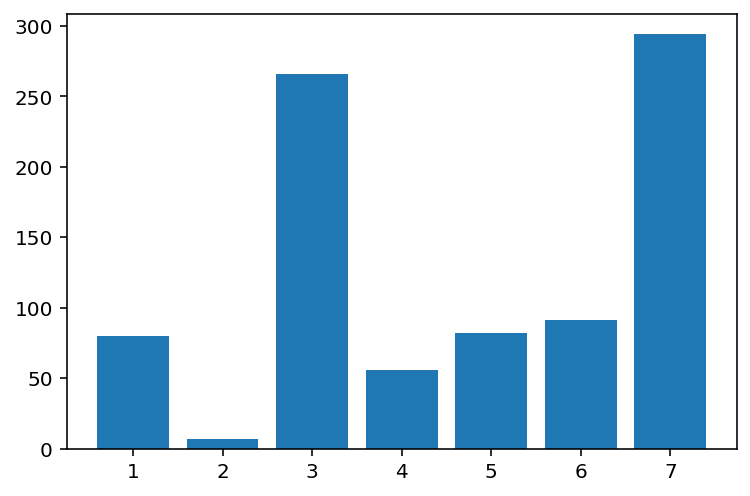

SEMIO_DOM


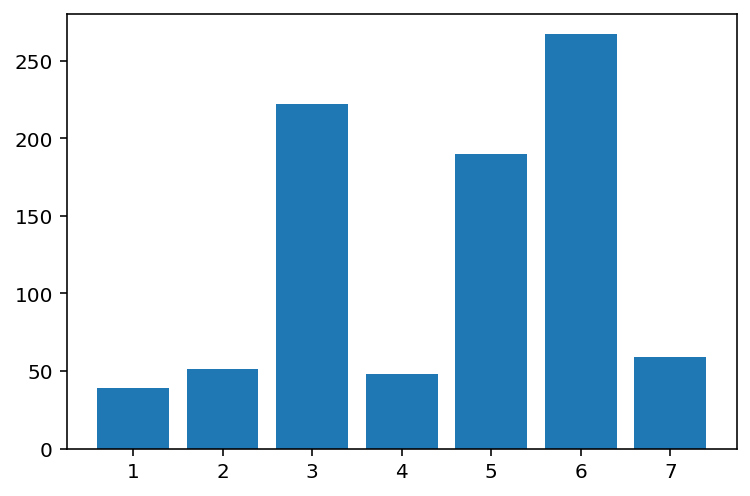

SEMIO_KAEM


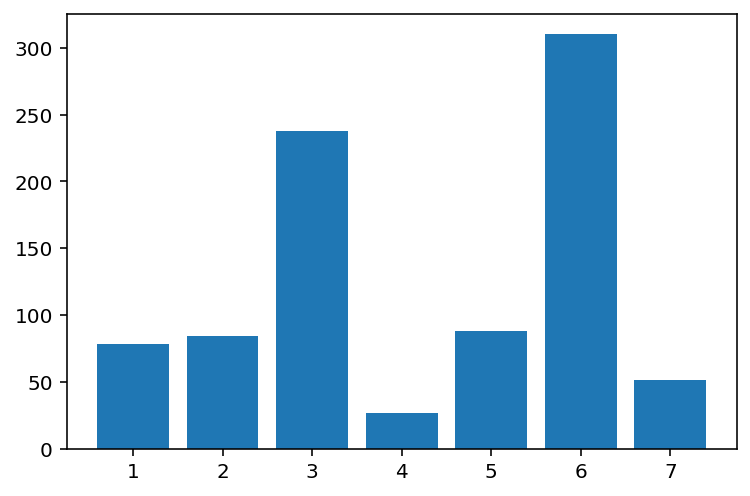

SEMIO_PFLICHT


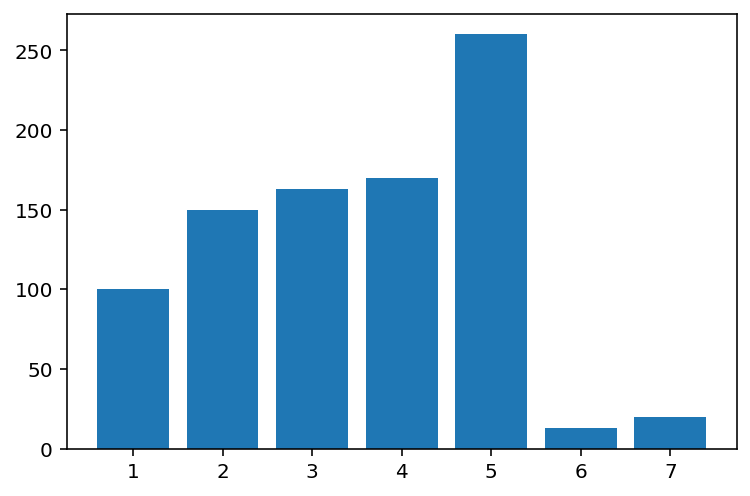

SEMIO_TRADV


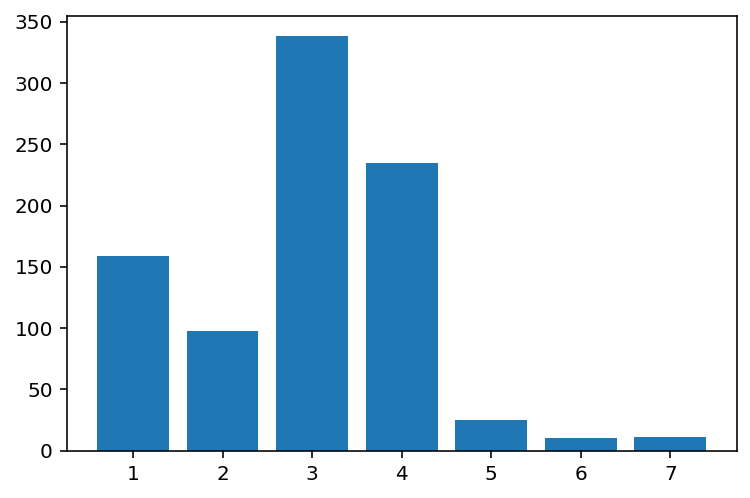

ZABEOTYP


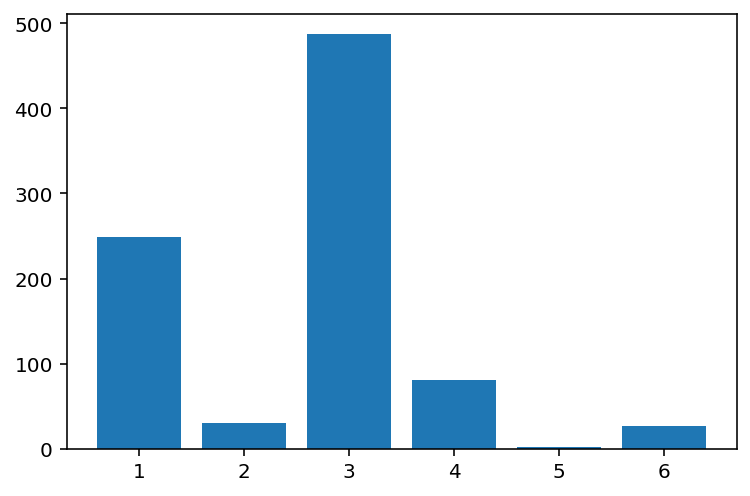

HH_EINKOMMEN_SCORE


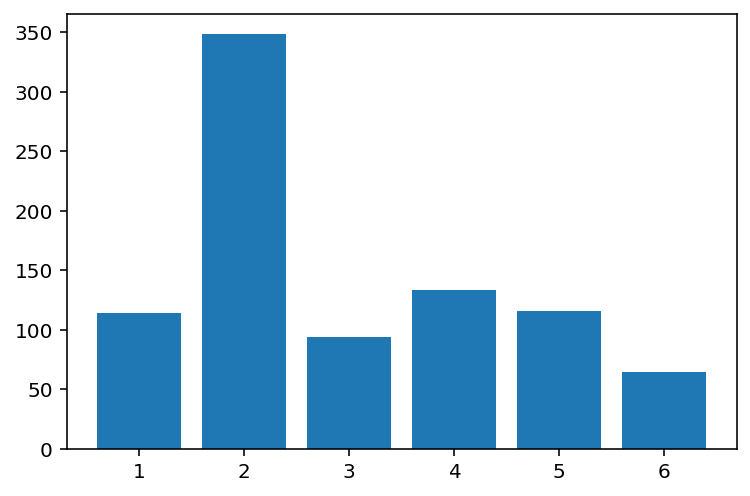

ONLINE_AFFINITAET


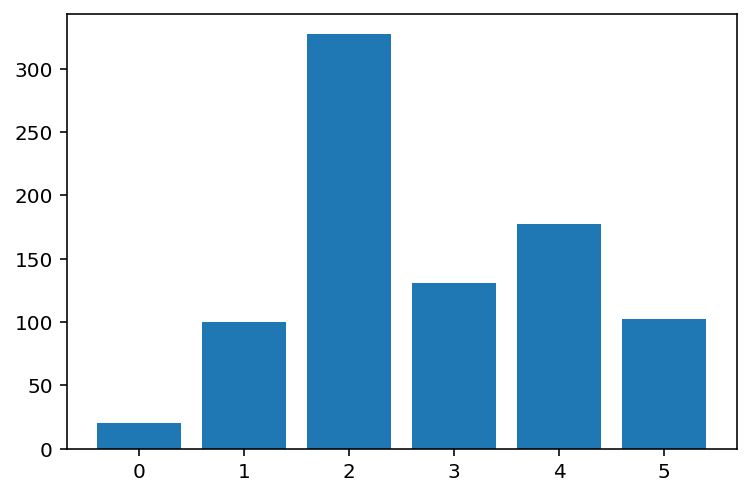

In [109]:
# print statistics about those people

for column in class_non_target:
    print(column)
    plt.bar(class_non_target[column].value_counts().sort_index().index,class_non_target[column].value_counts().sort_index().values)
    plt.show()

##### What kinds of people are part of a cluster that is underrepresented in the
##### customer data compared to the general population?

Unfortunately, the stats are really really similar for both clusters...
Not really sure how to proceed here.

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.